In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from src.n_forest import alpha

In [2]:
def deriv_forest(x, y, penalty_rate, args):
    """
    Calculate derivatives of x and y over time as per the Antonovsky & Korzukhin rule.
    
    INPUT:
    x            = value for x; density of young trees in ecosystem, typically between 0 and 4
    y            = value for y; density of old trees in ecosystem, typically between 0 and 4
    penalty_rate = penalty rate calculated by penalty function
    args         = tuple of 6 arguments

    Returns derivatives of x and y.
    """
    # Unpack arguments rho, gamma (not used), f, h, a1 and a2
    fertility, mortality_young, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old, dist, beta_2, P_0 = args
    
    # Calculate derivatives
    dx = fertility * y - ((y - 1)**2 + 1) * x - aging_rate * x + biotic_pump_young * penalty_rate * x
    dy = aging_rate * x - mortality_old * y + biotic_pump_old * penalty_rate * y
    
    return dx, dy

In [3]:
def deriv_forest_for_solver(t, u, fertility, mortality_young, aging_rate, 
                            biotic_pump_young, mortality_old, biotic_pump_old, dist, beta_2, P_0, x0s, y0s, i):
    """
    Calculate derivatives of x and y over time as per the Antonovsky & Korzukhin rule with the penalty function included, 
    
    INPUT:
    x            = value for x; density of young trees in ecosystem, typically between 0 and 4
    y            = value for y; density of old trees in ecosystem, typically between 0 and 4
    penalty_rate = penalty rate calculated by penalty function
    the args above here are given seperately, as solve ivp unpacks its arguments already

    Returns derivatives of x and y.
    """
    # Unpack arguments rho, gamma (not used), f, h, a1 and a2
    #fertility, mortality_young, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old, x0s, y0s, i = args
    x, y = u
    penalty_rate = alpha(x0s, y0s, dist, beta_2 = beta_2, P_0 = P_0)
    
    # Calculate derivatives
    dx = fertility * y - ((y - 1)**2 + 1) * x - aging_rate * x + biotic_pump_young * penalty_rate[i] * x
    dy = aging_rate * x - mortality_old * y + biotic_pump_old * penalty_rate[i] * y
    
    return (dx, dy)

In [4]:
fertility = 4.2 #rho
mortality_young = 0.01 # should be the weird quadratic function but i think making a constant based on data is better
# for now implemented as 
aging_rate = 1 #f
biotic_pump_young = 1 #a1
mortality_old = 2 #h
biotic_pump_old = 0 #a2
dist = 800
beta_2 = 0.15
P_0 = 1.05

arguments = (fertility, mortality_young, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old, dist, beta_2, P_0)

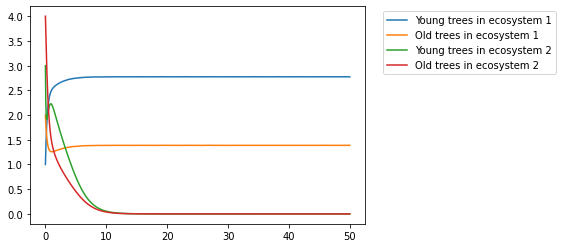

In [5]:
def system_n_forests_solveivp(x0s, y0s, args, timesteps = 100, dt = 0.01):
    """
    Solves a system of ODEs
    INPUT:
    x0s       = array of values for x, the density of young trees in the ecosystem; typically between 0 and 4
    y0s       = array of values for y, the density of old trees in the ecosystem; typically between 0 and 4
    args      = tuple of arguments needed for the derivation function
    timesteps = int, timesteps to iterate over; default 100
    dt        = delta time, default 0.01
    
    Returns two arrays of x and y values per time
    """
       
    n = len(x0s)
    x_vals = np.empty((n, int(timesteps/dt)))
    y_vals = np.empty((n, int(timesteps/dt)))
    
    args = [*args, x0s, y0s, 0]
    for i in range(n):
        args[-1] = i 
        res = solve_ivp(deriv_forest_for_solver, [0, timesteps], [x0s[i], y0s[i]], t_eval = np.arange(0, timesteps, dt), 
                        args = (args))
        x_vals[i, :] = res.y[0]
        y_vals[i, :] = res.y[1]
            
    return res.t, x_vals, y_vals

time = 50
t, xs, ys = system_n_forests_solveivp([1, 3], [2, 4], arguments, time)

for i, x in enumerate(xs):
    plt.plot(t, x, label = f"Young trees in ecosystem {i+1}")
    plt.plot(t, ys[i], label = f"Old trees in ecosystem {i+1}")
    
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()


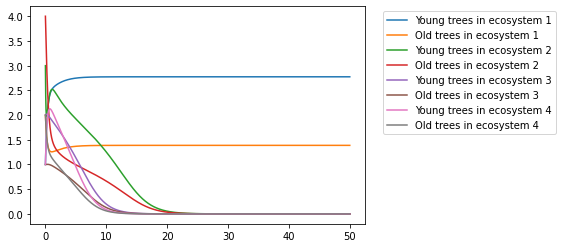

In [17]:
def system_n_forests_forward(x0s, y0s, args, timesteps = 100, dt = 0.001):
    """
    Solves a system of ODEs
    INPUT:
    x0s       = array of values for x, the density of young trees in the ecosystem; typically between 0 and 4
    y0s       = array of values for y, the density of old trees in the ecosystem; typically between 0 and 4
    args      = tuple of arguments needed for the derivation function
    timesteps = int, timesteps to iterate over; default 100
    dt        = delta time, default 0.01
    
    Returns two arrays of x and y values per time
    """
    alt_penalties = []
    n = len(x0s)
    x_vals = np.empty((n, int(timesteps/dt)))
    y_vals = np.empty((n, int(timesteps/dt)))

    for t in range(int(timesteps / dt)):
        penalties = alpha(x0s, y0s, dist=args[6]/(n-1), beta_2 = args[7], P_0 = args[8])
        for i in range(n):
            
            x_vals[i, t] = x0s[i]
            y_vals[i, t] = y0s[i]
            
            dx, dy = deriv_forest(x0s[i], y0s[i], penalties[i], args)
            x0s[i] += dx * dt
            y0s[i] += dy * dt
            alt_penalties.append(penalties[i])
            
            
    return x_vals, y_vals, alt_penalties


time = 50
dt = 0.01
xs, ys, alt_penalties = system_n_forests_forward([1, 3, 2, 1], [2, 4, 1,2], arguments, time, dt)

for i, x in enumerate(xs):
    plt.plot(np.arange(0, time, dt), x, label = f"Young trees in ecosystem {i+1}")
    plt.plot(np.arange(0, time, dt), ys[i], label = f"Old trees in ecosystem {i+1}")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()


Trying to remake figure 8

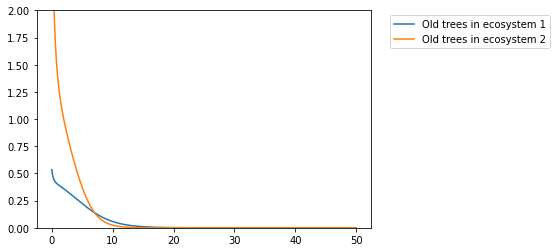

In [7]:
time = 50
dt = 0.01
xs, ys, alt_penalties = system_n_forests_forward([np.random.uniform(0, 4), np.random.uniform(0,4)],
                                                 [np.random.uniform(0,4), np.random.uniform(0,4)], arguments, time, dt)

for i, x in enumerate(xs):
    #plt.plot(np.arange(0, time, dt), x, label = f"Young trees in ecosystem {i+1}")
    plt.plot(np.arange(0, time, dt), ys[i], label = f"Old trees in ecosystem {i+1}")
plt.ylim(0,2)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()


In [8]:
fertility = 4.2 #rho
mortality_young = 0.01 # should be the weird quadratic function but i think making a constant based on data is better
# for now implemented as 
aging_rate = 1 #f
biotic_pump_young = 1 #a1
mortality_old = 2 #h
biotic_pump_old = 0 #a2
dist = 900
beta_2 = 0.15
P_0 = 1.05

arguments = (fertility, mortality_young, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old, dist, beta_2, P_0)

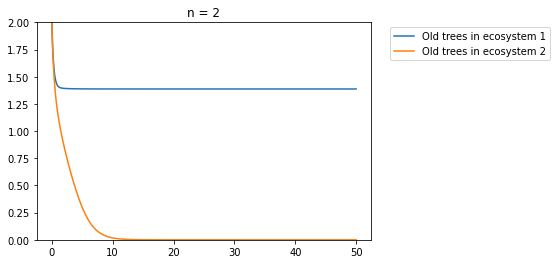

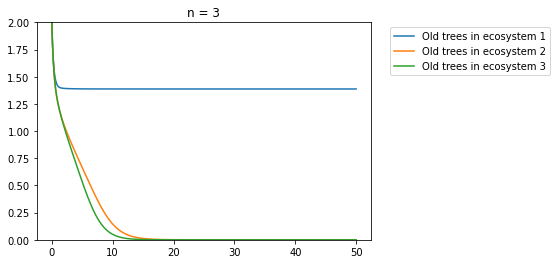

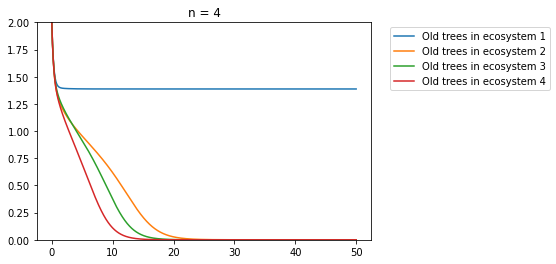

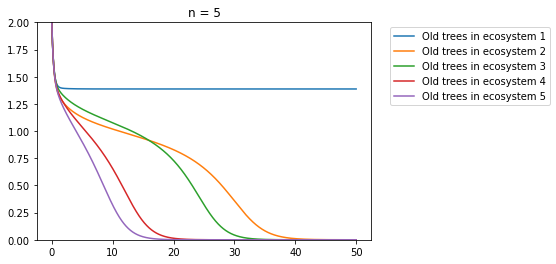

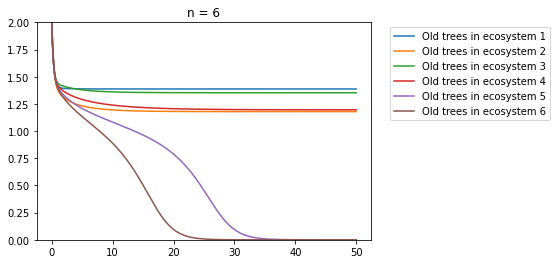

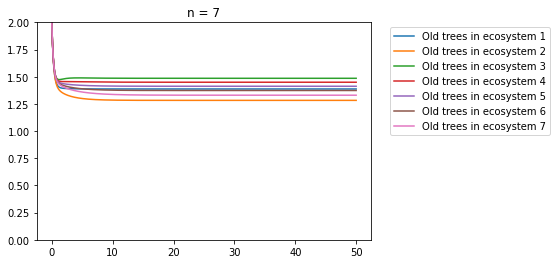

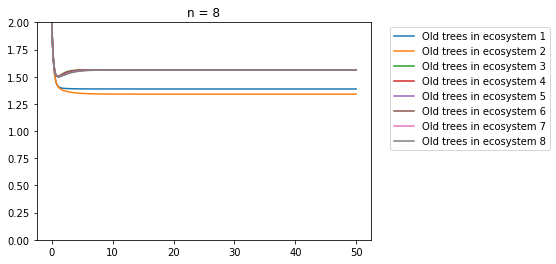

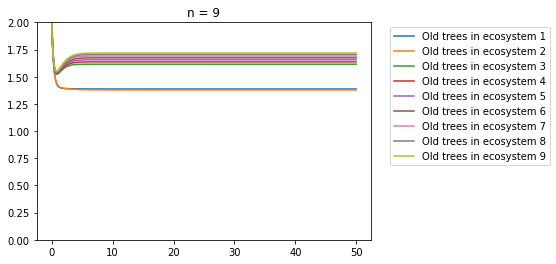

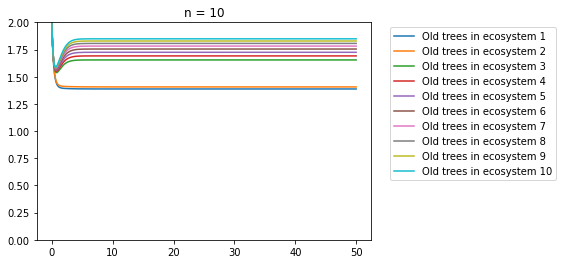

In [18]:
for n in range(2, 11):
    xs, ys, alt_penalties = system_n_forests_forward(2*np.ones(n), 2*np.ones(n), arguments, time, dt)

    for i, y in enumerate(ys):
        #plt.plot(t, x, label = f"Young trees in ecosystem {i+1}")
        plt.plot(np.arange(0, time, dt), y, label = f"Old trees in ecosystem {i+1}")
    plt.title(f"n = {n}")
    plt.ylim(0,2)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.show()

In [13]:
np.random.uniform(0,4, n)

array([2.49186811, 1.21639412, 3.91208246, 0.28718194, 0.45123573,
       1.32569109, 1.54171638, 3.87109258, 3.57117203, 1.79611141])

In [10]:
for n in range(2, 10):
    t, xs, ys = system_n_forests_solveivp(np.random.uniform(0,4, (1,n)).flatten(), np.random.uniform(2,4, (1,n)).flatten(), arguments, time, dt)

    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAy4AAAGzCAYAAADJ1EMfAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOydd3wVVfr/3zO33/SEVAgpNINECCC9t4C77CK4KIKCFMuCgi6KqMCKCl8VBZQfC6ImKqAoiuyqdEUQkCJFOiQkECBAes+t8/vj3lxySaUG8bxfr3nNzKnPzM3Nnc+c5zxHUhRFQSAQCAQCgUAgEAhuY+S6NkAgEAgEAoFAIBAIakIIF4FAIBAIBAKBQHDbI4SLQCAQCAQCgUAguO0RwkUgEAgEAoFAIBDc9gjhIhAIBAKBQCAQCG57hHARCAQCgUAgEAgEtz1CuAgEAoFAIBAIBILbHiFcBAKBQCAQCAQCwW2PEC4CgUAgEAgEAoHgtkcIF4FAIBAIBAKBQHDbI4SLQCD4w5Oens6LL75Iz5498fLyQpIkNm/eXGX57du306VLF4xGIyEhITzzzDMUFhbeOoMFAoFAIBBcNUK4CASCPzzHjx/nzTff5Ny5c8TGxlZbdv/+/fTu3Zvi4mLeffddxo4dywcffMA//vGPW2StQCAQCASCa0Fd1wYIBALB9dKmTRuysrLw9/dn5cqV1YqQl156CT8/PzZv3oy3tzcAkZGRjBs3jvXr19OvX79bZbZAIBAIBIKrQIy4CASCa+Lf//43kiSRlJTEqFGj8PX1xcfHh8cee4zi4uJbaouXlxf+/v41lsvPz2fDhg2MGDHCJVoAHn30UTw9Pfnyyy9vppkCgUAgEAiuAzHiIhAIrouhQ4cSFRXF7Nmz2bt3Lx9++CFBQUG8+eab1dYrLi6ulcBRqVT4+fndEFsPHjyI1Wqlbdu2bularZZWrVqxb9++G9KPQCAQCASCG48QLgKB4LqIi4vjo48+cp1nZWXx0Ucf1Shc3nrrLV599dUa24+IiCA1NfV6zQQck/gBQkNDK+SFhoaydevWG9KPQCAQCASCG48QLgKB4Lp48skn3c67du3KqlWryM/Pd3PHupJHH32ULl261Ni+wWC4bhvLKCkpAUCn01XI0+v1rnyBQCAQCAS3H0K4CASC66Jhw4Zu52VuXTk5OdUKl+joaKKjo2+qbVdSJoJMJlOFvNLS0hsqkgQCgUAgENxYhHARCATXhUqlqjRdUZRq6xUWFtZq7RSVSkVgYOA12XYlZS5iZS5j5UlPTycsLOyG9CMQCAQCgeDGI6KKCQSCOmHOnDmEhobWuN177703rM8WLVqgVqvZs2ePW7rZbGb//v20atXqhvUlEAgEAoHgxiJGXAQCQZ1QF3NcfHx86NOnD0uXLmXatGl4eXkB8Nlnn1FYWCgWoRQIBAKB4DZGCBeBQFAn3Og5Lq+//joAhw8fBhxi5JdffgHglVdecZV744036NSpE927d+fxxx/n7NmzvPPOO/Tr14/+/fvfMHsEAoFAIBDcWIRwEQgEdwTTpk1zO//4449dx+WFS+vWrdm4cSNTpkzh2WefxcvLizFjxjB79uxbZqtAIBAIBIKrR1JqmkErEAgEAoFAIBAIBHWMmJwvEAgEAoFAIBAIbnuEcBEIBAKBQCAQCAS3PUK4CAQCgUAgEAgEgtueqxIus2fP5t5778XLy4ugoCAGDRrE8ePHa6z31Vdfcdddd6HX64mNjeWHH35wy1cUhenTpxMaGorBYKBPnz6cPHny6q5EIBAIBAKBQCAQ3LFclXD5+eefGT9+PL/++isbNmzAYrHQr18/ioqKqqyzfft2hg0bxpgxY9i3bx+DBg1i0KBBHDp0yFXmrbfe4r333mPRokXs3LkTDw8P4uPjKS0tvfYrEwgEAoFAIBAIBHcM1xVVLCMjg6CgIH7++We6detWaZkHH3yQoqIivvvuO1dahw4daNWqFYsWLUJRFMLCwvjXv/7F5MmTAcjLyyM4OJjExEQeeuihazVPIBAIBAKBQCAQ3CFc1zoueXl5APj7+1dZZseOHTz33HNuafHx8Xz77bcApKSkcOHCBfr06ePK9/HxoX379uzYsaNS4WIymTCZTK5zu91OdnY2AQEBSJJ0PZckEAgEAoHgFqEoCgUFBYSFhSHLYtqtQCConmsWLna7nUmTJtG5c2datGhRZbkLFy4QHBzslhYcHMyFCxdc+WVpVZW5ktmzZ/Pqq69eq+kCgUAgEAhuI9LS0mjQoEFdmyEQCG5zrlm4jB8/nkOHDvHLL7/cSHtqxdSpU91GcfLy8mjYsCFpaWl4e3vf2M5MBZwd0onPOj7MsvZ9KdVqeVV5EV1yPulbQhk68/8IbtjoxvYpEAgEAsGfgPz8fMLDw/Hy8qprUwQCwR+AaxIuEyZM4LvvvmPLli01viEJCQnh4sWLbmkXL14kJCTElV+WFhoa6lamVatWlbap0+nQ6XQV0r29vW+8cLFo8NJIGDQ6dHodZoMHsuKJl38+ORoNdsVy4/sUCAQCgeBPhHDzFggEteGqHEoVRWHChAmsWrWKH3/8kaioqBrrdOzYkU2bNrmlbdiwgY4dOwIQFRVFSEiIW5n8/Hx27tzpKlOnyGokCWRFQW23AWBCh0pvByA/L7surRMIBAKBQCAQCP4UXNWIy/jx41m+fDmrV6/Gy8vLNQfFx8cHg8EAwKOPPkr9+vWZPXs2ABMnTqR79+688847/OUvf+GLL75gz549fPDBB4DjLcukSZN4/fXXadKkCVFRUUybNo2wsDAGDRp0Ay/1GpHVSDJIdtDYrACY0KPROYRLQYEQLgKBQCAQCAQCwc3mqoTLf/7zHwB69Ojhlp6QkMCoUaMAOHPmjFtkkE6dOrF8+XJeeeUVXnrpJZo0acK3337rNqH/hRdeoKioiMcff5zc3Fy6dOnC2rVr0ev113hZNxBJAtk54mK7POKi0TmOCwty69A4gUAgEAgEAoHgz8FVCZfaLPmyefPmCmn/+Mc/+Mc//lFlHUmSmDlzJjNnzrwac24Zkiwh2xU0LlcxPWqNFVAoys+tU9sEAoFAIBDUHkVRsFqt2JwvIwUCQd2i0WhQqVS1Kntd67j8aXAKF7XTVawUHZIEKp2d4sL8OjZOIBAIBAJBbTCbzaSnp1NcXFzXpggEAieSJNGgQQM8PT1rLCuES22QZWS7HY3z7YzZ7gEyqHQ2SosK69g4gUAgEAgENWG320lJSUGlUhEWFoZWqxXRzASCOkZRFDIyMjh79ixNmjSpceRFCJdaIKskp3BxjrjYfUAGtd5GaVFRHVsnEAgEAoGgJsxmM3a7nfDwcIxGY12bIxAInAQGBpKamorFYqlRuFxVOOQ/K5JaRrbZ0VotAJTaHeu2qPVWbMWldWmaQCAQCASCq6B8ACGBQFD3XM3Ip/j21gJJJSPbbS7hUqI4VvhVG63YS811aZpAIBAIBAKBQPCnQAiXWiCpZFQ2OzqbQ7gUO4WLxmiFUktdmiYQCAQCgUAgEPwpEMKlFkhqlXPExTHHpRiHb6zGaEUy2WsVJlogEAgEAoHgZhMZGcm8efOqLSNJEt9+++0tsedGs3nzZiRJIjc3t65NEdQBQrjUAkmtQmW77CpWLDkWxlQbrch2MJeIsIoCgUAgEAhuHmlpaYwePdoVES0iIoKJEyeSlZV1w/vq0aMHkyZNuuHt3gg6depEeno6Pj4+dW1KnZCamookSezfv7/ObHjmmWdo06YNOp2OVq1a3dK+hXCpBQ7hYr0sXGQdAGoPxwhMUW5OndkmEAgEAoHgzubUqVO0bduWkydP8vnnn5OUlMSiRYvYtGkTHTt2JDs7+5bbVLaQ561Gq9USEhIiQlnXMaNHj+bBBx+85f0K4VILJI3aMeLinONSKGuAy8KlWAxXCgQCgUDwh0NRFIrN1jrZrsbNfPz48Wi1WtavX0/37t1p2LAhAwYMYOPGjZw7d46XX365yronT56kW7du6PV6mjdvzoYNG6rta9SoUfz888/Mnz8fSZKQJInU1FSXi9aaNWtcb9t/+eUX7HY7s2fPJioqCoPBQMuWLVm5cqVbm4cOHWLAgAF4enoSHBzMI488QmZmpit/5cqVxMbGYjAYCAgIoE+fPhRVsdzEla5iiYmJ+Pr6sm7dOmJiYvD09KR///6kp6dXe5012WS323nrrbdo3LgxOp2Ohg0b8sYbb7jyDx48SK9evVw2P/744xQWXl7bb/PmzbRr1w4PDw98fX3p3Lkzp0+fJjU1FVmW2bNnj5s98+bNIyIiArvdTk5ODsOHDycwMBCDwUCTJk1ISEgAICoqCoC4uDgkSaJHjx6uNj788ENiYmLQ6/XcddddLFy40JVXNlLz5Zdf0rVrVwwGA/feey8nTpxg9+7dtG3bFk9PTwYMGEBGRka19+69995j/PjxREdHV1vuZiDWcakFklqNymZBVzbiolZhV2S0eiugkJtziQZ1a6JAIBAIBIKrpMRio/n0dXXS95GZ8Ri1NT+GZWdns27dOt544w0MBoNbXkhICMOHD2fFihUsXLiwwiiE3W5n8ODBBAcHs3PnTvLy8mp0AZs/fz4nTpygRYsWzJw5E7i8zgbAiy++yJw5c4iOjsbPz4/Zs2ezdOlSFi1aRJMmTdiyZQsjRowgMDCQ7t27k5ubS69evRg7dixz586lpKSEKVOmMHToUH788UfS09MZNmwYb731Fvfffz8FBQVs3br1qoRdcXExc+bM4bPPPkOWZUaMGMHkyZNZtmxZpeVrsglg6tSpLFmyhLlz59KlSxfS09M5duwYAEVFRcTHx9OxY0d2797NpUuXGDt2LBMmTCAxMRGr1cqgQYMYN24cn3/+OWazmV27diFJEhEREfTp04eEhATatm3rsikhIYFRo0YhyzLTpk3jyJEjrFmzhnr16pGUlERJSQkAu3btol27dmzcuJG7774brVYLwLJly5g+fToLFiwgLi6Offv2MW7cODw8PBg5cqSrnxkzZjBv3jwaNmzI6NGjefjhh/Hy8mL+/PkYjUaGDh3K9OnT+c9//lPr+38rEcKlFjhGXCyuyfkAJejxUBWj0tvIzDhfh9YJBAKBQCC4Uzl58iSKohATE1NpfkxMDDk5OWRkZBAUFOSWt3HjRo4dO8a6desICwsDYNasWQwYMKDK/nx8fNBqtRiNRkJCQirkz5w5k759+wJgMpmYNWsWGzdupGPHjgBER0fzyy+/sHjxYrp37+56kJ41a5arjY8//pjw8HBOnDhBYWEhVquVwYMHExERAUBsbOxV3CGwWCwsWrSIRo0aATBhwgSX6KqMmmwKDQ1l/vz5LFiwwPXQ36hRI7p06QLA8uXLKS0t5dNPP8XDw8PV5sCBA3nzzTfRaDTk5eXx17/+1WVT+c9v7NixPPnkk7z77rvodDr27t3LwYMHWb16NQBnzpwhLi7OJWwiIyNddQMDAwEICAhw+3xmzJjBO++8w+DBgwHHyMyRI0dYvHixm3CZPHky8fHxAEycOJFhw4axadMmOnfuDMCYMWNITEys1X2vC4RwqQWSRoPaakal2FHb7FhVMiZLKB6aZLSeFnKyL9a1iQKBQCAQCK4Sg0bFkZnxddb31XAtEUyPHj1KeHi4S7QALoFxrZQfJUhKSqK4uNglZMowm83ExcUBcODAAX766Sc8PT0rtJWcnEy/fv3o3bs3sbGxxMfH069fPx544AH8/PxqbZPRaHQJBIDQ0FAuXbpUZfmabMrNzcVkMtG7d+9K6x89epSWLVu6RAtA586dsdvtHD9+nG7dujFq1Cji4+Pp27cvffr0YejQoYSGhgIwaNAgxo8fz6pVq3jooYdITEykZ8+eLoHy1FNPMWTIEPbu3Uu/fv0YNGgQnTp1qvJ6ioqKSE5OZsyYMYwbN86VbrVaKwQxuOeee1zHwcHBgLtQDA4Orvbe1TVCuNQGtQaVc7RFa7ViVWkxm+uDJhmtt4W8nOp9AQUCgUAgENx+SJJUK3etuqRx48ZIksTRo0e5//77K+QfPXoUPz8/15v4m035h/WyOR3ff/899evXdyun0+lcZcpGIq4kNDQUlUrFhg0b2L59O+vXr+f999/n5ZdfZufOna75HDWh0WjcziVJqlbo1WTTqVOnatVvdSQkJPDMM8+wdu1aVqxYwSuvvMKGDRvo0KEDWq2WRx99lISEBAYPHszy5cuZP3++q+6AAQM4ffo0P/zwAxs2bKB3796MHz+eOXPmVHk9AEuWLKF9+/ZueSqVu0Auf6/KXAuvTLPb7dd38TcRMTm/FkgaDSrnh6i3OARMidmhmnVeZjE5XyAQCAQCwU0hICCAvn37snDhQtc8hzIuXLjAsmXLePDBByuNshUTE0NaWprbRPVff/21xj61Wi02m63Gcs2bN0en03HmzBkaN27stoWHhwPQunVrDh8+TGRkZIUyZSJIkiQ6d+7Mq6++yr59+9BqtaxatarG/q+Vmmxq0qQJBoOBTZs2VVo/JiaGAwcOuAUQ2LZtG7Is06xZM1daXFwcU6dOZfv27bRo0YLly5e78saOHcvGjRtZuHChy1WuPIGBgYwcOZKlS5cyb948PvjgAwDXnJbyn09wcDBhYWGcOnWqwvXUVvz9URDCpRZIWg0qu+MPxGB2TNAvMjuG17TeFkz5BXVmm0AgEAgEgjubBQsWYDKZiI+PZ8uWLaSlpbF27Vr69u1L/fr13aJdladPnz40bdqUkSNHcuDAAbZu3VptBLIyIiMj2blzJ6mpqWRmZlb5Bt7Ly4vJkyfz7LPP8sknn5CcnMzevXt5//33+eSTTwBHRLTs7GyGDRvG7t27SU5OZt26dTz22GPYbDZ27tzJrFmz2LNnD2fOnOGbb74hIyOjyjk9N4KabNLr9UyZMoUXXniBTz/9lOTkZH799Vc++ugjAIYPH45er2fkyJEcOnSIn376iaeffppHHnmE4OBgUlJSmDp1Kjt27OD06dOsX7+ekydPul1TTEwMHTp0YMqUKQwbNswt8ML06dNZvXo1SUlJHD58mO+++85VNygoCIPBwNq1a7l48SJ5eXkAvPrqq8yePZv33nuPEydOcPDgQRISEnj33Xdv+P1LSkpi//79XLhwgZKSEvbv38/+/fsxm803vK8rEcKlFkgaDbKtbMTF8aEU2usBoPWyYMsTC1AKBAKBQCC4OTRp0oQ9e/YQHR3N0KFDadSoEY8//jg9e/Zkx44d+Pv7V1pPlmVWrVpFSUkJ7dq1Y+zYsVWKnPJMnjwZlUpF8+bNCQwM5MyZM1WWfe2115g2bRqzZ88mJiaG/v378/3337ve9IeFhbFt2zZsNhv9+vUjNjaWSZMm4evriyzLeHt7s2XLFu677z6aNm3KK6+8wjvvvFNtAIHrpSabAKZNm8a//vUvpk+fTkxMDA8++KBr7ofRaGTdunVkZ2dz77338sADD9C7d28WLFjgyj927BhDhgyhadOmPP7444wfP54nnnjCzY4xY8ZgNpsZPXq0W7pWq2Xq1Kncc889dOvWDZVKxRdffAGAWq3mvffeY/HixYSFhfH3v/8dcIzgfPjhhyQkJBAbG0v37t1JTEy8KSMuY8eOJS4ujsWLF3PixAni4uKIi4vj/PmbH6xKUq5lttdtRn5+Pj4+PuTl5eHt7X3D2y9+fyRb/5fOjk6d+CX6Xg6F12fUuXP0DXsGU56Go1805plPVqLR62943wKBQCAQ3Knc7N/v8pSWlpKSkkJUVBR68XstuA147bXX+Oqrr/j999/r2pQ65Wq+m2LEpRZIWi2y3X3EJR/HP1itlwVJZSc/8/aNwCAQCAQCgUAguD0oLCzk0KFDLFiwgKeffrquzflDIYRLLZC0OpermKFMuKj0SHgiyaD3NZOXIUIiCwQCgUAgEAiqZ8KECbRp04YePXpUcBMTVI8QLrXAbcTFbAIgRyuhlyMdaf6l5F0SwkUgEAgEAoFAUD2JiYmYTCZWrFhRIVyxoHqEcKkFklZ3OaqYxSlcNBKeNHakBZi4dKHqiWsCgUAgEAgEAoHg+hDCpRZIWh0qq0O46K2XR1yMlkhHmr+JS+dS68g6gUAgEAgEAoHgzkcIl1ogafWonAv9GM2O0Mc5OhlVSVMAPIJLyD13rs7sEwgEAoFAIBAI7nSEcKkFklaH2mYFQGctRWt3RJDOLQ7DqqhRae2ouIj1Fiy8IxAIBAKBQCAQ/BlR17UBfwTKu4pJkp16Fjivg3SLHbMmDC/rGTyCi8k+f5agyOg6tvb6sCsKJXY7JruC1a5gURSsdjsmmxmzzYTZbsZss2Cx27Apdsx2OzbFjl2xY7PbUBTHuaIo2J3pCnbsioJT72F3bqA4y0koQG2XFJKkWl6MdOWpVDFTqlhYcnYgXdnAVRtzZV7VZavty2VPTTXLX0PlJasyV6rqTKrctsr6pNr2q7K+orFSNXejQk6196YqOy9/xtWXupxSVvzK/t1Nr307Fe5b5c0gV3ffKrkXVV5vVe1c1edbzX2TKrGninYcfVZVqvLvzOXbVs19K4dcxR+iVFV6Fe1cbXplGdX+7VeWXsN3tPxeuuLv3+3ulPts3euUO74yv8Jn496PDNTXa6uwXCAQCG4+QrjUAklncLmKAfiZFM7rJNJtNkI87oa8M3iFF5J5JrXOhYuiKBTY7KSbLFwwWci2WMk2m8gyFZBtKiLbXEqWyUSexUaJTaFUkTApKkpRY0aDWboRP0plA3kiUsbtRW3Xmv3Dr0krEAhuAlpsnOnZpq7NEAgEf2KEcKkNGh0qp6sYgI/JDsik2220CupPbt4avBoUk558iObdet10c+yKQlqpmaRiE8nFpSQXmzhVbOJccREXLDaKleo8APXOrRzVvOxXKRbU2FBhQ4UVGbvz3OpIU2xI2JFQnG/wFCQUUHCl4UyTlHLH5cqXpeE6/+NT8ZZe43VJZbUr+5CUKnqSquiv8g+6asuuo3y5w5vSfi3KV37Pqm6yVuVr1f6V6cpVlFfKHV3d+/6rvw9VtXOjPpeb205VVN3vrW/nRttSvt7l47I89zSlknLuaZfrVZXm/l8cNNLl30HB7UtkZCSTJk1i0qRJVZaRJIlVq1YxaNCgW2bXjWLz5s307NmTnJwcfH1969ocwS1GCJdaIKm1qCQFyW5HkWU8SqyAmgsqhcZ+XdhQKuOnt5OZ+xPwzA3v/1ypmV15RewvKOZAfjEHC0oocq4rUxGHaDEqhfiTjQ+5eFCIUSnCYC9FbzWjs5jRW+xoLTI6q4TOKqO3yOjNKnQmFVoz6CwyKpsKlVWNZFMh2VRgkcHudC5QyoSGhOx0SZCRHS4a5V2tJIfjj+RMl6XLx5IkIznPJUlG5vJ5WT0k2dmcM8/ZMmXlkC7XKXuQL9+n0xlCkcrb42hD4UoXoPIPApevTylXwi3f7QnMpTBQyjLKub4pDl84nNoNsONeTKn0vLryyuUnDpe9l7us+HhY2QOjUmlqZeWrO7u2tiovXXWeIlUsdyPtqS6lurbcy1dmv1RFqapaVyqUurJ3O1d+/6u4IknB+cagAorzUVdx9a+U69lRTymX6l7GvawilSspuddRXI6h5erJOH2QFOex5Ph8nZvizFPKnSvOc8ffgd11XNa/3XUtl3t3pSmOvR07KAp2pcxN1eYoZ3c4sJbfK4rdZbUkue+db2Yu/3coS5cuv4RxHFdf1nG7yqe7l62qDVd6+TaqLXtle1e2cfm4QhtudqqAzgjqhrS0NGbMmMHatWvJzMwkNDSUQYMGMX36dAICAm5oXz169KBVq1bMmzfvhrZ7I+jUqRPp6en4+PjUtSl1QmpqKlFRUezbt49WrVrd8v4PHDjA//3f//HLL7+QmZlJZGQkTz75JBMnTrwl/QvhUhtUWiRZQWWzY5VlPAvMgJ40o4xHqY4jJm8663PRB5/EVFyEzuhxXd2V2uz8nFPAT9kFbM0uILnEVKGMRjETTDqhnCeU84SQjr89C0OxBW2xHaVYT2mJJ0qBF0q+EblQQjaXophKsJkLsdlKsSoWV3sm5ya4fiRZRlapHHtZhaxybrKM5Nw78svSy8rKIJcTdLLkSHOdlxN6rmPHHmf98kLQJQ7lsjSVUzjKFeq72qRcuuyQo257qXyaezmHMJXLCVPpsu3lBKbkFKMOG2Xns2o5O5BALhOdkrNfGZe8dBOzlQhkrriu8vcEyc0eN9F4hYBEwTHv6kqBqJTtrsgrU41XitSq2q2kzbI2LovSyvuvaLd7WZfddgXFXu64XLrj3HmsVFLOTsV0Z9nL5cq3Va6OTUGx2cFWzv7bFbWEpFEha2QkjYykUSFpHceoZdBIKGoJtDKoJBQNjnS1hKICRSM50lWgyDj2KlBUEoqsYJed6SjYbDbsdnudbrbalHHaaSvnIg2g0Wjq5jMScOrUKTp27EjTpk35/PPPiYqK4vDhwzz//POsWbOGX3/9FX9//1tqk6I4/qbV6lv7KKnVagkJCbmlfQou89tvvxEUFMTSpUsJDw9n+/btPP7446hUKiZMmHDT+xfCpTa4hIsNq0aNb47jET/VQ8aaZyLLMxa7bSueISWcOPAFsR3HXHUXNkXhx6x8vr2Uy7rMPAptl9+oSoqdKE7RiJNEk0Q0yYTZ07HlB5KR70d+kT+Fhf7kloSRX1KCuigPVVEBqpIcNJoivOoF4uHvi94zGIO3NwZPL/Re3uiMHmj0ejRaHWqdzrVXa7WOh2BZdfmBVpYcD9jOh1LF7piArzjfTCrOHzzFXlma89hmw263uR3bbXYU13HFPEea88feZitX1l6hjuI8L8tztVXWr61cO279lMuzu9tjd6YrbntHelUozocDwe1PmWCUyonHy3/zleSVy680z/VdqaxemTi9nObaq1TIKjUqtWPvErvOY5VafflcrUJVVkatdtQrl+eoIzvT1ZfLqNWoNBrUWi1qjRb5Fq3WrNgVcAoZxXb5uEKaXUGx2h0iyKZA+Tyr41ix2B3Hzo2y8yv3VvdzLO5pbmLKqqBYrdhKbtw1lx+/dd1lWXIII61THJUTSrJWjaSWkbTu6a7y+vLnKmfZsroykk6FrFOBWq4yAMG1oCiKS8CUiZk7DkUBS3Hd9K0xXh72r4Hx48ej1WpZv349BoMBgIYNGxIXF0ejRo14+eWX+c9//lNp3ZMnTzJmzBh27dpFdHQ08+fPr7avUaNG8fPPP/Pzzz+7yqakpJCamkrPnj354YcfeOWVVzh48CDr16+nW7duvPnmm3zwwQdcuHCBpk2bMm3aNB544AFXm4cOHeL5559n69ateHh40K9fP+bOnUu9evUAWLlyJa+++ipJSUkYjUbi4uJYvXo1Hh4VXwRf6SqWmJjIpEmTWLFiBZMmTSItLY0uXbqQkJBAaGholddZk012u505c+bwwQcfkJaWRnBwME888QQvv/wyAAcPHmTixIns2LEDo9HIkCFDePfdd/H09HTZ+cILL3D48GE0Gg133303y5cvR1EUoqOj2bVrF23btnXZM2/ePObOnUtKSgp5eXlMmDCB9evXU1hYSIMGDXjppZd47LHHiIqKAiAuLg6A7t27s3nzZgA+/PBD3nnnHVJSUoiMjOSZZ57hn//8J3B5pGbFihW8//777NmzhxYtWrBs2TLy8vJ46qmnOHbsGF27duXTTz8lMDCw0vs2evRot/Po6Gh27NjBN998I4TLbYNKgySD2mrFhA6fXMcv3EWDTG5eKRH+95B0cC9NGxZxIXsxd9tHIMu6WjWdbbGy7HwWn5zP5Gzp5REQfyWLNuyiBQeI4TAeSglSdn0K0jxIzwviV6U9Ntnxz0uyWvDDRtMgbxpEtsQ3JBTvekF41QvE4OVd4YfMarZhLrVhLrViKbVhMdmw2x3uE+YSMJU43qTKkoRKI6NSy6g0kmOvllFpZDQ6FRqdCkm+cT+SfyQURUFR7A7hVU5IKeWFkks42a8QSOVEUPk8Z5uOt9dl7ioKlIlEl1BUnMJQKXdcdm53K8eVdcrOa2gTpZwQVexXtFNZncrbpIKd5YSt823+lTaXr2cvV7bG+3CFYC7vqlfl5+gSmX8+331JllFrtKi0WtQajePYKWxUGmea1pmmcaZpNai1OrR6Axq93rHX6dCUPy+31+gNqNRq18P47YDjb0m5LGzcNptjby53XC7dbrGjmG0V65idoshcsY5LJNkVFJMNxWQDLNWZeO3IIGkdIkbSqhyCxrkvEzcV8svS9CokvRrZ4NgkreP/u0qlQnWLRG6dYCmGWWF10/dL50Fbs4dGdnY269at44033nCJljJCQkIYPnw4K1asYOHChRV+7+12O4MHDyY4OJidO3eSl5dX7dwXgPnz53PixAlatGjBzJkzAQgMDCQ1NRWAF198kTlz5hAdHY2fnx+zZ89m6dKlLFq0iCZNmrBlyxZGjBhBYGAg3bt3Jzc3l169ejF27Fjmzp1LSUkJU6ZMYejQofz444+kp6czbNgw3nrrLe6//34KCgrYunVrrSONAhQXFzNnzhw+++wzZFlmxIgRTJ48mWXLllVaviabAKZOncqSJUuYO3cuXbp0IT09nWPHjgFQVFREfHw8HTt2ZPfu3Vy6dImxY8cyYcIEEhMTsVqtDBo0iHHjxvH5559jNpvZtWsXkiQRERFBnz59SEhIcBMuCQkJjBo1ClmWmTZtGkeOHGHNmjXUq1ePpKQkSkocz567du2iXbt2bNy4kbvvvhut1hFUadmyZUyfPp0FCxYQFxfHvn37GDduHB4eHowcOdLVz4wZM5g3bx4NGzZk9OjRPPzww3h5eTF//nyMRiNDhw5l+vTpVQrhysjLy7tlI35CuNQGlRZkBZXVuZaLxUI9G2Sq4GReMa0ateKdAjXPlMqoDVkcPvwiLVrMQZKq/mefY7Gy6MwlPjx7iSLnSywPpZAu/ExHfqERJ1FZ9FjPh5Jxqj6nTkuY8cQUFoVNbwQJvIxGOnfsQNsOHVGXG8JXFIWC7FIunS4iO/0MOelFFOaYKMp1bObSqkcLrhaNToVGr0KrV6PRqdDqVWjKjg1qtOXznXut3pFXVqasnqy6PR5saoPL9UpWAcJ94nakTMw4BJjtivMygWO7LPrc8myXj69sx35ZVF5up7o82xXllAp9OASu1fFW22p1nZeN+tmuSHM7t9qwlZV1prud222OMlaL20ihYrdjMZViMZXe1M9BVqkcYsZgRG/0QOfpic7oid7DE72nBzqjJzoPT/QeHs69JzoPD/SeXhi8vFHdYDcUSXK4dkkqGWr3fumaURTFMaJTXviUFzuViCNH+hV5ZhuK1Y79yjpmm3Nz/ojYQSm1YbsR/+MlkHRqZIMK2SloJL2agBExf9oXVnXFyZMnURSFmJiYSvNjYmLIyckhIyODoKAgt7yNGzdy7Ngx1q1bR1iYQ6DNmjWLAQMGVNmfj48PWq0Wo9FYqUvWzJkz6du3LwAmk4lZs2axceNGOnbsCDjewP/yyy8sXryY7t27ux6kZ82a5Wrj448/Jjw8nBMnTlBYWIjVamXw4MFEREQAEBsbexV3CCwWC4sWLaJRo0YATJgwwSW6KqMmm0JDQ5k/fz4LFixwPfQ3atSILl26ALB8+XJKS0v59NNPXaNCCxYsYODAgbz55ptoNBry8vL461//6rKp/Oc3duxYnnzySd599110Oh179+7l4MGDrF69GoAzZ84QFxfnEjaRkZGuumUjIQEBAW6fz4wZM3jnnXcYPHgwAFFRURw5coTFixe7CZfJkycTHx8PwMSJExk2bBibNm2ic2fH/LUxY8aQmJhYq/sOsH37dlasWMH3339f6zrXgxAutUGlQVbhWoRSkexEKyoysXG0qJQhgS0542Xh6LZgWvRM51LGf9m77wLRUc/i69vW6VsPdruVwpIzLE5NYVGGN0WK44E3QjlFf76nA9vxLAzAdj6c88mtSE8rAUUiMLIRge0bkZyZg11RMBgM9OrVi9atW7vehOVlFJN6MIv0pFzSk/Iozq95MczyokNWOaesOwP5S5LDxcNqsWOz2rFZFexWOzaLHav18ltEi8kxYlOcd/2Lb6o1cqUiR1MmdsqlVyeCNDoVskq6oS4Tgj8ekiQ55hSphLgsw263YbNYsFos2Mxmx95ixlr+2GLGZrZgveLYUc+MpdQhdiylpZhLS7GUljiPS7CYTK5zq8XxP8Fus2EqKsJUVEQBGVdts87DA6O3DwYvHwzePhh9fFznRm9vZ5ovBm9vjN6+N1zoXA+SJIFGco023axxC8XuFEcmG3bnqI5idh6by6WZbNjN5Y/tKCarK99eYsVeYnXNTVJKrdhKrdicMyAljXzniRaN0THyUVd9XwVXMwJRxtGjRwkPD3eJFsAlMK6V8qMESUlJFBcXu4RMGWaz2eXKdODAAX766SeXC1V5kpOT6devH7179yY2Npb4+Hj69evHAw88gJ+fX61tMhqNLoEAEBoayqVLl6osX5NNubm5mEwmevfuXWn9o0eP0rJlSzdXts6dO2O32zl+/DjdunVj1KhRxMfH07dvX/r06cPQoUNdrmuDBg1i/PjxrFq1ioceeojExER69uzpEihPPfUUQ4YMYe/evfTr149BgwbRqVOnKq+nqKiI5ORkxowZw7hx41zpVqu1QhCDe+65x3UcHBwMuAvF4ODgau9deQ4dOsTf//53ZsyYQb9+/WpV53q5ff7D386oNK45LuAQLi1kDbuwsddq5nFDAOHe4WzV5+C5sT4RvdLJzd3F3n3DkGU9Wm09FMXKIbMfHynjSJMcbxQaKikMsa+ka3YhnhmxZKc+zKFzRyhRioiIbUW/+7oQcU9rNm3ZyoEDBwBo1qwZf/3rX/Hy8iI/s4RjO9I5tT+DrHNFbibLKgnfYCP+YR74h3rgHaDHw1eHh68Oo48O7XW4eSmKgs1iv8LdzIq51IbFmeY4tmI2XU6rkOcsb7M63hZaLXasFjslBdfvRiHJEmqNjForo9aqUGtVaFzH7nuNppI0rYxKo0KtkS+7y6nLjiW3NLXz+I77QRfccciywzVIo9PXXPg6sdtsWEwOQWMuKcFcUoypsJDS4iJMRYWUFpXtCzEVFbn2piJnmcJCFMXuEj056bV7uDR4eePh54+Hrx+ezr2Hr58rzcPPH09ffzT6m38PbhWSLCHp1KBT3xBxpFjs2EsdIsZeakUp21tv90gL14Ak1cpdqy5p3LgxkiRx9OhR7r///gr5R48exc/Pr8o5CTea8g/rhYWFAHz//ffUr1/frZxOp3OVKRuJuJLQ0FBUKhUbNmxg+/btrF+/nvfff5+XX36ZnTt3uuZz1MSVgSMcwVeq/nutyaZTp07Vqt/qSEhI4JlnnmHt2rWsWLGCV155hQ0bNtChQwe0Wi2PPvooCQkJDB48mOXLl7vNPRowYACnT5/mhx9+YMOGDfTu3Zvx48czZ86cKq8HYMmSJbRv394t70pXz/L3quwF75VptZnPduTIEXr37s3jjz/OK6+8UmP5G8VVC5ctW7bw9ttv89tvv5Genl5jHPBRo0bxySefVEhv3rw5hw8fBuDf//43r776qlt+s2bNXL6EdY5Ki6RSUDtdxZBs3KPVgbWUfVrHh9s5rDNf5n5B9u5mlHypp1FvO8awDGy2QopKz/MtD7CKB1AkFV5KIY9m7mRImgbP7FFcLEhnV+5P+DZrQOf+o2h8bweM3j6YTCY+//xzUlNTkSSJ+Ph42rVrx+lD2WzenMyZo9mukQ9Jlghr4kuDu/wIa+xLUKQXas3Neb8nSZJLDBi9r3/BSpvV7iZqyouc2qRXJoIUu+IaDbpp/uRXIMvl5wQ5BY76svApEzhyuWOVWnJMpFZLqFQyskpCLp+ucrThtneWv3xcVt5Rp9K6znMhrgS3ClmlQmf0uOYoi4rdTklhASX5+ZTk51Gcn0ux69ixlTg3x3E+imKnpCCfkoJ8Ms+kVtu+1mDAw9cfDz8/PHz98XTuPfz8HYLHzx8v/wC0hqt7K34nIGlkVBotKq8bsSCx4HoJCAigb9++LFy4kGeffdZtnsuFCxdYtmwZjz76aKVeBjExMaSlpZGenu562//rr7/W2KdWq60QVa4ymjdvjk6n48yZM3Tv3r3SMq1bt+brr78mMjKyyghkkiTRuXNnOnfuzPTp04mIiGDVqlU899xzNdpwLdRkU5MmTTAYDGzatImxY8dWyI+JiSExMZGioiKXkNu2bRuyLNOsWTNXubi4OOLi4pg6dSodO3Zk+fLldOjQAXC4i7Vo0YKFCxe6XOXKExgYyMiRIxk5ciRdu3bl+eefZ86cOa45LeU/n+DgYMLCwjh16hTDhw+//htUA4cPH6ZXr16MHDmSN95446b3V56rFi5FRUW0bNmS0aNHV7jJlTF//nz+7//+z3VutVpp2bIl//jHP9zK3X333WzcuPGyYbfRcD8qLbKq3IgLdu7S6ZEsuZw2yJzNKaZHeA++OP4F21vl0GubH0e/LcXDLxbvTq1YHBzHca0jxnrb5JO8dsqPQHs7zPZSTulP4j8wmofbz8PofXk4r7S0lKVLl3L27Fm0Wi0PDn0QCrz4ctYess4WusqFx/jRrH0IEbH10Hv8Md1hVGoZlaeM3vP67bdZ7VjNNqxmO1aLY28pO3fb27BUkWaz2J3HNmzlXOWsFpvLZa7Mha58dCK7XcHuEku3J7IsOUXPZYFTmdC5fHxlvlNYXSG2Lrd1RX11OXHlTK9QX325/JXtCqH150WSZYzePs7/i+E1li8TOkU52RTlZFOYm+M4zs1xbtkU5eRQmJuN1WRyjgKdIyf9XLXtavQGPP0D8PL3x8MvAE//ADz9/N32Hr5+qNR/zP+/gj8GCxYsoFOnTsTHx/P666+7hUOuX79+lQ+Pffr0oWnTpowcOZK3336b/Px8V1Ss6oiMjGTnzp2kpqbi6elZ5cRrLy8vJk+ezLPPPovdbqdLly7k5eWxbds2vL29GTlyJOPHj2fJkiUMGzaMF154AX9/f5KSkvjiiy/48MMP2bNnD5s2baJfv34EBQWxc+dOMjIyqpzTcyOoySa9Xs+UKVN44YUX0Gq1dO7cmYyMDA4fPsyYMWMYPnw4M2bMYOTIkfz73/8mIyODp59+mkceeYTg4GBSUlL44IMP+Nvf/kZYWBjHjx/n5MmTPProoy4bYmJi6NChA1OmTGH06NFugnT69Om0adOGu+++G5PJxHfffee6H0FBQRgMBtauXUuDBg3Q6/X4+Pjw6quv8swzz+Dj40P//v0xmUzs2bOHnJycGyoADx06RK9evYiPj+e5557jwoULgGNk51aM+l21OhgwYEC1k7quxMfHx82/7ttvvyUnJ4fHHnvM3RC1+vaNy63SIKncXcV0VoVWBQr7vCVWn8lkXIt78dJ4kcwlnnriSdJWrGOXRwDrgjpj0hrQmksZuecITxQ0AcDqYyNwREuiw/tW6M5isbB8+XLOnj2LXq/nL33uZ9/XOVxMOQ045qa06Fafu7vVxyfQUKH+n5ky9y3dLXhJqigKdpviEDYugeMQNXZruflB5fLKjsvy7FYFm82xt9vs2GwOYWS3XU63We0OUVQ218jmzL+iTmV1r8RuV7CbFaiwgOHtiSOqUS1GoVyC6UpBVrlQUqkuCy3XiJi23MiYc1NrZNQalfuomUYWc6huQ8oLncCIqt1LFEXBXFLiEDLlxE1hzuXzQqf4MRUXYSktIef8WXLOn622f6OPr2uUxjFq4xQ5/pePK4vyKBDUhiZNmrBnzx5mzJjB0KFDyc7OJiQkhEGDBjFjxowqhYUsy6xatYoxY8bQrl07IiMjee+99+jfv3+1/U2ePJmRI0fSvHlzSkpKSElJqbLsa6+9RmBgILNnz+bUqVP4+vrSunVrXnrpJQDCwsLYtm0bU6ZMoV+/fphMJiIiIujfvz+yLOPt7c2WLVuYN28e+fn5RERE8M4771zVs+bVUpNNANOmTUOtVjN9+nTOnz9PaGgoTz75JOCYU7Nu3TomTpzIvffe6xYOuSz/2LFjfPLJJ2RlZREaGsr48eN54okn3OwYM2YM27dvrxBiWKvVMnXqVFJTUzEYDHTt2pUvvvgCcDwvv/fee8ycOZPp06fTtWtXNm/ezNixYzEajbz99ts8//zzeHh4EBsbW2MUuatl5cqVZGRksHTpUpYuXepKj4iIcEWeu5lIyrXM9iqrLEk1uopdycCBAzGZTKxfv96V9u9//5u3334bHx8f9Ho9HTt2ZPbs2TRs2LDSNkwmEybT5eUS8/PzCQ8PJy8vD29v72u9nKrJO0va4C78FNqVU40bYSyIoE98L7YV5PGGv50oVGzt3oI5e95k2dFldAnvgzZkIisu5gLQ2FTIaymlNDnt8Pf06BCK71+jkdQVo2jZ7Xa+/vprDh8+jE6nIza4B6d3l4DiECz39GpAq94Nb8johODOxrEGg0NcXRY9TrHjFDhlwsuRVv5cKVfmsmCqUK9MeF0hnmwV6rnvyws2m+1yf7f9YoVOJInL4qZM/DjnRLkJH7Vz7pTOMW9Koys7dgTG0GjLnTsDS6hdefIfKtLenYi5tITC7GyKcrIozM6iMCf7in0WhdnZ2G21C6etUqsvi5qy0Rqn2HEcB+DlH3BHzb+pifz8fHx8fG7e73c5SktLSUlJISoqCv2f6B4Lbl9ee+01vvrqK37//fe6NqVOuZrv5i31xzp//jxr1qxh+fLlbunt27cnMTGRZs2akZ6ezquvvkrXrl05dOgQXl5eFdqZPXt2hTkxNxWVtkJUsZICC0P8fVhgziJFC++kXuD+Jv/g49QTrLb2x34xFwl4OjyI0bt1WE9nAuDz12i8utSvsquffvqJw4cPI8sy/sUtOL3LEbe7yb3BdB7SGA/fmxy/U3DHIEmOkQWVCtD+MdZhcI0s2coJnCuElM1WyUhVVQKpMiFWXmC53ADt2KwO10Crxe62d7gf2l3zp8CxRIzDxdCOqZrruV5kteQQNFpH1DydQe0IM+7cHOcqt3S3Y6Mj0p54y39taPUG/MPq4x9W9f9sRVEoKch3EzKF2VnOkZssCpzHxXm52KxW8jMukZ9RfcQercHo7pLmH4B3vSB8AoPwCgzCOzAIjVb8FggEf1QKCwtJTU1lwYIFvP7663Vtzh+KWypcPvnkE3x9fSuM0JQfDrznnnto3749ERERfPnll4wZU3EV+qlTp7r565WNuNw0ylzFrM65C5KdknwzAa0Deea787zWwsDc0xeZexoIfAYArT2fT5rfTYsfzmM6mQuyhP/QphhbBVXZzYkTJ9i6dSsAHrlNsRZ74Omvo/fI5jRoVvuwgOB8256fjzUjA1tBAVitKDabY9VuoweyhxGVlxcqPz+kO3lxMcEfClmWkLWq2zLcoWJ3iKUqxY0r7QoBZLZjMVkdc6pMjrlTFpPN7fjyuR2LyeZYbR6wWxVMViumIivkXJtEUqkd88cMXhr0HhoMnhr0XlrH3kODwUvryPfU4OGrQ2dUC6FzFUiS5HJRC4qMrrKczWpxuKSVH7GpZBTHUuqIwJZ9rpjsc2lVtmf08cW7XqBjseFAh6jxDgzCu14Q3oHB6Ix/vqACAsEfhQkTJvD5558zaNCgCm5iguq5Zc8HiqLw8ccf88gjj7giIlSFr68vTZs2JSkpqdJ8nU7nCrN3S7giqpgi2SgpMKNt6MWgbCg6VsriGANFioK/Wsae+z2+GWvx2fM8phwfJK1MwIjm6JtWLT5yc3NZtWoVAPqiMPTFQTRtF0y3h5qiM9bsFma5eJGirVsp3r8f09FjmJKTUUprsbCcSoW6Xj3UQUGog4PQNghHGxnp2KIiUQcFiYcYgQBniG1ZhVqjuqnrFiqKgt2quIkai8kZRa/EsZmKnfuSsjQbphKLc2/F7My32x0jTWWLz9YGlVrGw1frCJ/u49iMvlo8neee/no8/XWohBvbVaFSaxyiol7VL68AzCXFrlGawmzHiE1hdqZrpCY/8xLmkhKK83IpzsvlQvLJStsxeHnjGxqGX0gYfqH18QsNwzckDL/QMLR6MTdSIKhLEhMTr2qRR8Flbplw+fnnn0lKSqp0BOVKCgsLSU5O5pFHHrkFltUClQ5ZVtBYHWF1FclKcYEZSSVjuDuAh/dc5BEfb+QhTainVfPr4RzY3Yggsw+lGjNBo+5BH121aLHb7Xzz9SpKSkpQWzzxLmpE9+HNuLtr1e4JALbCIvK//57clSspPXiw0jKytzcqb28ktRpJo0ax2rAXF2MvKsJeVAQ2G9aLF7FevAiVNCEZjWgjItA1aYy+aVN0TZqga9oUdUiIEDQCwU1AkiRUGkdo7euJFKgojpDgpYUWSosslBRaKC0wO/aFFkqKLJQWWCgpNFNaaKG4wIypyIrNaic/s5T8zKpffEiyhKevDu9APd4BBrzr6fEKMOBdz4BPoAGDl0b8f7hGtAYjAfWNBNSv3ItAURRMRUXkZ14iL+MiBU4xk5+RQV7GRfIzMyh1hoQuKcgn/UTFZQU8fP3wDQnDv34D6oVHuDajj+9NvjqBQCC4Pq5auBQWFrqNhKSkpLB//378/f1p2LAhU6dO5dy5c3z66adu9T766CPat29PixYtKrQ5efJkBg4cSEREBOfPn2fGjBmoVCqGDRt2DZd0E1CpkdQS6mLHiItdtlHiXJnes1MYxXsuYvs9C68oX0oUiFyvRTGHkqnO4eXw95EP6HlR9yKd63eutPntW3ZyJu002GXqmWP527OtCWtSjdApKiL7s6VkffQR9oICR6IkoY+NxaNjR/R3N0fftCnq0FDkakamFJsNa2YW1ksXsV66hOXCBSxn0jCnpjq2s2dRiosxHT2K6ehR8svVlb28nCKmCbomTVyiRuXre1W3ViAQ3BwkSUKrV6PVq/GuV7s37FaLjeI8s2OExrU3ldubKcgqxWa1U5BdSkF2KefIrdCOzkONf4gHfiFGfJ17/1APvPz1IsT1dSJJEnpPT/SenlW6pplLS8i9kE5O+nlyL5wnJ/0cOennyblwnpL8PFeI6HPHDrvVM3j7uAmZeg0jCIyIuiULlgoEAkFtuGrhsmfPHnr27Ok6L5trMnLkSBITE0lPT+fMmTNudfLy8vj666/dVgUtz9mzZxk2bBhZWVkEBgbSpUsXfv3111u2CmxtkDQqNJayERcbJQUWFEVBG+aJR8dQinakk7s62VVe29ALax8tpfvtXMpP5cmNT9K5fmcmxk0kJuBybPLTJ9LZ9NNGkCBAacKwF7riE1i1b3LBjz9yYca/sWZkOPqJjMT3wQfx+dtA1AEBV3dNKhWa4CA0wZW7LigWC+azZzGnpGA6cRLTiROYTp7AlJKKvaCAkr17Kdm7162OOjDQIWiaNHbsGzdG27gxKk/Pq7JNIBDcetQaFd71DNUKHcWuUJxvJj+zhPysUsc+s8QxSpNVQmGOCVORlfTkPNKT865oX8a/vieB4Z7UC/ciMNyLgPoeqP8gwSP+KGj1BoIioysVNqVFhU5Rc47s82fJPHOazLRUci9eoCQ/j7TDv5N2+HKEI0mS8a/fgOCoRgRFNeaePvFCyAgEgjrjusIh3y7cinCKWSMac/BMfTb36onKYsQ/qy1j3umK3kODYlPI//EMJb9nIOlUeLQJxqNdCJJKJs+Ux+LfF/P5sc+x2h0jNvGR8YxvNR6/0mAWv/8xJepM9Pjyz6efwDug8gcGe0kJF16dSd633wKgCQ8n8Jln8P7LfUjyrfU1V8xmTCmpmE6WiRnH3nKu6oXc1GGhLiHj2DdB1yga2SB8rQWCOwmL2UbuxWJyLxSTfaGInPRici8WkXuxxC0yWxmSLOEXYqReuCfBkd6ERPsQ0MBTzKG5xVhMpWSfO0tm2mkyzqSSeSaVjNMpFOflusqo1Gqe/mQlqhu4QLQIhywQCK7muymESy3JfiyGo8f82BDfD9mmIyCjPQ++0o56DWo3knAm/wz/b///Y03KGhQUvMz+DDn5JAXG44DEmFFjCY+sfE6LJT2ds+MnUHrkCMgyAaMfo97TT1frBlYX2AqLMCcnYUpKcozQnDyJKSkJ66UqQn9KEprwcMeoTGQk2sgIxz4iEnVQoPCRFwjuIOx2hfyMEjLSCshMKyAzrZCMtAJKCiwVyqo1MkGR3oREexMc5UNItA9G7+qDughuDoU52Vw8lcSllGRMxUX0eHTsDW1fCBeBQHDbruPyR0bSql1RxeyyIyxyQVZJrYVLQ++GvNntTUa3GM1/fl1CvfWtKfZwhLpUN1BjCK5chJhSUjgz6jGsFy+i8vOj/vx5eLRrdwOu6Maj8vTA0LIlhpYt3dJteXkOMXPypEPQOI9tOTlYzpzBcoVrITiDAkRGoI0oEzMR6CIj0YSHo/L3F6JGIPiDIcsSvsFGfIONNGkbDDgmmhfnmclIKyDjTAEXTuVzMSUPU7GV8ydzOX8y11XfN9hI/WZ+1G/qS/2mfkLI3CI8/fzxbNOORm1uz98dgUDw50IIl1oiazWuOS5gRUEhP6sW4YavoJFnYzofeJDT8nEKNcWYZTP/lf/Lf79ZzYiYEYxqMQpvreOtk+nUKc6MHIU1IwNt40aEL1qMtkH1kcZuR1Q+PhjbtMHYpo1bujUryzkqk4z59GlHQIDTp7GUBQU4chTTkaMV2pP0ejT166OpH4amfn209es7z+ujadDAsTaNEDYCwW2PJEmOsMu+OiJj6wGOOTQ5F4u5cCqPi6fySD+VT056kcP97GIxh7c4XFL9Qj1o0NSXsKZ+1G/mi8FTCBmBACAyMpJJkyYxadKkKstIksSqVasqrKv3R2Dz5s307NmTnJwcfEVAoD8dQrjUEkmrQWMpcp4Akp2CqxQuiqLw07JjXDyTS3HgaQBadmxJiimFQ1mHWHJwCV8c/4LRLUYz1L8vF0ePwZqRga5pUxomJqD297/BV1W3qAMCUAcE4NGhg1u6YjY7ggKknr4c4cwpbKyXLqGUlmJOTsacnFxpu5LBgCY0FHVwEJqgYNTBwahDgtEEB6MOCkYdHIQ6IEAsvCkQ3IZIsoR/qAf+oR407xwGQGmRhfMnczl3IodzJ3LJOltITnoROelFHPzZIWQCG3oR3tyfhs39CWnkI+bICO440tLSmDFjBmvXriUzM5PQ0FAGDRrE9OnTCbjK4Dw10aNHD1q1asW8efNuaLs3gk6dOpGeno6Pj09dm1InpKamEhUVxb59+2jVqtUt7z8rK4vhw4fz+++/k5WVRVBQEH//+9+ZNWvWTXf3BCFcao2k06Gy5YOigCRhl6xXLVz2bTjDiZ0XKfE8j1224O/vzwO9HmCoPJQf035kwb4FJOUmsejXeTT4fD4RF6xoo6Jo+Ekiar+qwyPfaUhaLbroaHTRFSPi2M1mrOnpWM6dw3zuHJZz57CcO+/cn3MIm5ISzKdOYT51qupOVCrUgYGXxU1gIKp6Aaj9A1DXC0Dl3KsDApCMRjGCIxDUIXoPDdGtAolu5Yg0WVpo4dxJh4g5dzyH7PNFZJxxuJvtXXsajU5Fg7v8aNjcn/DmAfgEiiAggj82p06domPHjjRt2pTPP/+cqKgoDh8+zPPPP8+aNWv49ddf8b/FLzcVRcFms6G+gcEaaoNWqyUkJOSW9im4jCzL/P3vf+f1118nMDCQpKQkxo8fT3Z2NsuXL7/5/d/0Hu4QZJ0GCVzzXBTJRl5mSa3rpx7MZMeqZOySFbPveQC6d++OSqVCkiR6N+zNyoErmdX5DZ5dryPivJV8A8x92INkpYrJ7X9CZK0WbUQEHp064fePfxA0aRL1336LyOXLaPLzZpod2E+jdWtpmPAxof83m8Bnn8Xv4Yfx7NMbfWws6qAgkGXHwpsXLlB64HcKNmwgZ/lyMt97nwv//jdnJzzN6YcfJrlfPMfbtOV4XGuSevch5cEHSXvqn6RPm8alefPI/vQz8v73Pwq3bqXk4EHMaWnYCgq4A+JdCAS3NXpPDY3iguj2YFOGTW/PqDc702dUDE3bBWPw0mAx2Ug5kMnPn59g6bQdLJ22gy2fHyfl90wsJltdmy+4jVAUhWJLcZ1sV/NbMX78eLRaLevXr6d79+40bNiQAQMGsHHjRs6dO8fLL79cZd2TJ0/SrVs39Ho9zZs3Z8OGDdX2NWrUKH7++Wfmz5+PJElIkkRqaiqbN29GkiTWrFlDmzZt0Ol0/PLLL9jtdmbPnk1UVBQGg4GWLVuycuVKtzYPHTrEgAED8PT0JDg4mEceeYTMzExX/sqVK4mNjcVgMBAQEECfPn0oKiqq1L4yO3JzcwHHKvS+vr6sW7eOmJgYPD096d+/P+np6dVeZ0022e123nrrLRo3boxOp6Nhw4a88cYbrvyDBw/Sq1cvl82PP/44hYWFbna2a9cODw8PfH196dy5M6dPnyY1NRVZltmzZ4+bPfPmzSMiIgK73U5OTg7Dhw8nMDAQg8FAkyZNSEhIACAqKgqAuLg4JEmiR48erjY+/PBDYmJi0Ov13HXXXSxcuNCVl5qaiiRJfPnll3Tt2hWDwcC9997LiRMn2L17N23btsXT05MBAwaQ4VxyozL8/Px46qmnaNu2LREREfTu3Zt//vOfbN26tdr7faMQIy61RHJG8FJbrVg1GhTJRu6FYuw2O3INLgnZ6UVs+OgwKODVPJ+sbBMBAQHExsa6lVPJKrrsLeXCwWLsKpn3HtTzu/0Yv3z3IA/HPMz4VuPx0HjctGu8EygTNtqIiCrLKFYr1qwsrBcvYrlwAevFS1izMrFlZWHNynYcZ2ZhzcpCKS1FKS11jejUCrUalY8PKl/fy5ufL+ry52Wbjw+ytw8qby8kvV6M7AgE14CHj45mHUJp1iEUxa6QkVbAmSPZpB3J5kJyHnkZJRz8+RwHfz6HSi1Tv6kvEbEBRLSoJ0Zj/uSUWEtov7x9nfS98+GdGDVVr9tWRnZ2NuvWreONN97AcMUSAiEhIQwfPpwVK1awcOHCCr8hdrudwYMHExwczM6dO8nLy6t27gvA/PnzOXHiBC1atGDmzJkABAYGkpqaCsCLL77InDlziI6Oxs/Pj9mzZ7N06VIWLVpEkyZN2LJlCyNGjCAwMJDu3buTm5tLr169GDt2LHPnzqWkpIQpU6YwdOhQfvzxR9LT0xk2bBhvvfUW999/PwUFBWzduvWqhF1xcTFz5szhs88+Q5ZlRowYweTJk1m2bFml5WuyCWDq1KksWbKEuXPn0qVLF9LT0zl27BgARUVFxMfH07FjR3bv3s2lS5cYO3YsEyZMIDExEavVyqBBgxg3bhyff/45ZrOZXbt2IUkSERER9OnTh4SEBNq2beuyKSEhgVGjRiHLMtOmTePIkSOsWbOGevXqkZSUREmJ42X5rl27aNeuHRs3buTuu+9Gq3XM71u2bBnTp09nwYIFxMXFsW/fPsaNG4eHhwcjR4509TNjxgzmzZtHw4YNGT16NA8//DBeXl7Mnz8fo9HI0KFDmT59Ov/5z39qde/Pnz/PN998Q/fu3Wv9eV0PQrjUkjLhorFYKDUYUOkUbEV2ci+W4B9WtZgoLbLww8LfMZfaCG7swcminYDDf1S+Yv0VU1ISF2fNBiDkued456G/8Nbut9hwegOfHfmMdSnreKHdC/SL6CcecK8DSa1GE+yY82K4555qy9qLihwiJyvLIWwys7BmZzmETXY2ttxct00pLQWrFZuz/FXZpdEge3uj8vJC9vFG5eWNytvLmeaNyscb2bX3QuXtjcrb21VHusXD9QLB7YgkSwRFeBMU4U3bAZGYS6ycPZ5D2pFsTh/OoiCrlDNHsjlzJJutK07iG2wkIjaAyBYBhDb2RaUWjgiC24uTJ0+iKAoxMTGV5sfExJCTk0NGRgZBQe4LSm/cuJFjx46xbt06wsIcc8ZmzZrFgAEDquzPx8cHrVaL0Wis1CVr5syZ9O3bFwCTycSsWbPYuHEjHTt2BCA6OppffvmFxYsX0717d9eD9KxZs1xtfPzxx4SHh3PixAkKCwuxWq0MHjyYCOdLxytf7NaExWJh0aJFNGrUCIAJEya4RFdl1GRTaGgo8+fPZ8GCBa6H/kaNGtGlSxcAli9fTmlpKZ9++ikeHh6uNgcOHMibb76JRqMhLy+Pv/71ry6byn9+Y8eO5cknn+Tdd99Fp9Oxd+9eDh48yOrVqwE4c+YMcXFxLmETGRnpqlu2OHtAQIDb5zNjxgzeeecdBg8eDDhGZo4cOcLixYvdhMvkyZOJj48HYOLEiQwbNoxNmzbRuXNnAMaMGUNiYmKN93zYsGGsXr2akpISBg4cyIcfflhjnRuBeNKpJbLe8ZajLLKYR4CKkiLIPFdQpXCx2+ysW3KIvIwSvPz1BLYxc+hnE/Xq1ePuu+92K6vYbJyf+hJKaSkenTvj/9hjSLLMuz3e5ZdzvzBr5yzSCtKY/PNkeoX34uUOLxNkrHzFe8GNQ/bwQOvhgbZhw1qVt5eWVhAzri3n8rE1Nwdbbi72vHxsBQVgs6FYLNckeFy2Go0OEePtjezthcrbxyGCysSQtxcqL2/X/rIo8kL29BTBCgR3JFqD2jU/RlEUctKLOX0oi9OHMklPynNFKzuwMQ2NXkV4jD8RLQKIaBGAh8/ttVaW4MZjUBvY+fDOOuv7argWN+SjR48SHh7uEi2AS2BcK+VHCZKSkiguLnYJmTLMZjNxcXEAHDhwgJ9++glPz4rLRyQnJ9OvXz969+5NbGws8fHx9OvXjwceeAC/q5jbazQaXQIBIDQ0lEtVrSFXC5tyc3MxmUz07t270vpHjx6lZcuWLtEC0LlzZ+x2O8ePH6dbt26MGjWK+Ph4+vbtS58+fRg6dCihoaEADBo0iPHjx7Nq1SoeeughEhMT6dmzp0ugPPXUUwwZMoS9e/fSr18/Bg0aRKdOnaq8nqKiIpKTkxkzZgzjxo1zpVut1gpBDO4p98I2ONgRmr68UAwODq723pUxd+5cZsyYwYkTJ5g6dSrPPfecm2vazUIIl1oiORfE0ZU6JuRrfSRKgIwzhTS9t/I621YmcfZYDmqdiv5PtmDZ1x8Bjn8aV4625CxbRunBg8heXoTOmoVULr9L/S5887dv+PDgh3x08CN+TPuR3Rd2M/neydzf+H4x+nIbIev1yCEhaK5i4qCiKNiLirEX5GPLz8ee7xAztrx8R1pePraCfOz5BZfznWXs+fnYnX7A9uJi7MXFWC9cuDbbPT0vixo3wVOd8HG4ucmenm5/swLB7YgkSfiHeeAf5kFcv4aYSqyOkZhDmZw+lEVJgYVT+zI4tc/h3x3Y0MvpUhZAcIQ3kiz+195pSJJUK3etuqRx48ZIksTRo0e5//77K+QfPXoUPz8/15v4m035h/WyOR3ff/899eu7L9egc3qqFBYWukYiriQ0NBSVSsWGDRvYvn0769ev5/333+fll19m586drvkcNaHRaNzOJUmqVujVZNOp6oL71JKEhASeeeYZ1q5dy4oVK3jllVfYsGEDHTp0QKvV8uijj5KQkMDgwYNZvnw58+fPd9UdMGAAp0+f5ocffmDDhg307t2b8ePHM2fOnCqvB2DJkiW0b+/u+qi64qVk+XtV9vx4ZZrdbq/x+kJCQggJCeGuu+7C39+frl27Mm3aNJc4u1kI4VJLZKPjH5veZAJA7eVIP3ssu9Lyh7ac4/efzgLQd1RzMgrSyMvLw2g0uqldAMu5c1ya5/iDDfrXv9AEVxxJ0av1TIibQL/IfkzfNp3DWYeZsX0GP6T8wIyOMwj3Cr8h1ym49UiShMrTA5WnB5pr+MIrVqtLxNjyC7Dl52EvEz6FBdjyC5yiqOCyAHLtC1CcfrP2wkLshYVYqX5CYxUXgezpWa3gUXl7OVzdKtsL4SOoA3QGNY3bBNG4TRCKXeHSmQJOH3SImEunC1yRyvZ8n4rBS0PDux0ipmFzf3RGTc0dCAQ3gICAAPr27cvChQt59tln3ea5XLhwgWXLlvHoo49W+hIzJiaGtLQ00tPTXQ+Uv/76a419arVabLaaA1k0b94cnU7HmTNnqpzj0Lp1a77++msiIyOrjEAmSRKdO3emc+fOTJ8+nYiICFatWsVzzz1Xow3XQk02NWnSBIPBwKZNmxg7dmyF/JiYGBITEykqKnIJuW3btiHLMs2aNXOVi4uLIy4ujqlTp9KxY0eWL19OB+cSEGPHjqVFixYsXLjQ5SpXnsDAQEaOHMnIkSPp2rUrzz//PHPmzHHNaSn/+QQHBxMWFsapU6cYPnz49d+gq6RM6Jicz8g3EyFcaolsdAwn6kqdH4re8QeTmVZIUZ7JzaUg7Wg2W744AUD7v0URHRfIRx/9F3AMsV75ZuDim2+hFBdjaNsG36H/qNaOpn5NWXrfUpYdXcb7+95nZ/pOhvx3CE/HPc3Ddz2MShbuPn82JLXaES77GkNmK2YztsLCyyM9+fmXhU81gqesvFJaCoqCvaAAe0EBnD9/DRchhI+gbpFkieBIb4IjvWk3MJrifLPLpSztSDYlBRaO/3qB479eQJIlQhv5OFzKYgPwD/UQI9+Cm8qCBQvo1KkT8fHxvP76627hkOvXr+8W7ao8ffr0oWnTpowcOZK3336b/Pz8aiOQlREZGcnOnTtJTU3F09OzylDLXl5eTJ48mWeffRa73U6XLl3Iy8tj27ZteHt7M3LkSMaPH8+SJUsYNmwYL7zwAv7+/iQlJfHFF1/w4YcfsmfPHjZt2kS/fv0ICgpi586dZGRkVDmn50ZQk016vZ4pU6bwwgsvoNVq6dy5MxkZGRw+fJgxY8YwfPhwZsyYwciRI/n3v/9NRkYGTz/9NI888gjBwcGkpKTwwQcf8Le//Y2wsDCOHz/OyZMnefTRR102xMTE0KFDB6ZMmcLo0aPdBOn06dNp06YNd999NyaTie+++851P4KCgjAYDKxdu5YGDRqg1+vx8fHh1Vdf5ZlnnsHHx4f+/ftjMpnYs2cPOTk5N1QA/vDDD1y8eJF7770XT09P199h586d3ebi3CyEcKklksEAkoLOqSZLzKUERdbnUmo+x3+9QOt4x4SyCyl5rF18EMWu0LR9MG0GRHL27FnS0tKQZZl773X3Kyv+7TcK1q8HWSZk+vRaPXypZTUj7x5Jz/CezNg+gz0X9/DW7rdYm7qW1zq/RrRPxfVPBIKqkLRax+Km17gGgN1sdgidMsFTboTnlgkfWXZGb/NzRHDz80Pl64fK3//yefnN1w/ZQ6zPI6gao7eWmE6hxHQKxWazcyEpj9RDWZw+mEnOhWLOn8zl/MlcdqxKxitAT+Q99YiKrUdYUzHBX3DjadKkCXv27GHGjBkMHTqU7OxsQkJCGDRoEDNmzKhSWMiyzKpVqxgzZgzt2rUjMjKS9957j/79+1fb3+TJkxk5ciTNmzenpKSElJSUKsu+9tprBAYGMnv2bE6dOoWvry+tW7fmpZdeAiAsLIxt27YxZcoU+vXrh8lkIiIigv79+yPLMt7e3mzZsoV58+aRn59PREQE77zzTrUBBK6XmmwCmDZtGmq1munTp3P+/HlCQ0N58sknAcecmnXr1jFx4kTuvfdejEYjQ4YM4d1333XlHzt2jE8++YSsrCxCQ0MZP348TzzxhJsdY8aMYfv27YwePdotXavVMnXqVFJTUzEYDHTt2pUvvvgCALVazXvvvcfMmTOZPn06Xbt2ZfPmzYwdOxaj0cjbb7/N888/j4eHB7GxsTVGkbtaDAYDS5Ys4dlnn8VkMhEeHs7gwYN58cUXb2g/VSEpd8CiE/n5+fj4+JCXl3fzVu38+S2OT/iI5AbR7GrfnsD6EfS6O54fPz2GwUvDg6+04+KpfDZ9cgRzqY2wJr787ZlWqDQyX3/9NQcPHuSee+5xGwpUFIXUBx+i9Pff8R06lNCZr161WXbFztcnv+adPe9QZClCp9LxTNwzjGg+AlkSP56C25+rEj7l5wA505RrHJqWNBo3MaP290NVrx7qeoGo69VDHVjPsa9XD5W/vwheIHCRn1nC6UNZpB7M4tyJHGyWy/7gGr2Khs0DiLrHEW5Z7ylcyqrjlvx+OyktLSUlJYWoqCj0znmrAkFd8tprr/HVV1/x+++/17UpdcrVfDfFiEttUeuQ1eVGXEqKaXpvCPs3ppF9vojEKdtcRcOa+PKX8feg0sjk5+dz+PBhAJdfYxkFa9ZQ+vvvyEYjgU9PuCazZEnmH03/Qdf6XZm+bTo70nfw9p63+THtR17r/JqY+yK47ZG1WuSAANQBAddU324yYcvLc0Rty8nBlpuDLScHa07O5bTsbEckt5xcbNnZKCYTisWC9dIlrLWInoIso/L3dwkZN2ETGIg6JBRNaAjqwEARlvpPgHc9A7E9GhDbowEWs42zR7NJ/T2TlINZlOSbSd57ieS9l5AkCGnk4xiNuacevsFilE8gEDgm06emprJgwQJef/31ujbnD4X4ha0taj2yWkFrMgNgLi1BpZEZ8EQsP/znd3IuFKPWyNzTqwHtBka7XAV27dqF3W4nIiLCLRyhYrOR8d77APiPHYP6OqOBhHiEsLjvYr468RVz9szht4u/MeS/Q5jcdjL/aPoP8WMpuGORdTrkoCA0QbUPD24vKalE3DjX6cnMLLdlYMvKBrsdW2YmtsxMqh3fkWXUQUFoQkJQh4agKRM0ISFoQkPRhISgqldPfB/vIDRaFVEtA4lqGUgPu8Kl0wWkHswk5fdMss4Wkp6UR3pSHju+ScYn0OASMSGNfVDVsHixQCC4M5kwYQKff/45gwYNquAmJqgeIVxqi1qHrLa7RlwsJkdYZN9gI8Omt6cguxSDlxaN7rI7idls5rfffgMqjrbk/7AGc2oqKl9fAsotDHQ9SJLE0GZD6RjWkWnbpvHbxd947dfX2HRmE692epUQj9qH6BUI7mRkgwHZYEBT7mVCVSg2m2PEpkzMZJQTNZmZWC5ewpqejuXSJbBasV644AhJvb/y9iSDAW2DBmjCw9GGh6NpGI62YUM0DRqgrV8fyRkxRvDHQ5IlgqO8CY7ypv3fosnPKuH0wSxSf8/k7PEc8jJKOLApjQOb0tAZ1TS8O4Coe+oR0SIArUH8HAsEfxYSExNrtcijoCLiP2VtcY646AodwkWxWTGbzWi1WiRZwrtexYWkfv/9d0pKSvD19XULj6fYbGQuWgSA/6hRyB6VL2B5rYR7hfNx/McsO7qM+Xvns/38du5ffT9T2k3h743+Lt72CgRXgaRSOdzBahgVVWw2x4jNhXQs6RewXryAJf0ClgsXHMLmwgWsGRkoJSWYTp7EdPJkxUZkGU1ICJqIhuiiG6Fr3Aitc6/y9xff3T8Y3gGXXcrMpY41Y1J/zyT1YBalRRZO7r7Iyd0XUallwpv707h1IJH31BOhlgUCgaAKhHCpLSotklpBY7FgtyvIskR+fj716tWrtLjdbnfFSm/fvr3bgpMF69djTk5G9vbGb8TNibctSzKPNH+ELvW78Mq2V/g943embZvGptObmNFpBvUMldstEAiuDUmlQhMchCY4CEPLlpWWUcxmLOfPY047izntDJYzaZjT0rCcOYP57FmUkhIs589jOX+e4h3uay2ofHzQNmqErpFDyOia3YW+eQyqmzyhWXBj0OrVNGodRKPWQdjtChdP5ZF6MJNT+zPJvVjsEDS/ZyKrJMJj/GnU2uF+pvcQIkYgEAjKEMKltjhHXCTAblaQ9RJ5eXlVCpfk5GQyMzPRarXExcW50hVFIfM/ztGWkY+i8vS8qWZH+UTxSf9PSDycyML9C9l8djP7Vu/j5fYvMyDq5oUaFAgEFZG0WrSRkWgriXWvKAq2zEzMaWmYU1IxJSdjTk7GdOoUlrNnseXlUbJ3LyV797rV0zRogD4mBn3zGHQxMeibN7+q+T6CW48sS4Q29iW0sS8dBjUi+3yRY0L/vgyyzxc514/JQpaPU7+Zr0vwCBEjEAj+7AjhUlucc1wAJIsd9DJ5eXlVFi8bbWndurVbaLeibdsxnTiBZDTiP2LEzbXZiVpWMzZ2LN0bdOflX17maPZRXtjyAhtPb+TlDi/jr7+29TsEAsGNQ5Ikl0uasXVrtzx7aSnmlBRMyacwJSdhTkqi9MhRLOfOYTl7FsvZsxRs2OAqrw4JwRDXCmOrVhji4tDfdZeYO3ObIkkSAfU9CajvSbuB0WSnF3Fq3yWS9maQdbaQtKM5pB3NYcuKE0TF1qNp+xAiWgSItWIEAsGfEiFcaotaj6xxLHkjm6zgpSY/P7/SopcuXSI5ORmAdu3aueVlf/IJAL5DhqDy8bmJBlekiV8Tlv1lGUt+X8KS35ew/vR69lzcwysdXqFvRN9baotAIKg9sl7vGFW5YiVpW24upceOUXrkKKVHj1J69AjmUylYL1ygYM1aCtasBUDS6dDHtsAYF4exQweMrVsjGyrOyxPUPf6hHviHRtH2vihyLxaTvO8SJ3ZddIzK7MsgeV8GOg81jdsE06x9CCHR3mLuk0Ag+NMghEtt0ThcxQDUpWZs6MnNza20aNloy1133eW2mq0pOZmirVtBkvB/5NaMtlyJRtbwz1b/pEd4D17Z9gonc07y3ObnGBA1gJfavYSv3rdO7BIIBFePytcXjw4d8CgXtdBeXEzJwUOU7N9Pyb59lOzb53Az2/MbJXt+I2vJh0gaDYbWrfHo6Kirb9FCrD9zG+IbbKRN/0ja9I8k82wBx3de5OSuCxTlmTm85RyHt5zDO9DA3V3CuKtjKEZvMaomEAjubMQvVW3ReLiEi66olGK8ycrKqlCssLCQAwcOABVDIGd/8ikAnr17oW3Y8CYbXD3NA5rzxV++YNGBRXx86GPWpKxhV/oupnecTq+GverUNoFAcO3IRiMe7dvh0d4x2qsoCuaUVEr27aN4zx6KduzAeuECxTt3UrxzJxnMR/b2xrNbN7x698KjSxdUXl51fBWCK6nXwIt6DbzoeH8jzh3P4cTOCyTvyyA/o4Qdq5LZ+d9TRLUM5O5uYTRo6ocki1GYPyuRkZFMmjSJSZMmVVlGkiRWrVrFoEGDbpldN4rNmzfTs2dPcnJy8PX1rWtzBLcY4SRbW7RG1xwXY0Eh4HAJUxTFrdju3bux2WzUr1+fiIgIV7o1J4e81asBbti6LdeLVqXlmdbPsPS+pTTyaURWaRYTf5rIS1tfIs9U9fwdgUDwx0GSJHTRUfgOGUzY7Fk0/ulHotf8QMiM6Xj17Yvs44M9P5/8777j3LPPcaJTZ86MHkP20mWOtWkEtxWy7Ig61ntUcx57qwu9Hr2L4Chv7DaF5L2X+O+8/Syd8St715+mtMhS1+YKbiBpaWmMHj2asLAwtFotERERTJw4sdKXqNdLjx49qhU+dUmnTp1IT0/H5xa7298upKamIkkS+/fvr2tTyMrKokGDBkiSVKUX0o1GCJfaojGi0jpEim9+HnZFwmQyuc1zMZvN7Nq1C3B8scr7Hed+tRLFZELfvDmGtm1vre010KJeC1YMXMHoFqORJZn/nfof96++ny1nt9S1aQKB4AYjSRK6qCj8hg2jwfvv0XT7NiKWLyNg7Bi0UVFgsVC0fTsXX3+dpB49Of3YY+R+/TW2Kub0CeoOjU5FTKcwHpjSlgdfuZcW3euj1ascozDfJPPJS9vZsuIEeRkldW2q4Do5deoUbdu25eTJk3z++eckJSWxaNEiNm3aRMeOHcnOzr7lNimKgtVqveX9arVaQkJCxNyu24AxY8Zwzz333NI+hXCpLRojstYx4uJvKSJPcUQKS09PdxXZu3eva8HJu+66y5Wu2O3kfvUVAH7Dh9+WXzadSsezbZ7l0wGfEukdSUZJBuM3jWfatmnkm8UDi0BwpyKpVBhbtyZo8mQarfmB6B9+IOj55x1r0djtFO/4lfSXX+Fkl66cffoZCjZvRrHZ6tpswRXUa+BF92HNGPVmF3qOuAv/MA+sJhsHfzrL0uk7WLP4IOlJuXVt5m2HoijYi4vrZLvSY6M6xo8fj1arZf369XTv3p2GDRsyYMAANm7cyLlz53j55ZerrHvy5Em6deuGXq+nefPmbCgXgbAyRo0axc8//8z8+fORJAlJkkhNTWXz5s1IksSaNWto06YNOp2OX375BbvdzuzZs4mKisJgMNCyZUtWrlzp1uahQ4cYMGAAnp6eBAcH88gjj5CZmenKX7lyJbGxsRgMBgICAujTpw9FRUWV2ldmR9kb/sTERHx9fVm3bh0xMTF4enrSv39/t+ezyqjJJrvdzltvvUXjxo3R6XQ0bNiQN954w5V/8OBBevXq5bL58ccfp7Cw0M3Odu3a4eHhga+vL507d+b06dOkpqYiyzJ79uxxs2fevHlERERgt9vJyclh+PDhBAYGYjAYaNKkCQkJCQBERUUBEBcXhyRJ9OjRw9XGhx9+SExMDHq9nrvuuouFCxe68spGar788ku6du2KwWDg3nvv5cSJE+zevZu2bdvi6enJgAEDyMjIqPbeAfznP/8hNzeXyZMn11j2RiLmuNQWtR6VU7h4W0u4ZPfETy4hJSWFu+66C5PJxJYtjhGKLl26oFKpXFWLduzAkpaG7OWF932399opLQNb8tXAr1iwbwGfHvmUb5O+Zfv57bza6VW61O9S1+YJBIKbjC46Cl10FAFjRmNOSyP/+x/I++5/mJOSKdiwgYING1CHheL7wAP4DnkATbBYM+Z2QqNT0bxLGDGdQzl7NIf9m85w5nA2p/ZlcGpfBvWb+nLvX6Ko38yvrk29LVBKSjjeuk2d9N1s729IRmON5bKzs1m3bh1vvPEGhiuiAYaEhDB8+HBWrFjBwoULK7wYtdvtDB48mODgYHbu3EleXl6NLmDz58/nxIkTtGjRgpkzZwIQGBhIamoqAC+++CJz5swhOjoaPz8/Zs+ezdKlS1m0aBFNmjRhy5YtjBgxgsDAQLp3705ubi69evVi7NixzJ07l5KSEqZMmcLQoUP58ccfSU9PZ9iwYbz11lvcf//9FBQUsHXr1qsSdsXFxcyZM4fPPvsMWZYZMWIEkydPZtmyZZWWr8kmgKlTp7JkyRLmzp1Lly5dSE9P59ixYwAUFRURHx9Px44d2b17N5cuXWLs2LFMmDCBxMRErFYrgwYNYty4cXz++ecujxxJkoiIiKBPnz4kJCTQtpwHTkJCAqNGjUKWZaZNm8aRI0dYs2YN9erVIykpiZISx8jprl27aNeuHRs3buTuu+9G6wx1v2zZMqZPn86CBQuIi4tj3759jBs3Dg8PD0aWm6IwY8YM5s2bR8OGDRk9ejQPP/wwXl5ezJ8/H6PRyNChQ5k+fTr/+c9/qrzfR44cYebMmezcuZNTp07V+nO6EQjhUltkGZVRB4CHuZh0uzfNyODEiRPEx8fz888/U1xcjL+/v9uCkwC5XzpGW3wGDvxDhCDVq/VMvncyvSN688ovr3Cm4AxPbXyK+xvfz7/a/gsf3Z/Tr1Qg+LOhDQ+n3pNPEPDE45hOnCDvm1Xkffst1vPpZL73Ppn/byFevXrh/9ioCmvPCOoWSZIIb+5PeHN/ss4XcmBTGsd/vcC5E7mcO7GPsCa+tP1LJA2a+d2WXgCCy5w8eRJFUYi5Ihx6GTExMeTk5JCRkUHQFYvPbty4kWPHjrFu3TrCwsIAmDVrFgMGVP0S1cfHB61Wi9FoJCQkpEL+zJkz6dvXsYSCyWRi1qxZbNy4kY4dOwIQHR3NL7/8wuLFi+nevbvrQXrWrFmuNj7++GPCw8M5ceIEhYWFWK1WBg8e7JobHBsbexV3CCwWC4sWLaJRo0YATJgwwSW6KqMmm0JDQ5k/fz4LFixwPfQ3atSILl0cL3CXL19OaWkpn376KR4eHq42Bw4cyJtvvolGoyEvL4+//vWvLpvKf35jx47lySef5N1330Wn07F3714OHjzIaudc6DNnzhAXF+cSNpHlFi0ODAwEICAgwO3zmTFjBu+88w6DBw8GHCMzR44cYfHixW7CZfLkycTHxwMwceJEhg0bxqZNm+jcuTPgcP9KTEys8t6ZTCaGDRvG22+/TcOGDYVwuZ1ReTiEi85k4rzNC0mlIScnh9WrV/P7778DEB8f7zbaYs3MpGDTJgB8H3zw1ht9HcQFxfHVwK94b997LDu6jFVJq9hydgsvtnuR+Mh48WMnEPxJkCQJfbNm6Ke+SOBzz1Kwbh05K76k5LffXKMwhlat8B8zGq9evZDK/Q8U1D0BYZ70eiSGe/8Sxd51pzmy7TznT+by33n7CW3sQ6fBjQmJ/nO+kJIMBprt/a3O+r4armYEooyjR48SHh7uEi2AS2BcK+VHCZKSkiguLnYJmTLMZrPrJe6BAwf46aef8PT0rNBWcnIy/fr1o3fv3sTGxhIfH0+/fv144IEH8POr/aig0Wh0CQSA0NBQLlUTXKQmm3JzczGZTPTu3bvS+kePHqVly5Yu0QLQuXNn7HY7x48fp1u3bowaNYr4+Hj69u1Lnz59GDp0KKGhoQAMGjSI8ePHs2rVKh566CESExPp2bOnS6A89dRTDBkyhL1799KvXz8GDRpEp06dqryeoqIikpOTGTNmDOPGjXOlW63WCkEMys9JCQ4OBtyFYnBwcLX3burUqcTExDDiFi2ifiVijstVoPJwDOlKKGgtFqSgxoDjC6AoCq1bt6ZZs2ZudXK/WQVWK4aWLdE3a3rLbb5ejBojL7Z7kU/6f0KUTxRZpVk8v+V5Jvw4gfTC6v1HBQLBnYes0+Hzt78RuWwp0f/7L77/eABJo6Fk/37OPf0Mp+77C7nfrEKpg0m7gurx8tfTfVgzHnmtI7E9G6BSy6Qn5fH1W7+x9oOD5F4qrmsTbzmSJCEbjXWy1fblX+PGjZEkiaNHj1aaf/ToUfz8/Fxv4m825R/Wy+Z0fP/99+zfv9+1HTlyxDXPpbCwkIEDB7rl79+/3zX3RqVSsWHDBtasWUPz5s15//33adasGSkpKbW2SaPRuJ1LklSt0KvJpitd8q6FhIQEduzYQadOnVixYgVNmzZ1rfOn1Wp59NFHSUhIwGw2s3z5ckaPHu2qO2DAAE6fPs2zzz7L+fPn6d27d7VzSco+hyVLlrhdz6FDh1x9llH+XpX9DV6ZZrfbq+zrxx9/5KuvvkKtVqNWq13irl69esyYMaO2t+eaEcLlKpD0RiRnSGQvSzE5Pk1o164dgYGBdO3alb/85S9u5ctPyv+jjbZcSevg1qwcuJJ/tvwnalnNlrNb+Pvqv7P0yFJsdjFRVyD4M6Jr0oTQ116j8Y+bCHjiCWRvb8ynT5P+0kucGvg38r7/HqWaH0BB3eDpp6fbg00Z8VoHYjqFggTJezP4/NWdbF1xQoRRvs0ICAigb9++LFy40DXPoYwLFy6wbNkyHnzwwUqFUExMDGlpaW4T1a98kK0MrVaLrRZBOJo3b45Op+PMmTM0btzYbQsPDwegdevWHD58mMjIyAplykSQJEl07tyZV199lX379qHValm1alWN/V8rNdnUpEkTDAYDm5weM1cSExPDgQMH3AIIbNu2DVmW3V5gx8XFMXXqVLZv306LFi1Yvny5K2/s2LFs3LiRhQsXulzlyhMYGMjIkSNZunQp8+bN44MPPgBwzWkp//kEBwcTFhbGqVOnKlxP2WT+G8XXX3/NgQMHXOLoww8/BGDr1q2MHz/+hvZVGUK4XA1aIyqNQ8F7mYu5VGjmvvvuY/z48fTu3dvNRQyumJQ/oH9dWHxD0aq0PNXqKb4e+DVxQXGUWEt4c/ebjPhhBMezj9e1eQKBoI5QBwYS9Owkmvz0I0HPT0bl64s5JYXz/5pMyqD7Kfjxp2tycxHcXDz99PR6NIaHXmlHw7v9sdsUfv/pLMtm/MrR7ekodvGZ3S4sWLAAk8lEfHw8W7ZsIS0tjbVr19K3b1/q16/vFu2qPH369KFp06aMHDmSAwcOsHXr1mojkJURGRnJzp07SU1NJTMzs8o38F5eXkyePJlnn32WTz75hOTkZPbu3cv777/PJ598AjgiomVnZzNs2DB2795NcnIy69at47HHHsNms7Fz505mzZrFnj17OHPmDN988w0ZGRlVzum5EdRkk16vZ8qUKbzwwgt8+umnJCcn8+uvv/LRRx8BMHz4cPR6PSNHjuTQoUP89NNPPP300zzyyCMEBweTkpLC1KlT2bFjB6dPn2b9+vWcPHnS7ZpiYmLo0KEDU6ZMYdiwYW6jPNOnT2f16tUkJSVx+PBhvvvuO1fdoKAgDAYDa9eu5eLFi+TlOdbde/XVV5k9ezbvvfceJ06c4ODBgyQkJPDuu+/e0HvXqFEjWrRo4drKhFFMTEyFOVY3AyFcrgaNEZXO8eX1NJdwKd9UbfE/2qT82hLtG01i/0SmdZiGp8aTQ1mHePC7B3lz15sidLJA8CdG9vAgYMwYGm3cSODEZ5C9vDCdOMHZf/6TtDFjMZ08WdcmCiohoL4nA59uxd8mtsI/zIPSQgs/fnqUVe/uJetcYc0NCG46TZo0Yc+ePURHRzN06FAaNWrE448/Ts+ePdmxYwf+/v6V1pNlmVWrVlFSUkK7du0YO3ZslSKnPJMnT0alUtG8eXMCAwM5c+ZMlWVfe+01pk2bxuzZs4mJiaF///58//33rgfasLAwtm3bhs1mo1+/fsTGxjJp0iR8fX2RZRlvb2+2bNnCfffdR9OmTXnllVd45513qg0gcL3UZBPAtGnT+Ne//sX06dOJiYnhwQcfdM39MBqNrFu3juzsbO69914eeOABevfuzYIFC1z5x44dY8iQITRt2pTHH3+c8ePH88QTT7jZMWbMGMxms5ubGDhGVaZOnco999zjcqf74osvAFCr1bz33nssXryYsLAw/v73vwOOEZwPP/yQhIQEYmNj6d69O4mJiTd8xKWukZQ74DVYfn4+Pj4+5OXl4e3tffM6WvoAp5fspfiijrdbD2N30/Yc/Hd8pUWt2dmc7N4DLBaiVn+L/oq5L3cKl4ov8X+7/o8Npx1x4f31/jzb5ln+1uhvyJLQxQLBnxlbXh5ZH35IduInKBYLqFT4PfQQgU9PQOXrW9fmCSrBZrPz+6az7Po+BavJhiRLtOodTruBUai1Nz7owi37/QZKS0tJSUkhKioKvV5/U/sSCGrDa6+9xldffeUK8PRn5Wq+m1f9ZLllyxYGDhxIWFgYkiTx7bffVlu+bKGgK7cLFy64lft//+//ERkZiV6vp3379q4V6G8rNAbUeodPob8pn4JSK3nFlfsC563+L1gs6Fu0uGNFC0CQMYh3e7zL4j6LifSOJLs0m2nbpvHomkc5knWkrs0TCAR1iMrHh6B//YvoH77Hq28fsNnIWbaM5AH3kfe/74T72G2ISiUT168hD89oT3RcIIpdYd+GM6x4Y7dYwFIguEEUFhZy6NAhFixYwNNPP13X5vyhuGrhUlRURMuWLfl//+//XVW948ePk56e7trK+8GtWLGC5557jhkzZrB3715atmxJfHx8teHY6gStB2qDw1Wsvs0xISstp2IUFkVRyP3aEU3D94EHbp19dUin+p345m/f8Fyb5zCoDRzIOMBD3z3EzB0zySnNqWvzBAJBHaIND6fB++/TMDEBXZPG2HJyOP/886Q9/gTms+fq2jxBJXj56xnwRCz3PRWL0UdL7sVivnlnLzkXKl/NXCAQ1J4JEybQpk0bevToUcFNTFA9Vy1cBgwYwOuvv879999/VfWCgoIICQlxbWU+hADvvvsu48aN47HHHqN58+YsWrQIo9HIxx9/fLXm3Vw0BtQGx4hLWJlwya4oXEoPHMCclIyk1+P9l/tuqYl1iUal4bEWj/G/Qf/jvqj7UFD46sRX3PfNfXx86GNMturnBAkEgjsbjw4diPr6awInTUTSaCjaupVTAweS/emnIvrYbUpUy0AentGemE6hxHQKxS/Eo+ZKAoGgWhITEzGZTKxYsaJCYCdB9dyySQitWrUiNDSUvn37sm3bNle62Wzmt99+o0+fPpeNkmX69OnDjh07Km3LZDKRn5/vtt0SNEaXq1g9cwEAZyoRLrlffw2Ad3w8Ki+vW2PbbUSwRzBvdnuTj+M/5i7/uyi0FDL3t7kMXDWQ7059h10RDygCwZ8VSaul3pNPErV6Nca2bVFKSrg4azZpY8diuXixrs0TVILOqKHXozH0GH5XXZsiEAj+5Nx04RIaGsqiRYv4+uuv+frrrwkPD6dHjx7s3bsXgMzMTGw2m2v1zjKCg4MrzIMpY/bs2fj4+Li2sljhNx2N0eUq5l3iEEtXuorZi4rI//4HAHwfGHJr7LpNuTfkXlb8dQVvdHmDYGMw6UXpTN06lWHfD2P3hd11bZ5AIKhDdNFRNPz0E4KnT0PS6ynavoOUv/2d/HXr69o0QRXIcu0WTBQIBIKbxU0XLs2aNeOJJ56gTZs2dOrUiY8//phOnToxd+7ca25z6tSp5OXluba0tLQbaHE1aI1onK5ixtwsUBROZ7kLl/y1a7EXF6ONiMDQtu2tses2RpZk/tbob3x3/3dMbD0RD40HR7KOMHrdaJ7a+BSHMw/XtYkCgaCOkGQZ/4cfJuqbr9E3b44tL49zEydy/qWXsV+x0J5AIBAIBHUSr7Zdu3YkJSUBUK9ePVQqFRevcBG4ePEiISEhldbX6XR4e3u7bbcEjRGNhw1kkM0mAkrzOXGxwK1I7kqHm5jPkCGVrmL7Z0Wv1jM2dizf3/89DzV7CJWk4pdzv/DQ9w/x9I9PiwUsBYI/MbroaCK/+JyAxx8HSSLvm29IfWgY5tTUujZNIBAIBLcRdSJc9u/fT2hoKOBYZKdNmzZs2rTJlW+329m0aRMdO3asC/OqRueFJIPGRwtAWGEGF/NN5BSZASg9fpySfftApcJn0N/r0tLblgBDAC93eJn/Dvqva62XzWmbeeB/D/Dc5udIykmqaxMFAkEdIGm1BD33LA0TElDVq4fp+HFSHvgH+euF65hAIBAIHFy1cCksLGT//v3s378fgJSUFPbv3+9aVXXq1Kk8+uijrvLz5s1j9erVJCUlcejQISZNmsSPP/7I+PHjXWWee+45lixZwieffMLRo0d56qmnKCoq4rHHHrvOy7vBaD0dOz/HbYtV8gA4dsEx6pKzdCkAXn37oikX7llQkYbeDXmjyxus+vsqBkQOQEJiw+kNDP7vYCb/PJmjWUfr2kSBQFAHeHRoT9TXX2No2wZ7YSHnnpnIxTffQrFa69o0gUAgENQxVy1c9uzZQ1xcHHFxcYBDdMTFxTF9+nQA0tPTXSIGHFHD/vWvfxEbG0v37t05cOAAGzdupHfv3q4yDz74IHPmzGH69Om0atWK/fv3s3bt2goT9uscnSNCmM7bsWhajMWxPsnxC/nYcnPJ+993APiPGF439v0BifaJ5q3ub/H1376mT8M+KCisS13H0O+G8uTGJ9l9YbdYpE4g+JOhCQ4iIiEBf+f6BtkJCaQ9+RS2goIaagoEgsjISObNm1dtmdosIH67UraweW5ubl2bIqgDrlq49OjRA0VRKmyJiYmAIzb15s2bXeVfeOEFkpKSKCkpISsri59++omePXtWaHfChAmcPn0ak8nEzp07ad++/TVf1E1D55hLo/NzuIY1ykwF4PezeeR8sQKltBTdXXdhaNOmriz8w9LErwlze85l5cCV3Bd1H7Iks+3cNkavG80jax5hc9pmEUZZIPgTIWk0BL/wPPXnz0cyGCj65RfHvJdyL8YEgj8TaWlpjB49mrCwMLRaLREREUycOJGsrKwb3lePHj2YNGnSDW/3RtCpUyfS09Px8fGpa1PqhNTUVCRJcnk+1QWSJFXYvvjii1vSd53McfnD4hxxMfo5Ion5piWjsVn4/cQ5shMSAAgY/ZiYlH8dNPNvxpvd3uS7+79jaNOhaGUtBzIO8PSPTzN49WC+PP4lxZaKa+cIBII7E+/4fkQs/Qx1cDDm5GRS/zGUol276tosgeCWcurUKdq2bcvJkyf5/PPPSUpKYtGiRa75wNnZ2bfcJkVRsNaBC6dWqyUkJEQ8a9UxCQkJpKenu7ZBgwbdkn6FcLkanMJFo81HHRKCZLXQ/tJxuu36DlteHtqoKLz/8pc6NvLOINwrnGkdp7HugXWMbjEaD40HyXnJvPbra/Rd2Zd397zL+cLzdW2mQCC4BRjuvpvIr75Ef8892PLyODN6DLnfrKprswR3AIqiYDHZ6mS7Gjfo8ePHo9VqWb9+Pd27d6dhw4YMGDCAjRs3cu7cOV5++eUq6548eZJu3bqh1+tp3rw5GzZsqLavUaNG8fPPPzN//nzX2/TU1FSXi9aaNWto06YNOp2OX375BbvdzuzZs4mKisJgMNCyZUtWrlzp1uahQ4cYMGAAnp6eBAcH88gjj5CZmenKX7lyJbGxsRgMBgICAujTpw9FRUWV2nelq1hiYiK+vr6sW7eOmJgYPD096d+/P+np6dVeZ0022e123nrrLRo3boxOp6Nhw4a88cYbrvyDBw/Sq1cvl82PP/44hYWFbna2a9cODw8PfH196dy5M6dPnyY1NRVZltmzZ4+bPfPmzSMiIgK73U5OTg7Dhw8nMDAQg8FAkyZNSHC+II+KigIgLi4OSZLo0aOHq40PP/yQmJgY9Ho9d911FwsXLnTllY3UfPnll3Tt2hWDwcC9997LiRMn2L17N23btsXT05MBAwaQkZFR7b0D8PX1JSQkxLXp9foa69wI1LeklzsFp3CRsOEzIJ6shE+YtP8r9CbHCEDQ85ORVKq6tPCOo56hHs+2eZaxsWNZnbSa5ceWk1aQRsLhBD458gm9wnsxPGY4bYLbiLcvAsEdjCYoiIhPPyH9pZfJ/+EH0l96CeulSwQ88bj47guuGavZzgcTf66Tvh+f3x2NruZnhuzsbNatW8cbb7yBwWBwywsJCWH48OGsWLGChQsXVvgu2O12Bg8eTHBwMDt37iQvL69GF7D58+dz4sQJWrRowcyZMwEIDAwk1Rme/MUXX2TOnDlER0fj5+fH7NmzWbp0KYsWLaJJkyZs2bKFESNGEBgYSPfu3cnNzaVXr16MHTuWuXPnUlJSwpQpUxg6dCg//vgj6enpDBs2jLfeeov777+fgoICtm7delXCrri4mDlz5vDZZ58hyzIjRoxg8uTJLFu2rNLyNdkEjmBTS5YsYe7cuXTp0oX09HSOHTsGQFFREfHx8XTs2JHdu3dz6dIlxo4dy4QJE0hMTMRqtTJo0CDGjRvH559/jtlsZteuXUiSREREBH369CEhIYG25db7S0hIYNSoUciyzLRp0zhy5Ahr1qyhXr16rikXALt27aJdu3Zs3LiRu+++G63WEel22bJlTJ8+nQULFhAXF8e+ffsYN24cHh4ejBw50tXPjBkzmDdvHg0bNmT06NE8/PDDeHl5MX/+fIxGI0OHDmX69On85z//qfaejx8/nrFjxxIdHc2TTz7JY4/dGo8jIVyuBq0HIAEKfg/8lZyV3+DhnCz6e6sexPTqVafm3cl4ab0Y0XwEw+4axtZzW1l6dCk703ey8cxGNp7ZSCOfRgxpOoSB0QPx1fvWtbkCgeAmIOv1hL0zB039+mQtWULGvHlYL10k+OWXxUsjwR3LyZMnURSFmJiYSvNjYmLIyckhIyODoCsimm7cuJFjx46xbt06wsLCAJg1axYDBgyosj8fHx+0Wi1Go7HS9fRmzpxJ3759ATCZTMyaNYuNGze6lrCIjo7ml19+YfHixXTv3t31ID1r1ixXGx9//DHh4eGcOHGCwsJCrFYrgwcPJiIiAoDY2NiruENgsVhYtGgRjRo1AhzzpstEV2XUZFNoaCjz589nwYIFrof+Ro0a0aVLFwCWL19OaWkpn376KR4eHq42Bw4cyJtvvolGoyEvL4+//vWvLpvKf35jx47lySef5N1330Wn07F3714OHjzI6tWrAThz5gxxcXEuYRMZGemqGxgYCEBAQIDb5zNjxgzeeecdBg8eDDhGZo4cOcLixYvdhMvkyZOJj48HYOLEiQwbNoxNmzbRuXNnAMaMGeOat14VM2fOpFevXhiNRtavX88///lPCgsLeeaZZ6qtdyMQwuVqkCTHqIspH42PnoilS0lJ+IwFKXY2NerEfaUWvPSaurbyjkYlq+gR3oMe4T1Iykli2bFlfJf8Hcl5yby1+y3m/TaPPhF9eKDpA7QNbivexAoEdxiSJBH0r+dQBwZycfZscpZ/jjUjk7A5byPrdHVtnuAPhlor8/j87nXW99VwLRE2jx49Snh4uEu0ANe9Rl75UYKkpCSKi4tdQqYMs9nsij574MABfvrpJzw9PSu0lZycTL9+/ejduzexsbHEx8fTr18/HnjgAfz8/Gptk9FodAkEgNDQUC5dulRl+Zpsys3NxWQyuUXALc/Ro0dp2bKlS7QAdO7cGbvdzvHjx+nWrRujRo0iPj6evn370qdPH4YOHepaw3DQoEGMHz+eVatW8dBDD5GYmEjPnj1dAuWpp55iyJAh7N27l379+jFo0CA6depU5fUUFRWRnJzMmDFjGDdunCvdarVWCGJwzz33uI7LoveWF4rBwcHV3juAadOmuY7/P3t3HhdVvf9x/DUDDAyiCIosxqIiirmR+5JLgsgt02w1S1z7VWpZ1/R6K72pYYuZpplmClpqtmi2okLuC+4ruLAJKrgiCCIC8/39QUySIqDAEf08H4/zmOGs7zMjMp853+/3+Pn5kZWVxccff1wphYv0cSmrv5qLce0yNo18aDx1EkfaBnA1H1bsOaVttvuMt4M3EztM5M9n/uSddu/Q2LEx10zX+D3hd4asHsLjPz1O6KFQzl0pua2mEKJqcRz4InWnf4LOyorLa9eSPHSYDJcsykyn02FlbaHJVNov1ry9vdHpdMTE3Pz+ZjExMTg4OJi/ia9o139YL+zT8dtvv5nv8bdv3z6io6PN/VwyMzPp3bt3keX79u0z972xsLBg7dq1/PHHHzRp0oRZs2bRqFEjEhISSp3Jyqrol8Y6ne6WhV5Jmf7ZJO92hIaGsm3bNjp27Mjy5cvx8fFh+/btQMEAAwMHDiQ0NJRr166xdOlShvw1/DtAUFAQJ06c4I033uD06dP06NGDMWPG3PJ8AObPn1/kfA4dOmQ+ZqHrX6vCf4P/nGcylW0U13bt2nHy5ElycnLKtN3tkMKlrAoLl5yCP5A6nY7gjl4ALNySwLU8GbK3slU3VOfZxs/y3WPf8e2j3/KUz1PYWtqSmJHI9N3T8f/Bn/9b+3/8EveLjEgmxD2kRlAQ7l99hd7Ojiu7dpEUPIi8tDStYwlRrmrVqkVAQABz5swx93MolJqaypIlS3j22WdvWgj5+vqSnJxcpKP6Pz/I3ozBYCA/P7/E9Zo0aYK1tTVJSUl4e3sXmdzd3QF46KGHOHz4MF5eXjesU1gE6XQ6OnXqxHvvvcfevXsxGAysXFlxA3CUlKlhw4YYjUYiIyNvur2vry/79+8vMoDAli1b0Ov1NGrUyDzPz8+P8ePHs3XrVpo2bcrSpUvNy4YNG0ZERARz5swxN5W7npOTE8HBwXzzzTfMmDGDL7/8EsDcp+X698fZ2Rk3Nzfi4+NvOJ/CzvwVad++fTg4OGBdCVe9pXApq38ULgBPPvQAtaoZOHHhCmFbS/8NgShfOp2OB2s/yMQOE1n3zDr+1+F/tHRqiUmZ2Hp6K//d/F+6fdeN/276L1tPbyXfVPJ/ykKIu1u1dm3x/HoxFg4OXI2OJmngQPJKMSKOEFXJ7NmzycnJITAwkI0bN5KcnEx4eDgBAQHUrVu3yGhX1/P398fHx4fg4GD279/Ppk2bbjkCWSEvLy+ioqJITEzk/PnzxX4DX716dcaMGcMbb7zBokWLiIuLY8+ePcyaNYtFixYBBZ24L168SP/+/dm5cydxcXGsXr2awYMHk5+fT1RUFCEhIezatYukpCRWrFjBuXPniu3TUx5KymRjY8O4ceMYO3YsixcvJi4uju3bt7NgwQIABgwYgI2NDcHBwRw6dIh169YxatQoXnzxRZydnUlISGD8+PFs27aNEydOsGbNGo4fP17knHx9fWnfvj3jxo2jf//+Ra7yTJgwgVWrVhEbG8vhw4f59ddfzdvWqVMHo9FIeHg4Z86cIT09HYD33nuPqVOn8tlnn3Hs2DEOHjxIaGgo06dPL9fX7pdffuGrr77i0KFDxMbG8sUXXxASEsKoUaPK9TjFUveA9PR0Baj09PSKP9jivkpNrKHUvmVFZi/fmaQ8x/2qGr79u9qVeLHic4hSS0pPUnP2zlFBPwappmFNzdMjyx9RH+74UO09s1flm/K1jimEuANXY2PVsc4Pq+hGjdXxnj3VtVOntI4kSqEy/35nZ2er6OholZ2dXeHHqgiJiYkqODhYOTs7KysrK+Xu7q5GjRqlzp8/X2Q9T09P9emnn5p/Pnr0qOrcubMyGAzKx8dHhYeHK0CtXLmy2GMdPXpUtW/fXhmNRgWohIQEtW7dOgWotLS0IuuaTCY1Y8YM1ahRI2VlZaWcnJxUYGCg2rBhg3mdY8eOqSeeeELVrFlTGY1G1bhxYzV69GhlMplUdHS0CgwMVE5OTsra2lr5+PioWbNmFZvtnzlCQ0OVvb19kXVWrlypSvqIe6tMSimVn5+vpkyZojw9PZWVlZXy8PBQISEh5u0PHDigunfvrmxsbJSjo6MaPny4unz5slJKqdTUVNW3b1/l6uqqDAaD8vT0VBMmTFD5+UU/ayxYsEABaseOHUXmT548Wfn6+iqj0agcHR1Vnz59VHx8vHn5/Pnzlbu7u9Lr9apr167m+UuWLFEtW7ZUBoNBOTg4qC5duqgVK1YopZRKSEhQgNq7d2+xr2Vxr+f1/vjjD9WyZUtlZ2enqlWrplq0aKHmzp17w7mVRVl+N3VK3UZvr7tMRkYG9vb2pKenU6NGjYo92HcDIXoV/GsatP27A5TJpPi/b3azNvoMdtaWzHyuJT18nSs2iygTpRT7z+3n1/hfCU8MJz0n3bzMpZoLAZ4B9PTsSXOn5uh1cjFSiKrmWlISSYMGk3v6NJZurniGhmL4a5QicXeqzL/fV69eJSEhgXr16lXaPSeEuJXJkyfz/fffc+DAAa2jaKosv5vy6ayszE3FMorM1ut1fPpsS9rWcyQzJ4+hi3YxOHQH646c5WquNEm6G+h0OlrWack77d9h3dPrmNl9Jv+q9y9sLW1JzUrl6+ivefGPFwn8MZCPdn7EvrP7MCnpsyREVWHw8MBzyTcYPD3JO53CiRdeJCcuTutYQghRRGZmJocOHWL27NmV18TqHiFXXMrqj/9A1BfQ+U3wn3jD4py8fD4OP0ro1kTyTQUvrbWlnhYP1KShsx31nexwqWFDnRrW1KlujUM1A3YGS/R6GbZXK1fzrrLl9BbWJK5hffJ6ruT93YG/jrEO3dy70d2jO21d2mKwMGgXVAhRKnnnzpE0ZCg5x49jUbs2nosXYV2/vtaxxE3IFRdxPxo0aBDLli2jb9++LF26FIv7/D5UZfndlMKlrNaFwIYPofVQeKz4Dk/x5zJZvO0EfxxK4UxGycPD2VlbUt3G0vxoa7DE2lKPtZUea0uLgueWeqyt/n5usNSj1+mw1Ouw0Ouw0Oux1OvQ63VFH4usUzDpAHSgQ4dOV3BbTZ3u+ucFKxRZ9tf8wm34x886HeivW69gy/JRXrdjKWk3OflX2Xsuii2pf7LjzGau5v9dxNhY2PKQUzvaOXehlVMHaljXrJRMZdqX1L9CAKDSL3H1tVdRscegVi1sZs1D7+mldawqTYcOj1q25bpPKVyEEGX53ZQbUJaV8a8bIl29dMvV6jvZ8b/HH2Ri7ybEns3k8OkMjp25TOKFLM5m5HAuM4ezGTlk/9WMLDMnj8ycvAoOL0rvEdA9jIVtPJbVo7G0i+Yql9mauo6tqetQSk/+FS/yLjchL9MXlVtL68BCiH+o0XAAH5ydS70LKZwaMoRxnV/hlF3l3OviXmSw1HNsSvF3XBdCiIomhUtZFRYu2aW7V4BOp6Ohc3UaOle/6fKcvHwuX80j82oel6/mcTknl8tX87iam09OromcvHxy8kwFU+51z/MKlucrRZ5JYTIVfcy/bsozmchXkG8ykW8qeFQK/hpyAwXwj58LlquCx7+uyd10GYXL1Y37LCfldU2w7BcXLSH/Qbj0IOqSCQwnodphsD2MzpCKZbV4LKvFA7/CNSfIblwwXa0PyqrEvReEKutZVMquhLgnmKztmdJ9BBPXf45HegofbZnLxO4jSa0uxcvtMFhKt1ghhLakcCmrMhYuJbG2tMDazoLadhV/0x5RfpIvJ7M+eT3rktex98xe8gznwHAO7DdhY2FDG5c2dKrbiYfrPoxHDQ+t4wpxX8u70I2kQYNwPB7LF7u/wnPxIhltTAghqiDp41JWyTtgQQDU9ITR9/fwdaLA5WuXiUqJYvOpzWw6tYmzV84WWe5R3YPOdTvTuW5nWru0xmhpLGZPQoiKknfhAieCg7kWG4eliwueXy/G8NedvYV2pI+LEEI651ek88dhdmuwtofxSRV7LFHlKKU4fuk4m09tZvOpzQVXY9TffZes9Fb41fGjvWt72ru2p0mtJljo7+/RRISoLHnnz3MieBDX4uKwqlsXzyXfYOXionWs+5oULkIIKVwqUtZ5+LhBwfN3L4CFtLYTxcu8lllwNeZ0QSGTmpVaZHl1Q3XaubSjvWt7Orh1wL26OzoZGkyICpN37hyJL7xA7okkDPXr4/n1YixryeAaWpHCRQghN6CsSDY1/35+Nb3Y1YQAsDPY0cOzBxM7TGTNk2v4pe8vvN3ubXp49KC6VXUuX7tMRFIEU6Km8OjKR+n1Yy8mbp3IHwl/cPHqRa3jC3HPsXRywnPhQixdXbkWH0/SsOHkZ2SUvKEQVYSXlxczZsy45To6nY6ffvqpUvKUt/Xr16PT6bh06ZLWUYQGpHApKwtLsP7rW6Fy6qAv7g86nQ4vey+ea/wcM7rPYONzG1nyryWM8htFa+fWWOotOZ11mhXHVzB241i6Lu/K0788zSe7PmHjyY1k5WZpfQpC3BOs6tbFY+ECLGrXJicmhuSX/g9Tlvx+ibtbcnIyQ4YMwc3NDYPBgKenJ6+//joXLlwo92N169aN0aNHl/t+y0PHjh1JSUnB3t5e6yiaSExMRKfTsW/fPk1zhIWF0bx5c2xsbKhTpw4jRoyolONKO6fbYawJORlSuIg7Yqm3pLlTc5o7Neel5i9xJfcKe87uYfvp7WxL2caxtGMcuXiEIxePEHY4DAudBQ/WfpB2Lu1o49KGlnVaSkd/IW6Tdb16eCz4ihMDg8net4/kESNxnzcXvbWM8CjuPvHx8XTo0AEfHx+WLVtGvXr1OHz4MG+99RZ//PEH27dvx9HRsVIzKaXIz8/H0rJyP0oaDAZcpG+apqZPn84nn3zCxx9/TLt27cjKyiIxMbFSji1XXG5HOQ+JLASArZUtnet2ZkybMfz4+I+se2YdHzz8Af0a9uMBuwfIV/kcOHeA+Qfn89Lal+i0rBODwwfzxb4v2H1mN7n5uVqfghBVik2jRnh8OQ+9rS1Xtm/n1Og3ULnye3Q/UUqRe/WqJlNZuhiPGDECg8HAmjVr6Nq1Kx4eHgQFBREREcGpU6d4++23i932+PHjdOnSBRsbG5o0acLatWtveaxBgwaxYcMGZs6ciU6nQ6fTkZiYaG6i9ccff9CqVSusra3ZvHkzJpOJqVOnUq9ePYxGIy1atOCHH34oss9Dhw4RFBSEnZ0dzs7OvPjii5w/f968/IcffqBZs2YYjUZq1aqFv78/WcVcBf1nU7GwsDBq1qzJ6tWr8fX1xc7Ojl69epGSknLL8ywpk8lk4qOPPsLb2xtra2s8PDx4//33zcsPHjzII488Ys780ksvkZmZWSRn27ZtqVatGjVr1qRTp06cOHGCxMRE9Ho9u3btKpJnxowZeHp6YjKZSEtLY8CAATg5OWE0GmnYsCGhoaEA1KtXDwA/Pz90Oh3dunUz7+Orr77C19cXGxsbGjduzJw5c8zLCq/UfPfddzz88MMYjUbatGnDsWPH2LlzJ61bt8bOzo6goCDOnTtX7OuWlpbGO++8w+LFi3n++edp0KABzZs35/HHH7/l611e5IrL7ZDCRVSC2sbaPFr/UR6t/ygApzNPsyN1BztSdhCVGsXZK2fZdWYXu87sYs7+OdhY2OBXx4+2rm1p69KWJrWaYKmXX3EhbsXYogUPfPEFyS+9ROa6dZwe9x/cPv4InYWM9nc/yMvJ4bPgpzQ59muLfsCqFIMEXLx4kdWrV/P+++9jNBa9yu7i4sKAAQNYvnw5c+bMuWFwF5PJRL9+/XB2diYqKor09PQSm4DNnDmTY8eO0bRpUyZNmgSAk5OT+Rv1//znP0ybNo369evj4ODA1KlT+eabb5g7dy4NGzZk48aNvPDCCzg5OdG1a1cuXbrEI488wrBhw/j000/Jzs5m3LhxPPPMM/z555+kpKTQv39/PvroI5544gkuX77Mpk2bylTYXblyhWnTpvH111+j1+t54YUXGDNmDEuWLLnp+iVlAhg/fjzz58/n008/pXPnzqSkpHDkyBEAsrKyCAwMpEOHDuzcuZOzZ88ybNgwRo4cSVhYGHl5efTt25fhw4ezbNkyrl27xo4dO9DpdHh6euLv709oaCitW7c2ZwoNDWXQoEHo9XreffddoqOj+eOPP6hduzaxsbFkZ2cDsGPHDtq2bUtERAQPPvggBoMBgCVLljBhwgRmz56Nn58fe/fuZfjw4VSrVo3g4GDzcSZOnMiMGTPw8PBgyJAhPP/881SvXp2ZM2dia2vLM888w4QJE/jiiy9u+tqtXbsWk8nEqVOn8PX15fLly3Ts2JFPPvkE90oYYl4+1dwOKVyEBtzs3Ojr3Ze+3n1RSpF0OclcyOxI3cHFqxfZlrKNbSnbAKhmVY1Wzq1o61JQyDRybIReJxdZhfinau3a8sBnM0keMZKM33/HoqY9zu++KyP8ibvC8ePHUUrh6+t70+W+vr6kpaVx7tw56tSpU2RZREQER44cYfXq1bi5uQEQEhJCUFBQscezt7fHYDBga2t70yZZkyZNIiAgAICcnBxCQkKIiIigQ4cOANSvX5/Nmzczb948unbtav4gHRISYt7HwoULcXd359ixY2RmZpKXl0e/fv3w/OvGsM2aNSvDKwS5ubnMnTuXBg0KRn0dOXKkuei6mZIyubq6MnPmTGbPnm3+0N+gQQM6d+4MwNKlS7l69SqLFy+mWrVq5n327t2bDz/8ECsrK9LT03nsscfMma5//4YNG8bLL7/M9OnTsba2Zs+ePRw8eJBVq1YBkJSUhJ+fn7mw8fLyMm/r5OQEQK1atYq8PxMnTuSTTz6hX79+QMGVmejoaObNm1ekcBkzZgyBgYEAvP766/Tv35/IyEg6deoEwNChQwkLCyv2tYuPj8dkMhESEsLMmTOxt7fnnXfeISAggAMHDpgLqYoihcvtsP1r6Mwr52+9nhAVRKfT4VnDE88anjzt8zRKKeIuxRGVGsXO1J3sTN1JxrUMNp7cyMaTGwGoYahBG5c2tHFpQzuXdjSo2UA+mAnxF7uuXan78UecevPfpC1dhkWtWjhVUmdToR1La2teW/RDyStW0LHL4nbuXhETE4O7u7u5aAHMBcbtuv4qQWxsLFeuXDEXMoWuXbuGn58fAPv372fdunXY2dndsK+4uDh69uxJjx49aNasGYGBgfTs2ZOnnnoKBweHUmeytbU1FwgArq6unD17ttj1S8p06dIlcnJy6NGjx023j4mJoUWLFuaiBaBTp06YTCaOHj1Kly5dGDRoEIGBgQQEBODv788zzzyDq6srAH379mXEiBGsXLmS5557jrCwMLp3724uUF555RWefPJJ9uzZQ8+ePenbty8dO3Ys9nyysrKIi4tj6NChDB8+3Dw/Ly/vhkEMmjdvbn7u7OwMFC0UnZ2db/namUwmcnNz+eyzz+jZsycAy5Ytw8XFhXXr1pmLoooihcvtqPbXNxqZxb+xQlQmnU6Ht4M33g7eDPAdQL4pn2NpxwquyKTuYPeZ3WRcyyAyKZLIpEgAHG0cC67G/NW0zKO6hxQy4r5WIyiIvAsXOTNlCudnzcayVm0cnntW61iiAul0ulI119KSt7c3Op2OmJgYnnjiiRuWx8TE4ODgYP4mvqJd/2G9sE/Hb7/9Rt26dYusZ/1XYZaZmWm+EvFPrq6uWFhYsHbtWrZu3cqaNWuYNWsWb7/9NlFRUeb+HCWxsrIq8rNOp7tloVdSpvj4+FId91ZCQ0N57bXXCA8PZ/ny5bzzzjusXbuW9u3bYzAYGDhwIKGhofTr14+lS5cyc+ZM87ZBQUGcOHGC33//nbVr19KjRw9GjBjBtGnTij0fgPnz59OuXbsiyyz+0ez1+teq8G/+P+eZTKZiz6uw+GrSpIl5npOTE7Vr1yYpqeJvzC6Fy+2w++s/h6ziOy8JoSULvQW+tXzxreVL8IPB5JnyiL4QbW5atvfsXi5evUh4YjjhieEAONs609alLe3d2tPOpR3O1Zw1PgshKp/jCwPIu3CeC1/MJXXSJCwcHajx17eKQmihVq1aBAQEMGfOHN54440i/VxSU1NZsmQJAwcOvOkXT76+viQnJ5OSkmL+wLl9+/YSj2kwGMjPzy9xvSZNmmBtbU1SUhJdu3a96ToPPfQQP/74I15eXsWOQKbT6ejUqROdOnViwoQJeHp6snLlSt58880SM9yOkjI1bNgQo9FIZGQkw4YNu2G5r68vYWFhZGVlmQu5LVu2oNfradSokXk9Pz8//Pz8GD9+PB06dGDp0qW0b98eKGgu1rRpU+bMmWNuKnc9JycngoODCQ4O5uGHH+att95i2rRp5qZY178/zs7OuLm5ER8fz4ABA+78BbqFwiZlR48e5YEHHgAK+mGdP3/e3NSvIkmD99shV1xEFVM49PKwZsP4sueXbOm/hbBeYbza4lVaObfCSm/FmStn+CX+F97e/Db+P/jz+E+PExIVwp9Jf3L52mWtT0GISuP02mvUfPppMJk4/e8xZEXt0DqSuM/Nnj2bnJwcAgMD2bhxI8nJyYSHhxMQEEDdunWLjHZ1PX9/f3x8fAgODmb//v1s2rTpliOQFfLy8iIqKorExETOnz9f7Dfw1atXZ8yYMbzxxhssWrSIuLg49uzZw6xZs1i0aBFQMCLaxYsX6d+/Pzt37iQuLo7Vq1czePBg8vPziYqKIiQkhF27dpGUlMSKFSs4d+5csX16ykNJmWxsbBg3bhxjx45l8eLFxMXFsX37dhYsWADAgAEDsLGxITg4mEOHDrFu3TpGjRrFiy++iLOzMwkJCYwfP55t27Zx4sQJ1qxZw/Hjx4uck6+vL+3bt2fcuHH079+/SEE6YcIEVq1aRWxsLIcPH+bXX381b1unTh2MRiPh4eGcOXOG9PSCm6G/9957TJ06lc8++4xjx45x8OBBQkNDmT59erm+dj4+PvTp04fXX3+drVu3cujQIYKDg2ncuDHdu3cv12PdlLoHpKenK0Clp6dXzgGTopSaWEOpT5tWzvGEqGBXcq+orae2qhm7Z6j+v/ZXzRc1V03Dmpqn5ouaq+d/fV7N3D1T7UjZoXLycrSOLESFMuXmqqQRI1R0o8bqSKvWKjs6WutI96TK/PudnZ2toqOjVXZ2doUfqyIkJiaq4OBg5ezsrKysrJS7u7saNWqUOn/+fJH1PD091aeffmr++ejRo6pz587KYDAoHx8fFR4ergC1cuXKYo919OhR1b59e2U0GhWgEhIS1Lp16xSg0tLSiqxrMpnUjBkzVKNGjZSVlZVycnJSgYGBasOGDeZ1jh07pp544glVs2ZNZTQaVePGjdXo0aOVyWRS0dHRKjAwUDk5OSlra2vl4+OjZs2aVWy2f+YIDQ1V9vb2RdZZuXKlKukj7q0yKaVUfn6+mjJlivL09FRWVlbKw8NDhYSEmLc/cOCA6t69u7KxsVGOjo5q+PDh6vLly0oppVJTU1Xfvn2Vq6urMhgMytPTU02YMEHl5+cXybBgwQIFqB07dhSZP3nyZOXr66uMRqNydHRUffr0UfHx8ebl8+fPV+7u7kqv16uuXbua5y9ZskS1bNlSGQwG5eDgoLp06aJWrFihlFIqISFBAWrv3r3FvpbFvZ7/lJ6eroYMGaJq1qypHB0d1RNPPKGSkpJuuc2tlOV3U6fUbfT2ustkZGRgb29Peno6NWrUqPgDXkyAz1qCpRHeTgHpFyDuMek56exK3cW2lG1EpUSRmJFYZLmNhQ0POT9Ee9f2tHdtLyOWiXuSKSeH5KHDuLJrFxZOtfFauhRDJQz3eT+pzL/fV69eJSEhgXr16mFzl/drEfeHyZMn8/3333PgwAGto2iqLL+b0sfldtj91VQsLxuuZYJ1dW3zCFHO7K3t6eHZgx6eBSOqpGalsj1lO1EpUWxP2c757PNsPb2Vrae3AlDTuqa5f0wH1w48UP0BLeMLUS701tY8MOdzTrw4kJyjR0kaNgyvpUuxrFVL62hCiCosMzOTxMREZs+ezZQpU7SOU6XIFZfb9b4b5GbBqD1Qq0HJ6wtxj1B/Db1cWMjsPLOTrNyidzj2quFF57qd6Vy3M61dWmNtUbZhP4W4m+SePcuJ/s+Te+oUNi2a47loEXr5xr5cyBUXcT8aNGgQy5Yto2/fvixduvSGkb/uN2X53ZTC5XbNbAFpiTBkNXi0r5xjCnEXyjXlcvj8YbalbGP76e3sP7effPX3aCc2Fja0cWlDp7qdeLjuw3jU8NAwrRC3Jyc+nsT+z2NKT6d6QAB1Z85Ap5fmkXdKChchhBQuleGrADi5A575Gpo8XjnHFKIKuHztMttTtrPl1BY2ndrE2StFR9/zqO5Bp7qd6Fy3M21c2mC0NBazJyHuLld27iRpyFBUbi6OgwfjPG6s1pGqPClchBBl+d0s89dFGzdupHfv3ri5uaHT6fjpp59uuf6KFSsICAjAycmJGjVq0KFDB1avXl1knf/973/odLoiU+PGjcsarXIV9nPJkiGRhbhedUN1AjwD+F/H/xHxVAQ/Pv4jb7Z6k7YubbHUW5J0OYllR5YxInIEnZd15tWIV/n+2PecuyL3RRJ3N9s2bXANCQHgYmgoF5cs0TiREELcX8rcOT8rK4sWLVowZMiQG26WczMbN24kICCAkJAQatasSWhoKL179yYqKgo/Pz/zeg8++CARERF/ByvmJkV3Dbu/bs53OVXbHELcxXQ6HT4OPvg4+DC46WCycrOISoli86nNbD61mZSsFDad2sSmU5uYxCSa1W5GN/dudHfvjndN75veUE0ILdn3fozcU6c4N2MGZ94PwcrVjeqPVMK9C4QQQpS9cAkKCiIoKKjU68+YMaPIzyEhIaxatYpffvmlSOFiaWmJi4tLWeNox75uwWP6KW1zCFGFVLOqxiMej/CIxyPmTv7rT65nXdI6Dpw/wMHzBzl4/iCz9s7iAbsH6ObejUc8HsGvjh+W+rv8ywxx36j1fy9x7WQy6T/8yKl//xvPr7/G2PRBrWMJIcQ9r9I/CZhMJi5fvoyjo2OR+cePH8fNzQ0bGxs6dOjA1KlT8fC4eSfenJwccnJyzD9nZGRUaOabqvFX4ZJxsvKPLcQ9QKfT4e3gjbeDN8OaDePclXNsOLmBdcnr2H56OyczT/JNzDd8E/MNNQw1eMTjEQK9Amnn2g4rvZXW8cV9TKfT4TpxInkpqWRt2ULyKy9T79tvsapbV+toQghxT6v0IVGmTZtGZmYmzzzzjHleu3btCAsLIzw8nC+++IKEhAQefvhhLl++fNN9TJ06FXt7e/PkrsUNwcyFy+nKP7YQ9yAnWyee8nmKz3t8zqbnNjGj2wz6NOiDg7UDGdcy+Cn2J16JeIVuy7sxYcsENp/aTK4pV+vY4j6ls7Ki7swZWPv4kH/uPMmvvEp+ZlbJGwpRwby8vG5o7fJPpemjfLdav349Op2OS5cuaR1FaKBSC5elS5fy3nvv8d1331GnTh3z/KCgIJ5++mmaN29OYGAgv//+O5cuXeK777676X7Gjx9Penq6eUpOTq6sU/jb9U3Fqv7AbELcVWytbOnh2YMpnaew7pl1LAxcyLONnqWWTS0yrmWwMnYlr0S8QvfvuksRIzRjYWeH+7y5WDjVJufYMU6PG4cymbSOJe5RycnJDBkyBDc3NwwGA56enrz++utcuHCh3I/VrVs3Ro8eXe77LQ8dO3YkJSUFe3t7raNoIjExEZ1Ox759+zQ5flhY2A0DahVOZ89W/IBVlVa4fPvttwwbNozvvvsOf3//W65bs2ZNfHx8iI2Nvelya2tratSoUWSqdNXdCh7zsiE7rfKPL8R9wkJvQRuXNrzT/h0in44sUsSk56Sbi5hHvnuEkKgQDp47yD0wyruoIqxcXXGfNQudwUBmZCTnZn6mdSRxD4qPj6d169YcP36cZcuWERsby9y5c4mMjKRDhw5cvHix0jMppcjLy6v04xoMBlxcXGTwFo08++yzpKSkFJkCAwPp2rVrkYsSFaVSCpdly5YxePBgli1bxqOPPlri+pmZmcTFxeHq6loJ6W6TlQ3Y1i54ni79XISoDMUVMY42jlzKucSyI8t4/vfnefynx5m3fx6nMmXwDFHxjC1b4jp5EgAX5s0j/dffNE4k7jUjRozAYDCwZs0aunbtioeHB0FBQURERHDq1CnefvvtYrc9fvw4Xbp0wcbGhiZNmrB27dpbHmvQoEFs2LCBmTNnmr9JT0xMNDfR+uOPP2jVqhXW1tZs3rwZk8nE1KlTqVevHkajkRYtWvDDDz8U2eehQ4cICgrCzs4OZ2dnXnzxRc6fP29e/sMPP9CsWTOMRiO1atXC39+frKybN738Z1OxsLAwatasyerVq/H19cXOzo5evXqRkpJyy/MsKZPJZOKjjz7C29sba2trPDw8eP/9983LDx48yCOPPGLO/NJLL5GZmVkkZ9u2balWrRo1a9akU6dOnDhxgsTERPR6Pbt27SqSZ8aMGXh6emIymUhLS2PAgAE4OTlhNBpp2LAhoaGhANSrVw8APz8/dDod3bp1M+/jq6++wtfXFxsbGxo3bsycOXPMywqv1Hz33Xc8/PDDGI1G2rRpw7Fjx9i5cyetW7fGzs6OoKAgzp0r/vYERqMRFxcX82RhYcGff/7J0KFDb/l6lxtVRpcvX1Z79+5Ve/fuVYCaPn262rt3rzpx4oRSSqn//Oc/6sUXXzSvv2TJEmVpaak+//xzlZKSYp4uXbpkXuff//63Wr9+vUpISFBbtmxR/v7+qnbt2urs2bOlypSenq4AlZ6eXtbTuTNzH1ZqYg2ljvxeuccVQhSRm5+rNp3cpMZuGKtaf91aNQ1rap4G/j5Q/XD0B3U557LWMcU97szHH6voRo1VTPMW6sqBA1rHqRIq8+93dna2io6OVtnZ2eZ5JpNJ5efkaTKZTKZS5b5w4YLS6XQqJCTkpsuHDx+uHBwczPvz9PRUn376qVJKqfz8fNW0aVPVo0cPtW/fPrVhwwbl5+enALVy5cqb7u/SpUuqQ4cOavjw4ebPbHl5eWrdunUKUM2bN1dr1qxRsbGx6sKFC2rKlCmqcePGKjw8XMXFxanQ0FBlbW2t1q9fr5RSKi0tTTk5Oanx48ermJgYtWfPHhUQEKC6d++ulFLq9OnTytLSUk2fPl0lJCSoAwcOqM8//1xdvnzz/7MLc6SlpSmllAoNDVVWVlbK399f7dy5U+3evVv5+vqq559/vtjXtKRMSik1duxY5eDgoMLCwlRsbKzatGmTmj9/vlJKqczMTOXq6qr69eunDh48qCIjI1W9evVUcHCwUkqp3NxcZW9vr8aMGaNiY2NVdHS0CgsLM39WDggIUK+++mqRTM2bN1cTJkxQSik1YsQI1bJlS7Vz506VkJCg1q5dq37++WellFI7duxQgIqIiFApKSnqwoULSimlvvnmG+Xq6qp+/PFHFR8fr3788Ufl6OiowsLClFJKJSQkKMD8XkVHR6v27durVq1aqW7duqnNmzerPXv2KG9vb/Xyyy8X+9r907Rp05S9vb26cuVKqbf5p5v9bhanzKOK7dq1i+7d/x6z/s033wQgODiYsLAwUlJSSEpKMi//8ssvycvLY8SIEYwYMcI8v3B9gJMnT9K/f38uXLiAk5MTnTt3Zvv27Tg5OZU1XuWq8QCk7JcrLkJozFJvSee6nelctzNZuVlEnIjgl7hf2JG6gz1n97Dn7B4+3PkhQfWCeKrhUzSt3VSaGYhy5/TGG+QcjyVzwwZOjhiJ1/ffY+Vc8U0nxO1TuSZOT9iqybHdJnVEZ7Aocb3jx4+jlMLX1/emy319fUlLS+PcuXM3NNWJiIjgyJEjrF69Gje3gibuISEht7ythb29PQaDAVtb25vepmLSpEkEBAQABaO8hoSEEBERQYcOHQCoX78+mzdvZt68eXTt2pXZs2fj5+dHyF83bwVYuHAh7u7uHDt2jMzMTPLy8ujXrx+enp4ANGvWrMTX5Xq5ubnMnTuXBg0aADBy5EgmTZpU7PolZXJ1dWXmzJnMnj2b4OBgABo0aEDnzp2Bgj7bV69eZfHixVSrVs28z969e/Phhx9iZWVFeno6jz32mDnT9e/fsGHDePnll5k+fTrW1tbs2bOHgwcPsmrVKgCSkpLw8/OjdevWQMGAC4UKPxvXqlWryPszceJEPvnkE/M9FuvVq0d0dDTz5s0znwPAmDFjCAwMBOD111+nf//+REZG0qlTJwCGDh1q/nxeGgsWLOD555/HaDSWeps7UebCpVu3brdsP/7Pk12/fn2J+/z222/LGuPuUOOvfi4Z0hxFiLtFNatq9PHuQx/vPqRmpfJb/G+siltFQnoCK46vYMXxFTRyaMRTPk/xaP1HqW6ornVkcY/QWVjg9sk0Ep97jmuxcZwcORLPb75Gb22tdTRxD7jVZ6/ixMTE4O7ubi5aAHOBcbsKP0wDxMbGcuXKFXMhU+jatWvme/Xt37+fdevWYWdnd8O+4uLi6NmzJz169KBZs2YEBgbSs2dPnnrqKRwcHEqdydbW1lwgALi6ut6yo3hJmS5dukROTg49evS46fYxMTG0aNHCXLQAdOrUCZPJxNGjR+nSpQuDBg0iMDCQgIAA/P39eeaZZ8xdIPr27cuIESNYuXIlzz33HGFhYXTv3t1coLzyyis8+eST7Nmzh549e9K3b186duxY7PlkZWURFxfH0KFDGT58uHl+Xl7eDYMYNG/e3Pzc2bngZurXF4rOzs6l7mS/bds2YmJi+Prrr0u1fnmQO7rdCYeCbwZIS9Q0hhDi5lyquTC02VCGNB3CnrN7+OHYD6xJXMPRtKO8H/U+n+z6hECvQJ73fZ4mtZpoHVfcAyzs7HCfM4fEp5/h6sGDpE6ejNuUKVrHEsXQWelxm1T8B8KKPnZpeHt7o9PpiImJ4YknnrhheUxMDA4ODpXWSuX6D+uFfTp+++036v7jPkbWfxXsmZmZ5isR/+Tq6oqFhQVr165l69atrFmzhlmzZvH2228TFRVl7s9REiurovf20ul0tyz0SsoUHx9fquPeSmhoKK+99hrh4eEsX76cd955h7Vr19K+fXsMBgMDBw4kNDSUfv36sXTpUmbOnGneNigoiBMnTvD777+zdu1aevTowYgRI5g2bVqx5wMwf/582rVrV2SZhUXRq3rXv1aFLQ/+Oc9UytERv/rqK1q2bEmrVq1KtX55qPT7uNxTHOsXPF5M0DaHEOKWdDodrZxbMfXhqfz5zJ+MazOOBvYNuJp/lVVxq3j212cJ/iOYtSfWkmeq/FFyxL3F4OFB3U+ng15P+g8/kvb991pHEsXQ6XToDRaaTKVtrlqrVi0CAgKYM2cO2dnZRZalpqayZMkSnn322Zvuz9fXl+Tk5CId1bdv317iMQ0GA/n5+SWu16RJE6ytrUlKSsLb27vIVHiPvYceeojDhw/j5eV1wzqFRZBOp6NTp06899577N27F4PBwMqVK0s8/u0qKVPDhg0xGo1ERkbedHtfX1/2799fZACBLVu2oNfradSokXmen58f48ePZ+vWrTRt2pSlS5ealw0bNoyIiAjmzJljbip3PScnJ4KDg/nmm2+YMWMGX375JVDw3gBF3h9nZ2fc3NyIj4+/4XxKW/yVVWZmJt99913ldcr/ixQud8Lhr38MFxPkXi5CVBH21va80OQFVvZZyeKgxfyr3r+w1Fmy5+we3lz/Jo+ueJRFhxeRcS1D66iiCqvWsSNOr78OwJlJk8k+eFDjRKIqmz17Njk5OQQGBrJx40aSk5MJDw8nICCAunXrFhnt6nr+/v74+PgQHBzM/v372bRp0y1HICvk5eVFVFQUiYmJnD9/vthv4KtXr86YMWN44403WLRoEXFxcezZs4dZs2axaNEioGBEtIsXL9K/f3927txJXFwcq1evZvDgweTn5xMVFUVISAi7du0iKSmJFStWcO7cuWL79JSHkjLZ2Ngwbtw4xo4dy+LFi4mLi2P79u0sWLAAgAEDBmBjY0NwcDCHDh1i3bp1jBo1ihdffBFnZ2cSEhIYP34827Zt48SJE6xZs4bjx48XOSdfX1/at2/PuHHj6N+/f5E+IhMmTGDVqlXExsZy+PBhfv31V/O2derUwWg0Eh4ezpkzZ0hPTwfgvffeY+rUqXz22WccO3aMgwcPEhoayvTp0yvkNVy+fDl5eXm88MILFbL/Yt32EAB3Ec1GFcvJKhhVbGINpbIuVO6xhRDlJjUzVc3cPVN1XtbZPBpZm2/aqA+iPlApmSlaxxNVlCk/XyW9OkJFN2qsjnXvrnIvXtQ60l1H61HFqpLExEQVHBysnJ2dlZWVlXJ3d1ejRo1S58+fL7Le9aOKKaXU0aNHVefOnZXBYFA+Pj4qPDz8lqOKFW7Tvn17ZTQaFaASEhJuGM2rkMlkUjNmzFCNGjVSVlZWysnJSQUGBqoNGzaY1zl27Jh64oknVM2aNZXRaFSNGzdWo0ePViaTSUVHR6vAwEDl5OSkrK2tlY+Pj5o1a1ax2W42qpi9vX2RdVauXKlK+oh7q0xKFYzINmXKFOXp6amsrKyUh4dHkZHdDhw4oLp3765sbGyUo6OjGj58uHkktNTUVNW3b1/l6uqqDAaD8vT0VBMmTFD5+flFMixYsEABaseOHUXmT548Wfn6+iqj0agcHR1Vnz59VHx8vHn5/Pnzlbu7u9Lr9apr167m+UuWLFEtW7ZUBoNBOTg4qC5duqgVK1Yopf4eVWzv3r3FvpbFvZ4306FDh1uO3FYWZfnd1ClV9S8VZGRkYG9vT3p6euXfjHJaI8hMhWF/wgOV18ZPCFH+ruZd5feE3/k6+mtiLxXcANdSb8njDR5nSNMheNbw1DihqGryL18m4amnyD2RRLVOnXD/ch46i5JHkrpfVObf76tXr5KQkEC9evWwsbGp0GMJURqTJ0/m+++/58CBA1pH0VRZfjelqdidKuznkib9XISo6mwsbejXsB8rHl/BPP95tHFpQ54pjxXHV/D4T4/z1oa3OHrxqNYxRRViUb06D3w2C52NDVlbtnBu9mytIwkhNJaZmcmhQ4eYPXs2o0aN0jpOlSKFy51yvK6fixDinqDT6ehYtyMLAxfyddDXdH2gKyZlIjwxnKd+eYo31r1B3KU4rWOKKsKmkQ+ukwvuKXHhi7lkbtyocSIhhJZGjhxJq1at6NatG0OGDNE6TpUihcudKuygL1dchLgntazTktk9ZvND7x/o5dULHToikiLo93M/3t78Nicvyw1oRcnse/fG4fn+AJwe9x9yz5TuPglCiHtPWFgYOTk5LF++/IbhisWtSeFyp8xXXO58zG8hxN2rkWMjPu76MSseX0EPjx6YlImf436m90+9mbJ9CueunNM6orjL1Rk3DuvGjclPS+P0uHGoUgw3K4QQ4m9SuNypWt4Fj+ePa5tDCFEpvB28mdF9BsseXUZHt47kmfJYfnQ5j658lC8PfMnVvKtaRxR3Kb21NXWnT0dna8uV7du5MH++1pGEEKJKkcLlTtVuWPB45TxkXdA2ixCi0jSt3ZR5AfNYGLiQ5k7Nyc7LZtbeWfT5qQ/hieG3vGuzuH9Z16+Hy7vvAnDus1lc2b1b40RCCFF1SOFypwzVoKZHwfPzMtqQEPebNi5t+CboGz58+EOcbZ05nXWatza8RXB4MNEXorWOJ+5C9n37UOPx3mAycerfY8i/dEnrSEIIUSVI4VIenBoXPJ47om0OIYQmdDod/6r/L3554hdebfkqRksje8/upf9v/flwx4dk5WZpHVHcRXQ6HS4TJmLl6UFeaiop774rV+iEEKIUpHApD06NCh7PyRUXIe5nRksjr7R4hZ/7/kyQVxAmZeKbmG/o81Mf/kz6U+t44i5iYVeNutOng5UVl9dGkP7TKq0jCSHEXU8Kl/JQu7BwkSsuQghwqebCR10/Yq7/XOra1eXMlTO8vu51Xv/zdc5ekWFwRQHjgw/iNGIEAGfef5/cU6c0TiTuBV5eXsyYMeOW6+h0On766adKyVPe1q9fj06n45I0sbwvSeFSHsxNxY5pm0MIcVfpVLcTK/usZGjToVjqLPkz+U+eWPUEv8f/Lk2DBAC1hg3F2KIFpsxMTv/3bZTJpHUkcZdKTk5myJAhuLm5YTAY8PT05PXXX+fChfIfGKhbt26MHj263PdbHjp27EhKSgr29vZaR9FEYmIiOp2Offv2aZZh586d9OjRg5o1a+Lg4EBgYCD79++vlGNL4VIenHwKHi+fhqvp2mYRQtxVjJZGRrcazfLey2lSqwkZ1zIYt2kcYzaMIe1qmtbxhMZ0lpa4ffQhOqORK1FRpH39tdaRxF0oPj6e1q1bc/z4cZYtW0ZsbCxz584lMjKSDh06cPHixUrPpJQiLy+v0o9rMBhwcXFBp9NV+rEFZGZm0qtXLzw8PIiKimLz5s1Ur16dwMBAcnNzK/z4UriUBxt7qO5W8Fz6uQghbsLHwYdv/vUNr7Z4FQudBWtOrOGJVU+w8eRGraMJjRk8PXEeNxaAs59MJyc2VuNE4m4zYsQIDAYDa9asoWvXrnh4eBAUFERERASnTp3i7bffLnbb48eP06VLF2xsbGjSpAlr16695bEGDRrEhg0bmDlzJjqdDp1OR2JiormJ1h9//EGrVq2wtrZm8+bNmEwmpk6dSr169TAajbRo0YIffvihyD4PHTpEUFAQdnZ2ODs78+KLL3L+/Hnz8h9++IFmzZphNBqpVasW/v7+ZGXdfFCTfzYVCwsLo2bNmqxevRpfX1/s7Ozo1asXKSkptzzPkjKZTCY++ugjvL29sba2xsPDg/fff9+8/ODBgzzyyCPmzC+99BKZmZlFcrZt25Zq1apRs2ZNOnXqxIkTJ0hMTESv17Nr164ieWbMmIGnpycmk4m0tDQGDBiAk5MTRqORhg0bEhoaCkC9egU3Pvfz80On09GtWzfzPr766it8fX2xsbGhcePGzJkzx7ys8ErNd999x8MPP4zRaKRNmzYcO3aMnTt30rp1a+zs7AgKCuLcueJvqHzkyBEuXrzIpEmTaNSoEQ8++CATJ07kzJkznDhx4paveblQ94D09HQFqPT0dO1CfN1PqYk1lNq5QLsMQogq4dC5Q+rxlY+rpmFNVdOwpurjHR+ra/nXtI4lNGQymdSJYcNVdKPGKr7fk8qUm6t1pEpRmX+/s7OzVXR0tMrOzjbPM5lMKicnR5PJZDKVKveFCxeUTqdTISEhN10+fPhw5eDgYN6fp6en+vTTT5VSSuXn56umTZuqHj16qH379qkNGzYoPz8/BaiVK1fedH+XLl1SHTp0UMOHD1cpKSkqJSVF5eXlqXXr1ilANW/eXK1Zs0bFxsaqCxcuqClTpqjGjRur8PBwFRcXp0JDQ5W1tbVav369UkqptLQ05eTkpMaPH69iYmLUnj17VEBAgOrevbtSSqnTp08rS0tLNX36dJWQkKAOHDigPv/8c3X58uWb5ivMkZaWppRSKjQ0VFlZWSl/f3+1c+dOtXv3buXr66uef/75Yl/TkjIppdTYsWOVg4ODCgsLU7GxsWrTpk1q/vz5SimlMjMzlaurq+rXr586ePCgioyMVPXq1VPBwcFKKaVyc3OVvb29GjNmjIqNjVXR0dEqLCxMnThxQimlVEBAgHr11VeLZGrevLmaMGGCUkqpESNGqJYtW6qdO3eqhIQEtXbtWvXzzz8rpZTasWOHAlRERIRKSUlRFy5cUEop9c033yhXV1f1448/qvj4ePXjjz8qR0dHFRYWppRSKiEhQQHm9yo6Olq1b99etWrVSnXr1k1t3rxZ7dmzR3l7e6uXX3652NcuIyND1apVS02cOFHl5OSoK1euqNdff135+vqq3Nv8f+tmv5vFsaz40ug+4dIMYiMg5YDWSYQQd7kHaz/I8seWM2PPDJbELGFR9CL2ntvLx10+xs3OTet4QgM6nQ7XKVOI792bq4cPc3HRImoNHap1rHtebm4uISEhmhz7v//9LwaDocT1jh8/jlIKX1/fmy739fUlLS2Nc+fOUadOnSLLIiIiOHLkCKtXr8bNreD/lpCQEIKCgoo9nr29PQaDAVtbW1xcXG5YPmnSJAICAgDIyckhJCSEiIgIOnToAED9+vXZvHkz8+bNo2vXrsyePRs/P78ir/PChQtxd3fn2LFjZGZmkpeXR79+/fD09ASgWbNmJb4u18vNzWXu3Lk0aNAAgJEjRzJp0qRi1y8pk6urKzNnzmT27NkEBwcD0KBBAzp37gzA0qVLuXr1KosXL6ZatWrmffbu3ZsPP/wQKysr0tPTeeyxx8yZrn//hg0bxssvv8z06dOxtrZmz549HDx4kFWrCkYXTEpKws/Pj9atWwMFAy4UcnJyAqBWrVpF3p+JEyfyySef0K9fP6Dgykx0dDTz5s0znwPAmDFjCAwMBOD111+nf//+REZG0qlTJwCGDh1KWFhYsa9d9erVWb9+PX379mXy5MkANGzYkNWrV2NpWfFlhTQVKy8uf/2SpR7UNocQokqwsbThP23/w4xuM6huVZ0D5w7w9C9Psz55vdbRhEasnOuYm4yd+2wW1yqj2YWoMtRtDOgRExODu7u7uWgBzAXG7Sr8MA0QGxvLlStXCAgIwM7OzjwtXryYuLg4APbv38+6deuKLG/cuGBQo7i4OFq0aEGPHj1o1qwZTz/9NPPnzyctrWz9/2xtbc0FAoCrqytnzxY/gmNJmWJiYsjJyaFHjx433T4mJoYWLVqYixaATp06YTKZOHr0KI6OjgwaNIjAwEB69+7NzJkzizRd69u3LxYWFqxcuRIoaO7WvXt3c4Hyyiuv8O2339KyZUvGjh3L1q1bb3n+WVlZxMXFMXTo0CLnNGXKFPP7UKh58+bm587OzkDRQtHZ2fmWr112djZDhw6lU6dObN++nS1bttC0aVMeffRRsrOzb5mzPMgVl/Li8tc/hDOHwZQPegtt8wghqoQenj1o5NiItza8xaELhxj15yhebfEq/9fi/9Dr5Lul+419v36k//orV7ZtJ2XCRDzCQqUTcgWysrLiv//9r2bHLg1vb290Oh0xMTE88cQTNyyPiYnBwcHB/E18Rbv+w3phn47ffvuNunXrFlnP2travE7hlYh/cnV1xcLCgrVr17J161bWrFnDrFmzePvtt4mKijL35yjJP19LnU53y0KvpEzx8fGlOu6thIaG8tprrxEeHs7y5ct55513WLt2Le3bt8dgMDBw4EBCQ0Pp168fS5cuZebMmeZtg4KCOHHiBL///jtr166lR48ejBgxgmnTphV7PgDz58+nXbt2RZZZWBT9PHr9a1X4f8s/55luMbrh0qVLSUxMZNu2bej1evM8BwcHVq1axXPPPVeal+e2yV/F8uJYH6yqQV42XIgreX0hhPjLA9UfYHHQYp5v/DwAc/bP4d/r/82V3CsaJxOVTafT4TppEjobG65ERXHpH52cRfnS6XQYDAZNptIWpLVq1SIgIIA5c+bc8I12amoqS5Ys4dlnn73p/nx9fUlOTi7ybf/27dtLPKbBYCA/P7/E9Zo0aYK1tTVJSUl4e3sXmdzd3QF46KGHOHz4MF5eXjesU1gE6XQ6OnXqxHvvvcfevXsxGAzmqxEVoaRMDRs2xGg0EhkZedPtfX192b9/f5EBBLZs2YJer6dRo0bmeX5+fowfP56tW7fStGlTli5dal42bNgwIiIimDNnjrmp3PWcnJwIDg7mm2++YcaMGXz55ZcA5uaF178/zs7OuLm5ER8ff8P5lLb4K60rV66g1+uL/Hsr/PlWBU95kcKlvOgtwPnBguep0s9FCFE2VhZWjG83nkkdJ2GptyQiKYIX/3iRk5dPah1NVDKDuztOr70GwNmPPib3jNy09H43e/ZscnJyCAwMZOPGjSQnJxMeHk5AQAB169YtMtrV9fz9/fHx8SE4OJj9+/ezadOmW45AVsjLy4uoqCgSExM5f/58sR9Iq1evzpgxY3jjjTdYtGgRcXFx7Nmzh1mzZrFo0SKgYES0ixcv0r9/f3bu3ElcXByrV69m8ODB5OfnExUVRUhICLt27SIpKYkVK1Zw7ty5Yvv0lIeSMtnY2DBu3DjGjh1rbva2fft2FixYAMCAAQOwsbEhODiYQ4cOsW7dOkaNGsWLL76Is7MzCQkJjB8/nm3btnHixAnWrFnD8ePHi5yTr68v7du3Z9y4cfTv3x+j0WheNmHCBFatWkVsbCyHDx/m119/NW9bp04djEYj4eHhnDlzhvT0gttwvPfee0ydOpXPPvuMY8eOcfDgQUJDQ5k+fXq5vnYBAQGkpaUxYsQIYmJiOHz4MIMHD8bS0pLu3buX67FuRgqX8mTu5yKFixDi9jzR8AlCA0OpZVOLY2nHeP635zlwTv5Pud84DnwRm6ZNMV2+zJkpU7SOIzTWsGFDdu3aRf369XnmmWdo0KABL730Et27d2fbtm04OjredDu9Xs/KlSvJzs6mbdu2DBs2rNgi53pjxozBwsKCJk2a4OTkRFJSUrHrTp48mXfffZepU6fi6+tLr169+O2338zf9Lu5ubFlyxby8/Pp2bMnzZo1Y/To0dSsWRO9Xk+NGjXYuHEj//rXv/Dx8eGdd97hk08+ueUAAneqpEwA7777Lv/+97+ZMGECvr6+PPvss+a+H7a2tqxevZqLFy/Spk0bnnrqKXr06MHs2bPNy48cOcKTTz6Jj48PL730EiNGjOD//u//iuQYOnQo165dY8iQIUXmGwwGxo8fT/PmzenSpQsWFhZ8++23AFhaWvLZZ58xb9483Nzc6NOnD1BwBeerr74iNDSUZs2a0bVrV8LCwsr9ikvjxo355ZdfOHDgAB06dODhhx/m9OnThIeH4+rqWq7Huhmdup3eXneZjIwM7O3tSU9Pp0aNGtoF2RUKv46GBo/AixV3iVMIce9LzUrltT9fI+ZiDEZLI9O6TqPLA120jiUq0dWjR0no9yTk5+M+/0vsHn5Y60jlrjL/fl+9epWEhATq1auHjY1NhR5LiNKYPHky33//PQcO3N9fTpXld1OuuJSnwg76KQeg6teDQggNuVRzIaxXGJ3cOpGdl81rf77GiuMrtI4lKpFNo0Y4vvACAKlTpmC6dk3jREKI8pCZmcmhQ4eYPXs2o0aN0jpOlSKFS3lybgJ6S7hyHtKlXboQ4s7YWtkyq8csHm/wOPkqn4lbJzJv/7zbGhZVVE21R43Ewqk2uSeSuLhwodZxhBDlYOTIkbRq1Ypu3brd0ExM3JoULuXJyvh3B/1Tu7XNIoS4J1jprZjSaQrDmw0HYPa+2czaO0uKl/uEhZ0dzmPHAXB+7jyunTylcSIhxJ0KCwsjJyeH5cuX3zBcsbg1KVzKW91WBY9SuAghyolOp+O1h17jrdZvATD/4Hym754uxct9osZjj2Lbti3q6lXOfDBV6zhCCKEZKVzKm7lw2aNtDiHEPWfggwP5b7uCm+WFHQ7jw50fSvFyH9DpdLi8+w5YWpIZEUnmxo1aRxJCCE1I4VLeCguX03vBVPLNm4QQoiz6N+7PxA4T0aFjScwSPtjxgRQv9wHrhg1xfPFFAM588CEqN1fjREIIUfmkcClvtX3AYAe5WXDuqNZphBD3oKd8nmJSp0no0LH0yFJm75utdSRRCWq/8jIWDg5ci48n7fvvtY4jhBCVTgqX8qa3ADe/gufSz0UIUUH6evc1Nxv78sCXhB0K0zaQqHAWNWpQe+QIAM7Pmk3+5csaJxJCiMolhUtFqPtQwaMULkKICvRc4+d4/aHXAfhk9yd8f0y+hb/XOTzzDIb69clPS+PCvHlaxxFCiEolhUtFkJHFhBCVZFizYQxtOhSAydsmsy5pncaJREXSWVlRZ2zB6HIXFy3m2km5Z5goysvLixkzZtxyHZ1Ox08//VQpecrb+vXr0el0XLp0SesoQgNlLlw2btxI7969cXNzK/U//PXr1/PQQw9hbW2Nt7c3YWFhN6zz+eef4+XlhY2NDe3atWPHjh1ljXb3KCxczhyGa1e0zSKEuOe9/tDrPOXzFArFuE3jOHzhsNaRRAWy69oV2w7tUbm5nP3kE63jiEqSnJzMkCFDcHNzw2Aw4Onpyeuvv86FCxfK/VjdunVj9OjR5b7f8tCxY0dSUlKwt7fXOoomEhMT0el07Nu3T7MMkZGRdOzYkerVq+Pi4sK4cePIy8urlGOXuXDJysqiRYsWfP7556VaPyEhgUcffZTu3buzb98+Ro8ezbBhw1i9erV5neXLl/Pmm28yceJE9uzZQ4sWLQgMDOTs2bNljXd3qFEX7FxA5ReMLiaEEBVIp9Pxdru36eTWiey8bEZGjuR05mmtY4kKotPpcB43DnQ6Lv8RTvbBQ1pHEhUsPj6e1q1bc/z4cZYtW0ZsbCxz584lMjKSDh06cPHixUrPpJSqtA+r1zMYDLi4uKDT6Sr92AL279/Pv/71L3r16sXevXtZvnw5P//8M//5z38qJ4C6A4BauXLlLdcZO3asevDBB4vMe/bZZ1VgYKD557Zt26oRI0aYf87Pz1dubm5q6tSpN93n1atXVXp6unlKTk5WgEpPT7/9kylvy19UamINpTZO0zqJEOI+cTnnsnpi1ROqaVhT1fenviojJ0PrSKICnXzrLRXdqLE6MXSY1lFuW3p6eqX9/c7OzlbR0dEqOzu7wo9V3nr16qUeeOABdeXKlSLzU1JSlK2trXr55ZfN8zw9PdWnn35q/vnYsWPq4YcfVtbW1srX11etWbPmlp/fgoODFVBkSkhIUOvWrVOA+v3339VDDz2krKys1Lp161R+fr4KCQlRXl5eysbGRjVv3lx9//33RfZ58OBB1atXL1WtWjVVp04d9cILL6hz586Zl3///feqadOmysbGRjk6OqoePXqozMzMm+YrzJGWlqaUUio0NFTZ29ur8PBw1bhxY1WtWjUVGBioTp8+fcvXtKRM+fn56sMPP1QNGjRQBoNBubu7qylTppiXHzhwQHXv3t2cefjw4ery5ctFcrZp00bZ2toqe3t71bFjR5WYmKgSEhKUTqdTO3fuLJLn008/VR4eHio/P19dvHhRPf/886p27drKxsZGeXt7q4ULFyql1A3vTdeuXc37mD9/vmrcuLGytrZWjRo1Up9//rl5WUJCggLU8uXLVefOnZWNjY1q3bq1Onr0qNqxY4dq1aqVqlatmurVq5c6e/Zssa/b+PHjVevWrYvM+/nnn5WNjY3KyLi9vzll+d2s8D4u27Ztw9/fv8i8wMBAtm3bBsC1a9fYvXt3kXX0ej3+/v7mdf5p6tSp2Nvbmyd3d/eKO4Hb5d6+4DFpu7Y5hBD3DTuDHXN6zKGOsQ6xl2IZv2k8JmXSOpaoIE4jR4KlJVmbN3Nl506t41RJSiny869oMqlS3n/p4sWLrF69mldffRWj0VhkmYuLCwMGDGD58uU33Z/JZKJfv34YDAaioqKYO3cu48aNu+XxZs6cSYcOHRg+fDgpKSmkpKQU+Zz1n//8hw8++ICYmBiaN2/O1KlTWbx4MXPnzuXw4cO88cYbvPDCC2zYsAGAS5cu8cgjj+Dn58euXbsIDw/nzJkzPPPMMwCkpKTQv39/hgwZQkxMDOvXr6dfv35luj/VlStXmDZtGl9//TUbN24kKSmJMWPGFLt+SZkAxo8fzwcffMC7775LdHQ0S5cuxdnZGShofRQYGIiDgwM7d+7k+++/JyIigpEjRwKQl5dH37596dq1KwcOHGDbtm289NJL6HQ6vLy88Pf3JzQ0tEim0NBQBg0ahF6vNx/zjz/+ICYmhi+++ILatWsDmLtSREREkJKSwooVKwBYsmQJEyZM4P333ycmJoaQkBDeffddFi1aVOQ4EydO5J133mHPnj1YWlry/PPPM3bsWGbOnMmmTZuIjY1lwoQJxb52OTk52NjYFJlnNBq5evUqu3dXfN9uy4o+QGpqqvmNLuTs7ExGRgbZ2dmkpaWRn59/03WOHDly032OHz+eN9980/xzRkbG3Ve8ePxVuCRHgckEehkHQQhR8VyqufBZj88I/iOYDSc3MHf/XF5t+arWsUQFMHh4UPOpJ7n07XLOzpiJ5zdfS/OZMjKZslm/oZkmx+7W9SAWFrYlrnf8+HGUUvj6+t50ua+vL2lpaZw7d446deoUWRYREcGRI0dYvXo1bm5uAISEhBAUFFTs8ezt7TEYDNja2uLi4nLD8kmTJhEQEAAUfIgNCQkhIiKCDh06AFC/fn02b97MvHnz6Nq1K7Nnz8bPz4+QkBDzPhYuXIi7uzvHjh0jMzOTvLw8+vXrh6enJwDNmpXtPcnNzWXu3Lk0aNAAgJEjRzJp0qRi1y8pk6urKzNnzmT27NkEBwcD0KBBAzp37gzA0qVLuXr1KosXL6ZatWrmffbu3ZsPP/wQKysr0tPTeeyxx8yZrn//hg0bxssvv8z06dOxtrZmz549HDx4kFWrVgGQlJSEn58frVu3BgoGXCjk5OQEQK1atYq8PxMnTuSTTz6hX79+ANSrV4/o6GjmzZtnPgeAMWPGEBgYCMDrr79O//79iYyMpFOnTgAMHTr0pn3RCwUGBjJjxgyWLVvGM888Q2pqqvm1TklJKXa78lIlP01bW1tTo0aNItNdx6UZWNnC1XQ4d/MCTAghKsKDtR7k3fbvAvDF/i/YkLxB40SiotR+5RV01tZk795N1qZNWscRFagsVyAKxcTE4O7ubi5aAHOBcbsKP0wDxMbGcuXKFQICArCzszNPixcvJi4uDijoE7Fu3boiyxs3bgxAXFwcLVq0oEePHjRr1oynn36a+fPnk5aWVqZMtra25gIBwNXV9Zb9pEvKFBMTQ05ODj169Ljp9jExMbRo0cJctAB06tQJk8nE0aNHcXR0ZNCgQQQGBtK7d29mzpxZ5EN93759sbCwYOXKlQCEhYXRvXt3c4Hyyiuv8O2339KyZUvGjh3L1q1bb3n+WVlZxMXFMXTo0CLnNGXKFPP7UKh58+bm54UXDa4vFJ2dnW/52vXs2ZOPP/6Yl19+GWtra3x8fPjXv/4FFLSYqmgVfsXFxcWFM2fOFJl35swZatSogdFoxMLCAgsLi5uuc7NKv8qwsIIHWkPCRkjeDs5NtE4khLiP9PHuw6Hzh/j26LeM3zSeZY8tw7OGp9axRDmzcnbG4fnnuRgaytkZM6jWuTM6ucJfanq9kW5dD2p27NLw9vZGp9MRExPDE088ccPymJgYHBwczN/EV7TrP6xnZmYC8Ntvv1G3bt0i61lbW5vXKbwS8U+urq5YWFiwdu1atm7dypo1a5g1axZvv/02UVFR1KtXr1SZrKysivys0+luWeiVlCk+Pr5Ux72V0NBQXnvtNcLDw1m+fDnvvPMOa9eupX379hgMBgYOHEhoaCj9+vVj6dKlzJw507xtUFAQJ06c4Pfff2ft2rX06NGDESNGMG3atGLPB2D+/Pm0a9euyDILC4siP1//WhVeof3nPJPp1k2M33zzTd544w1SUlJwcHAgMTGR8ePHU79+/VK8Mnemwv9369ChA5GRkUXmrV271lzxGwwGWrVqVWQdk8lkHimjSjP3c4nSNocQ4r40ts1Y/Or4cTn3MqPXjeZq3lWtI4kKUOul4ehtbcmJjuHymrVax6lSdDodFha2mkylbdZXq1YtAgICmDNnDtnZ2UWWpaamsmTJEp599tmb7s/X15fk5OQi3/Zv315y31uDwUB+fn6J6zVp0gRra2uSkpLw9vYuMhU24X/ooYc4fPgwXl5eN6xTWATpdDo6derEe++9x969ezEYDOarERWhpEwNGzbEaDTe8Pm1kK+vL/v37ycrK8s8b8uWLej1eho1amSe5+fnx/jx49m6dStNmzZl6dKl5mXDhg0jIiKCOXPmmJvKXc/JyYng4GC++eYbZsyYwZdffgkUvDdAkffH2dkZNzc34uPjbzif0hZ/ZaXT6XBzc8NoNLJs2TLc3d156KGHKuRY1ytz4ZKZmcm+ffvM40cnJCSwb98+kpKSgIL+JwMHDjSv//LLLxMfH8/YsWM5cuQIc+bM4bvvvuONN94wr/Pmm28yf/58Fi1aRExMDK+88gpZWVkMHjz4Dk9PYx5/Vb1JNx9kQAghKpKVhRWfdP2EWja1iL0Uy7RdN/+2TlRtlg4OOA4qaMN+/osvbqtJkbi7zZ49m5ycHAIDA9m4cSPJycmEh4cTEBBA3bp1ef/992+6nb+/Pz4+PgQHB7N//342bdrE22+/XeLxvLy8iIqKIjExkfPnzxf7DXz16tUZM2YMb7zxBosWLSIuLo49e/Ywa9Ysc6fwESNGcPHiRfr378/OnTuJi4tj9erVDB48mPz8fKKioggJCWHXrl0kJSWxYsUKzp07V2yfnvJQUiYbGxvGjRvH2LFjzc3etm/fzoIFCwAYMGAANjY2BAcHc+jQIdatW8eoUaN48cUXcXZ2JiEhgfHjx7Nt2zZOnDjBmjVrOH78eJFz8vX1pX379owbN47+/fsXGXhhwoQJrFq1itjYWA4fPsyvv/5q3rZOnToYjUbzgALp6ekAvPfee0ydOpXPPvuMY8eOcfDgQUJDQ5k+fXq5v34ff/wxBw8e5PDhw0yePJkPPviAzz777IarOxWirEOWFQ5D988pODhYKVUwjN71Q7MVbtOyZUtlMBhU/fr1VWho6A37nTVrlvLw8FAGg0G1bdtWbd++vdSZKnM4xTLJTlfqfzULhkVOv/WwfEIIUVG2nNyimoY1VU3DmqqIExFaxxEVIC8tTR3xe0hFN2qsMiL/1DpOqclwyKWXmJiogoODlbOzs7KyslLu7u5q1KhR6vz580XW++dwyEePHlWdO3dWBoNB+fj4qPDw8BJvZ3H06FHVvn17ZTQabxgOuXAY4kImk0nNmDFDNWrUSFlZWSknJycVGBioNmzYYF7n2LFj6oknnlA1a9ZURqNRNW7cWI0ePVqZTCYVHR2tAgMDlZOTk7K2tlY+Pj5q1qxZxWYrbjjk661cuVKV9BH3VpmUKhgOecqUKcrT01NZWVkpDw8PFRISYt7+VsMhp6amqr59+ypXV1dlMBiUp6enmjBhgsrPzy+SYcGCBQpQO3bsKDJ/8uTJytfXVxmNRuXo6Kj69Omj4uPjzcvnz5+v3N3dlV6vL/KZe8mSJebP2w4ODqpLly5qxYoVSqm/h0Peu3dvsa9lca/nP3Xv3l3Z29srGxsb1a5dO/X777/fcv2SlOV3U6dU1f9qJiMjA3t7e9LT0+++jvpfdIYzB+HpMHjwxrapQghRGabvmk7o4VBqGGrw4+M/4lKtCvchFDd19pNPuDD/K2yaNcPru+VVYoSxyvz7ffXqVRISEqhXr94Nw7kKoYXJkyfz/fffc+DAAa2jaKosv5vSg6+ieUg/FyGE9kb5jeLBWg+ScS2DcRvHkW8quf26qFocBw1CZ2PD1YMHydpy61GIhBDayczM5NChQ8yePZtRo0ZpHadKkcKlohUWLie2aJtDCHFfs7Kw4qMuH2Fracues3v4JuYbrSOJcmZZqxYOzxbcQO/83C80TiOEKM7IkSNp1aoV3bp1Y8iQIVrHqVKkcKlongU39CH1IGRf0jSKEOL+5lHDg7favAXArL2zSEhP0DiRKG+OQ4ags7Iie9dusv66w7YQ4u4SFhZGTk4Oy5cvr5wO7fcQKVwqWg1XqOUNKBldTAihuScbPklHt47k5Ofw7pZ3pcnYPcbK2Rn7JwuGVb0wd57GaYQQonxJ4VIZvDoXPCZu1jaHEOK+p9PpeK/je9hZ2bH/3H5pMnYPqjVsOOj1ZG3dytUjR7SOI4QQ5UYKl8rg9XDBY+ImbXMIIQTgUs3F3GTssz2fkZieqG0gUa4MD9SlRq9AAC6GhmkbRgghypEULpWhsJ9LygHp5yKEuCs84f0EHd06cs10jfej3pebFt5jHP+6gXP6b7+Rm5qqcRohhCgfUrhUBunnIoS4y+h0Ot5p9w7WFtZsT9nOHwl/aB1JlCNjs2bYtm4NeXmkfSPNAYUQ9wYpXCqL9HMRQtxl3Gu4M7zZcAA+3vUxGdcyNE4kypPjX8Ospi3/jvzMLI3TCCHEnZPCpbJIPxchxF1ocNPBeNXw4nz2eWbtmaV1HFGO7Lp1xVCvHqbLl0n/8Qet44hK4uXlxYwZM265jk6n46effqqUPOVt/fr16HQ6Ll26pHUUoQEpXCqL9HMRQtyFDBYG3mn/DgDLjy7n8PnDGicS5UWn1+M4aBAAFxYtQuXlaRtI3JHk5GSGDBmCm5sbBoMBT09PXn/9dS5cuFDux+rWrRujR48u9/2Wh44dO5KSkoK9vb3WUTSRmJiITqdj3759mmV47bXXaNWqFdbW1rRs2fKm6xw4cICHH34YGxsb3N3d+eijj8rl2FK4VBbp5yKEuEu1c23Ho/UfRaH4cOeH0lH/HmLf53EsHB3JO53C5T//1DqOuE3x8fG0bt2a48ePs2zZMmJjY5k7dy6RkZF06NCBixcvVnompRR5GhTDBoMBFxcXdDpdpR9b/G3IkCE8++yzN12WkZFBz5498fT0ZPfu3Xz88cf873//48svv7zj40rhUpmkn4sQ4i41+qHRGC2N7D27l9UnVmsdR5QTvY0NNZ96CoC0pcs0TiNu14gRIzAYDKxZs4auXbvi4eFBUFAQERERnDp1irfffrvYbY8fP06XLl2wsbGhSZMmrF279pbHGjRoEBs2bGDmzJnodDp0Oh2JiYnmJlp//PGH+dv2zZs3YzKZmDp1KvXq1cNoNNKiRQt++KFo08RDhw4RFBSEnZ0dzs7OvPjii5w/f968/IcffqBZs2YYjUZq1aqFv78/WVk375f1z6ZiYWFh1KxZk9WrV+Pr64udnR29evUiJSXlludZUiaTycRHH32Et7c31tbWeHh48P7775uXHzx4kEceecSc+aWXXiIzM7NIzrZt21KtWjVq1qxJp06dOHHiBImJiej1enbt2lUkz4wZM/D09MRkMpGWlsaAAQNwcnLCaDTSsGFDQkNDAahXrx4Afn5+6HQ6unXrZt7HV199ha+vLzY2NjRu3Jg5c+aYlxVeqfnuu+94+OGHMRqNtGnThmPHjrFz505at26NnZ0dQUFBnDt37pav3WeffcaIESOoX7/+TZcvWbKEa9eusXDhQh588EGee+45XnvtNaZPn37L/ZaGFC6VqbCfS8JGbXMIIcQ/uFRzYfCDBUPoztg9g5z8HI0TifLi8NyzoNdzZft2cmJjtY5zV1FKkZWfr8lU2iubFy9eZPXq1bz66qsYjcYiy1xcXBgwYADLly+/6f5MJhP9+vXDYDAQFRXF3LlzGTdu3C2PN3PmTDp06MDw4cNJSUkhJSUFd3d38/L//Oc/fPDBB8TExNC8eXOmTp3K4sWLmTt3LocPH+aNN97ghRdeYMOGDQBcunSJRx55BD8/P3bt2kV4eDhnzpzhmWeeASAlJYX+/fszZMgQYmJiWL9+Pf369SvTld8rV64wbdo0vv76azZu3EhSUhJjxowpdv2SMgGMHz+eDz74gHfffZfo6GiWLl2Ks7MzAFlZWQQGBuLg4MDOnTv5/vvviYiIYOTIkQDk5eXRt29funbtyoEDB9i2bRsvvfQSOp0OLy8v/P39zYVIodDQUAYNGoRerzcf848//iAmJoYvvviC2rVrA7Bjxw4AIiIiSElJYcWKFUBBsTBhwgTef/99YmJiCAkJ4d1332XRokVFjjNx4kTeeecd9uzZg6WlJc8//zxjx45l5syZbNq0idjYWCZMmFDq1/5mtm3bRpcuXTAYDOZ5gYGBHD16lLS0tDvat+UdbS3KpvCKS+pBuHIRbB21zSOEENcJfjCYH47/wKnMU3wd/TXDmg3TOpIoB1Zubtg90p3MiEjSli7F5Q4/lNxLrphMNNh4UJNjx3VpRjULixLXO378OEopfH19b7rc19eXtLQ0zp07R506dYosi4iI4MiRI6xevRo3NzcAQkJCCAoKKvZ49vb2GAwGbG1tcXFxuWH5pEmTCAgIACAnJ4eQkBAiIiLo0KEDAPXr12fz5s3MmzePrl27Mnv2bPz8/AgJCTHvY+HChbi7u3Ps2DEyMzPJy8ujX79+eHp6AtCsWbMSX5fr5ebmMnfuXBo0aADAyJEjmTRpUrHrl5TJ1dWVmTNnMnv2bIKDgwFo0KABnTsXfI5bunQpV69eZfHixVSrVs28z969e/Phhx9iZWVFeno6jz32mDnT9e/fsGHDePnll5k+fTrW1tbs2bOHgwcPsmrVKgCSkpLw8/OjdevWQMGAC4WcnJwAqFWrVpH3Z+LEiXzyySf069cPKLgyEx0dzbx588znADBmzBgCAwtuUPv666/Tv39/IiMj6dSpoC/20KFDCQsLK9XrXpzU1FTzlaFChUVfamoqDg4Ot71vueJSmaq7gJMvoOSqixDirmNrZcvoh0YD8NXBrzifff7WG4gqw3HAAADSf1pF/nXNWUTVcTt9z2JiYnB3dzcXLYC5wLhdhR+mAWJjY7ly5QoBAQHY2dmZp8WLFxMXFwfA/v37WbduXZHljRs3BiAuLo4WLVrQo0cPmjVrxtNPP838+fPL/K28ra2tuUAAcHV15ezZs8WuX1KmmJgYcnJy6NGjx023j4mJoUWLFuaiBaBTp06YTCaOHj2Ko6MjgwYNIjAwkN69ezNz5swiTdf69u2LhYUFK1euBAqau3Xv3t1coLzyyit8++23tGzZkrFjx7J169Zbnn9WVhZxcXEMHTq0yDlNmTLF/D4Uat68ufl5YTFxfaHo7Ox8y9dOa3LFpbLV7wbnYiB+HTzYV+s0QghRxKP1H2VJzBIOXzjM3P1zzSOOiarNtn17DPXrcy0+nvSfVuH4wgCtI90VbPV64rqU7dv98jx2aXh7e6PT6YiJieGJJ564YXlMTAwODg7mb+Ir2vUf1gv7dPz222/UrVu3yHrW1tbmdQqvRPyTq6srFhYWrF27lq1bt7JmzRpmzZrF22+/TVRU1A3f2hfHysqqyM86ne6WhV5JmeLj40t13FsJDQ3ltddeIzw8nOXLl/POO++wdu1a2rdvj8FgYODAgYSGhtKvXz+WLl3KzJkzzdsGBQVx4sQJfv/9d9auXUuPHj0YMWIE06ZNK/Z8AObPn0+7du2KLLP4x1W961+rwgEO/jnPZDLd0bm7uLhw5syZIvMKf77ZVbyykCsula1+t4LH+PVaphBCiJvS6/T8u/W/Afjx2I8kX07WOJEoDzqdDofnnwcgbelSGTnuLzqdjmoWFppMpR0Vq1atWgQEBDBnzhyys7OLLEtNTWXJkiU8++yzN92fr68vycnJRb7t3759e4nHNBgM5Ofnl7hekyZNsLa2JikpCW9v7yJTYb+Yhx56iMOHD+Pl5XXDOoVFkE6no1OnTrz33nvs3bsXg8FgvhpREUrK1LBhQ4xGI5GRkTfd3tfXl/379xcZQGDLli3o9XoaNWpknufn58f48ePZunUrTZs2ZenSpeZlw4YNIyIigjlz5pibyl3PycmJ4OBgvvnmG2bMmGEekauw38j174+zszNubm7Ex8ffcD6lLf7KU4cOHdi4cSO5ubnmeWvXrqVRo0Z31EwMpHCpfF6dQG8JaYlwMUHrNEIIcYM2Lm3o4NqBPJXH3P1ztY4jyol93z7obW25Fh/PlVJ8eBV3j9mzZ5OTk0NgYCAbN24kOTmZ8PBwAgICqFu3bpHRrq7n7++Pj48PwcHB7N+/n02bNt1yBLJCXl5eREVFkZiYyPnz54v9Br569eqMGTOGN954g0WLFhEXF8eePXuYNWuWuVP4iBEjuHjxIv3792fnzp3ExcWxevVqBg8eTH5+PlFRUYSEhLBr1y6SkpJYsWIF586dK7ZPT3koKZONjQ3jxo1j7Nix5mZv27dvZ8GCBQAMGDAAGxsbgoODOXToEOvWrWPUqFG8+OKLODs7k5CQwPjx49m2bRsnTpxgzZo1HD9+vMg5+fr60r59e8aNG0f//v2LDLwwYcIEVq1aRWxsLIcPH+bXX381b1unTh2MRqN5QIH09HQA3nvvPaZOncpnn33GsWPHOHjwIKGhoeUyktc/xcbGsm/fPlJTU8nOzmbfvn3s27ePa9euAfD8889jMBgYOnQohw8fZvny5cycOZM333zzzg+u7gHp6ekKUOnp6VpHKZ0FgUpNrKHUrlCtkwghxE0dPHdQNQ1rqpqFNVPHLx7XOo4oJ6f/9z8V3aixOvnGG1pHUUpV7t/v7OxsFR0drbKzsyv8WBUhMTFRBQcHK2dnZ2VlZaXc3d3VqFGj1Pnz54us5+npqT799FPzz0ePHlWdO3dWBoNB+fj4qPDwcAWolStXFnuso0ePqvbt2yuj0agAlZCQoNatW6cAlZaWVmRdk8mkZsyYoRo1aqSsrKyUk5OTCgwMVBs2bDCvc+zYMfXEE0+omjVrKqPRqBo3bqxGjx6tTCaTio6OVoGBgcrJyUlZW1srHx8fNWvWrGKz/TNHaGiosre3L7LOypUrVUkfcW+VSSml8vPz1ZQpU5Snp6eysrJSHh4eKiQkxLz9gQMHVPfu3ZWNjY1ydHRUw4cPV5cvX1ZKKZWamqr69u2rXF1dlcFgUJ6enmrChAkqPz+/SIYFCxYoQO3YsaPI/MmTJytfX19lNBqVo6Oj6tOnj4qPjzcvnz9/vnJ3d1d6vV517drVPH/JkiWqZcuWymAwKAcHB9WlSxe1YsUKpZRSCQkJClB79+4t9rUs7vX8p65duyrghikhIcG8zv79+1Xnzp2VtbW1qlu3rvrggw+K3V9Zfjd1SlX968UZGRnY29uTnp5OjRo1tI5TsvUfwPqp0KQvPLOoxNWFEEILo9eNJjIpEn8Pfz7t/qnWcUQ5uBodTUK/J9FZWeG9cQOWd9hs405V5t/vq1evkpCQQL169bCxsanQYwlRGpMnT+b777/nwIEDWkfRVFl+N6WpmBYK+7kkbIA77AAlhBAVZWTLkejQEZEUwaHzh7SOI8qBTZMm2Dz4ICo3l4yff9Y6jhD3pczMTA4dOsTs2bMZNWqU1nGqFClctFC3FRjsIDsNUu/vKlsIcffydvDmsfqPAUhfl3tIzaefAiDt+++lk74QGhg5ciStWrWiW7duDBkyROs4VYoULlqwsPr7ZpQyupgQ4i72UvOX0Ov0bDi5gZgLMVrHEeWgxqOPorOx4VpsHNn79mkdR4j7TlhYGDk5OSxfvvyG4YrFrUnhopX63QsepXARQtzFvOy9CPQquMvy/IPzNU4jyoNF9erU6NULgEs//KBxGiGEKD0pXLRS2M8laRvkXtU0ihBC3MrwZsMBiDgRQdyluBLWFlVBzWeeBiDj9z/I/+vmdfcLaR4nxN2lLL+TUrhoxakR2LlA3lVIlvH0hRB3r4YODenh0QOF4quDX2kdR5QDo58fhvr1UdnZZPz+u9ZxKkXh3cGvXLmicRIhxPUK7/9SmmZzlhUdRhRDpyu46nLgW4hb9/cVGCGEuAsNbz6cyKRIfk/4nVdbvIp7DXetI4k7oNPpqPnUU5z96CMu/fgjDs88o3WkCmdhYUHNmjU5e/YsALa2tqW+e70QomKYTCbOnTuHra0tlpYllyVSuGipQfeCwiV+HfCe1mmEEKJYD9Z6kM51O7P51GYWHl7IxA4TtY4k7pB9n8c5+8knXN1/gJyEBKzr1dM6UoVzcXEBMBcvQgjt6fV6PDw8SvVFghQuWmrwSMFjyn7IPAt2dbTNI4QQtzCs2TA2n9rML3G/MMpvFI42jlpHEnfAslYtqnXuRNaGjaT//DN1Xn9d60gVTqfT4erqSp06dcjNzdU6jhACMBgM6PWl670ihYuW7OqAS/OCe7nE/QktntM6kRBCFOuhOg/RtFZTDl04xPIjy3ml5StaRxJ3qGafPmRt2EjGz7/gNGoUulJ+eKjqLCwsZBhaIaqg++N/qLuZt3/BY2yEtjmEEKIEOp2OgQ8OBODbo99yNU9GRKzq7B55BL2dHbmnTpG9e7fWcYQQ4pakcNGauXCJBFO+tlmEEKIEAZ4BuFZz5eLVi/wW/5vWccQd0tvYUL1XwX16Lq1apXEaIYS4NSlctObeFgzVIfsipOzTOo0QQtySpd6SAb4DAFgcvRiTMmmcSNwp+8cfB+By+GpMV+UqmhDi7iWFi9YsrKB+14LnsX9qm0UIIUrhyYZPYmdlR3x6PJtPbdY6jrhDtq1bY+nmiikzk8w/5e+QEOLudVuFy+eff46Xlxc2Nja0a9eOHTt2FLtut27d0Ol0N0yPPvqoeZ1BgwbdsLxXr163E61qkn4uQogqxM5gx5MNnwQKrrqIqk2n15uvuqSv+lnjNEIIUbwyFy7Lly/nzTffZOLEiezZs4cWLVoQGBhY7JjoK1asICUlxTwdOnQICwsLnn766SLr9erVq8h6y5Ytu70zqoq8exQ8ntwB2WnaZhFCiFJ43vd59Do9USlRxKfHax1H3CH7x/sAkLl5M3kXLmicRgghbq7Mhcv06dMZPnw4gwcPpkmTJsydOxdbW1sWLlx40/UdHR1xcXExT2vXrsXW1vaGwsXa2rrIeg4ODrd3RlVRTQ+o3QiUCeI3aJ1GCCFK5GbnRpcHugDw3dHvNE4j7pR1/XrYNGsG+flkrF6tdRwhhLipMhUu165dY/fu3fj7+/+9A70ef39/tm3bVqp9LFiwgOeee45q1aoVmb9+/Xrq1KlDo0aNeOWVV7hwi298cnJyyMjIKDJVedJcTAhRxfRv1B+AVbGruJJ7ReM04k7V+Ne/AMj4/XeNkwghxM2VqXA5f/48+fn5ODs7F5nv7OxMampqidvv2LGDQ4cOMWzYsCLze/XqxeLFi4mMjOTDDz9kw4YNBAUFkZ9/8+GBp06dir29vXlyd3cvy2ncnQqbi8VGglLaZhFCiFJo79Yej+oeZOZm8luCDI1c1dX4a1jk7F27yS3F33QhhKhslTqq2IIFC2jWrBlt27YtMv+5557j8ccfp1mzZvTt25dff/2VnTt3sn79+pvuZ/z48aSnp5un5OTkSkhfwTw7gaURLp+GszFapxFCiBLpdXqebfQsAN8e+RYlX7pUaVaurhhbtQIgIzxc4zRCCHGjMhUutWvXxsLCgjNnzhSZf+bMGVxcXG65bVZWFt9++y1Dhw4t8Tj169endu3axMbG3nS5tbU1NWrUKDJVeVY24NW54HlcpLZZhBCilPp498HGwoZjacfYe3av1nHEHarxryAAMn7/Q+MkQghxozIVLgaDgVatWhEZ+fcHa5PJRGRkJB06dLjltt9//z05OTm88MILJR7n5MmTXLhwAVdX17LEq/qkn4sQooqxt7bn0foFw9t/e/RbjdOIO1UjMBD0eq4eOMC1kye1jiOEEEWUuanYm2++yfz581m0aBExMTG88sorZGVlMXjwYAAGDhzI+PHjb9huwYIF9O3bl1q1ahWZn5mZyVtvvcX27dtJTEwkMjKSPn364O3tTWBg4G2eVhVVWLic2ArXsrTNIoQQpVTYXGztibVcvHpR4zTiTljWro1tu4Lm3HLVRQhxtylz4fLss88ybdo0JkyYQMuWLdm3bx/h4eHmDvtJSUmkpKQU2ebo0aNs3rz5ps3ELCwsOHDgAI8//jg+Pj4MHTqUVq1asWnTJqytrW/ztKqoWg2gpifkX4OEjVqnEUKIUvGt5UvTWk3JM+XxS9wvWscRd0hGFxNC3K106h7oTZmRkYG9vT3p6elVv7/Lb2Ng53xoNRh6z9A6jRBClMr3x75n0rZJ1Levz099fkKn02kdSdym/EuXONb5YcjLo/7vv2Fdv36FHeue+vsthKhwlTqqmCgFn7+axx1fI8MiCyGqjCCvIIyWRuLT49l/br/WccQdsKhZk2qdOgLSXEwIcXeRwuVu4/UwWNlCxik4c0jrNEIIUSp2BjsCPAMAWHF8hcZpxJ2qEfTX6GLhUrgIIe4eUrjcbaxsoF7XgufHVmubRQghyuDJhk8CEJ4YTlauDDBSlVV/5BGwsuJabBw5cXFaxxFCCEAKl7uTT8+CRylchBBViF8dP7xqeJGdl014gtzAsCqzqFGDah3aA3B5zRqN0wghRAEpXO5GDf/q53JyJ2Rd0DaLEEKUkk6no1/DfgCsiJXmYlVdjZ4FX6JlrFmrcRIhhCgghcvdyL4uODcDlNyMUghRpfRu0BtLnSUHzh0gNi1W6zjiDtj16AEWFuTExHAtOVnrOEIIIYXLXauwudhxaS4mhKg6ahtr0+WBLgCsilulcRpxJywdHLBt0waQ5mJCiLuDFC53K59eBY+xEZCfp20WIYQog8e9Hwfgt/jfyDfla5xG3InqPQtGisuQwkUIcReQwuVuVbcV2NaCq+mQHKV1GiGEKLUudbtgb23PuexzRKXI/19VWXV/f9DpuLr/ALmpqVrHEULc56RwuVvpLcDbv+C5NBcTQlQhVhZW9PIquGr8S/wvGqcRd8KqTh2Mfn4AXJZO+kIIjUnhcjfz+Wt0MRkWWQhRxfRu0BuAyKRIruRe0TiNuBOFzcWkn4sQQmtSuNzNGvQAnQWcOwJpJ7ROI4QQpda8dnM8a3iSnZdNZFKk1nHEHagRUFC4XNm9m7zz5zVOI4S4n0nhcjcz1gSPghuAcVy+6RJCVB06nY5H6z8KwM9xP2ucRtwJq7p1qfPWGDy/+RoLBwet4wgh7mNSuNztzM3F5C7UQoiq5bH6jwEQlRLFmawzGqcRd6LW0KHYtmqFzsJC6yhCiPuYFC53u4Z/FS4Jm+BalrZZhBCiDNyru/NQnYdQKH5P+F3rOEIIIao4KVzudk6NoKYn5OdA/Hqt0wghRJk81qDgqsvPcT+jlNI4jRBCiKpMCpe7nU4HjYIKnh+VbyyFEFVLT8+eWOmtiL0Uy7G0Y1rHEUIIUYVJ4VIVNPpXwePRcJC7UAshqhB7a3u6PNAFgPBE6asnhBDi9knhUhV4dgQbe7hyHk7u1DqNEEKUSa96BTej/CPhD2kuJoQQ4rZJ4VIVWFj93Un/yG/aZhFCiDLqUrcLRksjpzJPcej8Ia3jCCGEqKKkcKkqpJ+LEKKKsrWypZt7NwD+SPxD2zBCCCGqLClcqgpvf9BbwYVYOCcdXIUQVUuQV8GXL6sTVmNSJo3TCCGEqIqkcKkqbGpAvYIOrnLVRQhR1XSq24nqVtU5m32WPWf2aB1HCCFEFSSFS1XSuHB0MSlchBBVi8HCQA/PHoCMLiaEEOL2SOFSlRQOi5y8AzLPaptFCCHKqLC52JrENeSZ8jROI4QQoqqRwqUqqeEGbn6AgmPyjaUQompp69oWB2sH0nLS2JGyQ+s4QgghqhgpXKqawqsuR6S5mBCiarHUW9LTqycgo4sJIYQoOylcqprCwiV+HVzL0jaLEEKUUS+vgptRRp6I5Fr+NY3TCCGEqEqkcKlqnB+Emh6QdxXi12udRgghyuQh54eoY1uHy7mX2Xxqs9ZxhBBCVCFSuFQ1Oh00erTguTQXE0JUMXqdnkCvQADWnFijcRohhBBViRQuVVHhsMjHwsGUr20WIYQoo56eBf1c1ievJyc/R9swQgghqgwpXKoijw5gUxOunIfkKK3TCCFEmTR3ao6zrTNZuVlsPbVV6zhCCCGqCClcqiILK/Ap6OBKzC/aZhFCiDLS6/QEeAYAsPbEWo3TCCGEqCqkcKmqmjxe8BjzCyilbRYhhCijwmGR1yWvk9HFhBBClIoULlVVg0fAqhqkJ8PpPVqnEUKIMmnh1II6xjpk5may7fQ2reMIIYSoAm6rcPn888/x8vLCxsaGdu3asWNH8XdADgsLQ6fTFZlsbGyKrKOUYsKECbi6umI0GvH39+f48eO3E+3+YWUEn4JvLIn+WdssQghRRnqdHn9Pf0BGFxNCCFE6ZS5cli9fzptvvsnEiRPZs2cPLVq0IDAwkLNnzxa7TY0aNUhJSTFPJ06cKLL8o48+4rPPPmPu3LlERUVRrVo1AgMDuXr1atnP6H7i27vgMeZnaS4mhKhyzM3FktaRm5+rcRohhBB3uzIXLtOnT2f48OEMHjyYJk2aMHfuXGxtbVm4cGGx2+h0OlxcXMyTs7OzeZlSihkzZvDOO+/Qp08fmjdvzuLFizl9+jQ//fTTbZ3UfaNhT7CwhovxcOaw1mmEEKJM/Or44WR04nLuZbalSHMxIYQQt1amwuXatWvs3r0bf3//v3eg1+Pv78+2bcX/0cnMzMTT0xN3d3f69OnD4cN/f8hOSEggNTW1yD7t7e1p165dsfvMyckhIyOjyHRfsq4O3j0KnsdIczEhRNVSpLlYojQXE0IIcWtlKlzOnz9Pfn5+kSsmAM7OzqSmpt50m0aNGrFw4UJWrVrFN998g8lkomPHjpw8eRLAvF1Z9jl16lTs7e3Nk7u7e1lO497i+9foYtLPRQhRBRUOi/xn8p/SXEwIIcQtVfioYh06dGDgwIG0bNmSrl27smLFCpycnJg3b95t73P8+PGkp6ebp+Tk5HJMXMU06gV6SzgXA+dlQAMhRNXyUJ2HqGVTi8vXLhOVKjfUFUIIUbwyFS61a9fGwsKCM2fOFJl/5swZXFxcSrUPKysr/Pz8iI2NBTBvV5Z9WltbU6NGjSLTfcvoAPW6FjyPXqVtFiGEKCMLvYU0FxNCCFEqZSpcDAYDrVq1IjIy0jzPZDIRGRlJhw4dSrWP/Px8Dh48iKurKwD16tXDxcWlyD4zMjKIiooq9T7ve+abUUpzMSFE1dPTs2B0sT+T/yTXJM3FhBBC3FyZm4q9+eabzJ8/n0WLFhETE8Mrr7xCVlYWgwcPBmDgwIGMHz/evP6kSZNYs2YN8fHx7NmzhxdeeIETJ04wbNgwoGDEsdGjRzNlyhR+/vlnDh48yMCBA3Fzc6Nv377lc5b3usaPgU4PKfshLVHrNEIIUSatnFvhaONIek46O1KKvy+YEEKI+5tlWTd49tlnOXfuHBMmTCA1NZWWLVsSHh5u7lyflJSEXv93PZSWlsbw4cNJTU3FwcGBVq1asXXrVpo0aWJeZ+zYsWRlZfHSSy9x6dIlOnfuTHh4+A03qhTFqFYbPDtB4iaI+QU6jtI6kRBClJqF3gJ/D3++O/Yda0+spVPdTlpHEkIIcRfSKVX171yYkZGBvb096enp929/l6gv4Y+34IE2MCxC6zRCCFEmUSlRDFszjJrWNfnzmT+x0ltpHUlUAvn7LYQoiwofVUxUkiaPAzo4uRMuJWmdRgghyqSVcyscrB24lHOJnak7tY4jhBDiLiSFy72iugt4dS54fniltlmEEKKMLPWW9PAsuKGujC4mhBDiZqRwuZc07VfweOhHbXMIIcRtMI8ulvQneaY8jdMIIYS420jhci/x7QM6i4LRxc7Hap1GCCHKpI1LG2pa1yQtJ41dZ3ZpHUcIIcRdRgqXe0m1WtCge8Hzwyu0zSKEEGVkqbekh4c0FxNCCHFzUrjca5o+WfB48Aeo+gPGCSHuMz29CpqLRZyIkOZiQgghipDC5V7T+FGwMMD5o3A2Wus0QghRJm1d2uJg7UBaTho7UuVmlEIIIf4mhcu9xsYevAMKnh+S5mJCiKrFUm+Jv6c/IM3FhBBCFCWFy73o+tHFpLmYEKKKCfQKBCAiKYJcU67GaYQQQtwtpHC5FzUKAitbSEuA03u1TiOEEGXS2rk1jjaOpOekE5USpXUcIYQQdwkpXO5Fhmrg06vgudzTRQhRxVjoLQjwLGjyGp4QrnEaIYQQdwspXO5VhaOLHfoRTPnaZhFCiDLq5VXw5cufSX+Smy/NxYQQQkjhcu9qGAA2NeFyCiRs0DqNEEKUiV8dP5yMTlzOvczW01u1jiOEEOIuIIXLvcrS+u+rLvu/1TaLEEKUkYXewnxPl9WJqzVOI4QQ4m4ghcu9rEX/gseYXyDnsrZZhBCijApHF/sz+U9y8nM0TiOEEEJrUrjcyx5oDY4NIPdKQfEihBBVSAunFjjbOpOVm8WWU1u0jiOEEEJjUrjcy3S6v6+67F+mbRYhhCgjvU5vbi4WniijiwkhxP1OCpd7XfNnCh4TNkH6SW2zCCFEGRWOLrY+eT1X865qG0YIIYSmpHC51zl4gmdnQMGB77ROI4QQZdKsdjPcqrmRnZfNplObtI4jhBBCQ1K43A9aPFfwuP9bUErbLEIIUQY6nc7cSV9GFxNCiPubFC73gyZ9wNIGzh+F03u0TiOEEGUSWK+gcNl4ciNXcq9onEYIIYRWpHC5H9jUgMaPFTzf87W2WYQQooyaODbBo7oH2XnZ/Jn8p9ZxhBBCaEQKl/vFQwMLHg/+ADmZ2mYRQogy0Ol0PFa/4MuXX+N+1TiNEEIIrUjhcr/wehgc6sG1y3B4pdZphBCiTB6t/ygA21K2cT77vMZphBBCaEEKl/uFXv/3VZc9i7TNIoQQZeRRw4PmTs0xKRO/x/+udRwhhBAakMLlftJyAOgt4eROOBOtdRohhCiT3vV7A/BrvDQXE0KI+5EULveT6s7gU3AzN7nqIoSoagK9ArHUWRJzMYa4S3FaxxFCCFHJpHC537QaVPC4/1vIlbtQCyGqDgcbBzrX7QzIVRchhLgfSeFyv2nwCNi7w9VLEPOz1mmEEKJMHmtQMLrYb/G/YVImjdMIIYSoTFK43G/0FuD3YsHznQu0zSKEEGXU9YGu2FnZkZKVwu4zu7WOI4QQohJJ4XI/ahVc0Ek/eTuc3qd1GiGEKDUbSxsCPAMAaS4mhBD3Gylc7kfVXaBJ34LnO77UNIoQQpRV7wYFo4uFJ4RzJfeKxmmEEEJUFilc7lftXi54PPgDZMnN3IQQVUdr59Z4VPfgSt4VVieu1jqOEEKISiKFy/3qgdbg5gf5ObA7TOs0QghRajqdjn4N+wHw4/EfNU4jhBCiskjhcr/S6f6+6rJrIeTnaptHCCHKoI93Hyx0Fuw/t1/u6SKEEPeJ2ypcPv/8c7y8vLCxsaFdu3bs2LGj2HXnz5/PE9G6wgAAF8hJREFUww8/jIODAw4ODvj7+9+w/qBBg9DpdEWmXr163U40URYPPgHVnCDjFByRTq5CiKqjtrE2XR/oCsCK4ys0TiOEEKIylLlwWb58OW+++SYTJ05kz549tGjRgsDAQM6ePXvT9devX0///v1Zt24d27Ztw93dnZ49e3Lq1Kki6/Xq1YuUlBTztGzZsts7I1F6ltbQanDB821zQClt8wghRBkUNhf7Je4XruVf0ziNEEKIilbmwmX69OkMHz6cwYMH06RJE+bOnYutrS0LFy686fpLlizh1VdfpWXLljRu3JivvvoKk8lEZGRkkfWsra1xcXExTw4ODrd3RqJs2gwDC2s4uQOStmmdRgghSq1T3U7UMdYhLSeNdcnrtI4jhBCigpWpcLl27Rq7d+/G39//7x3o9fj7+7NtW+k+9F65coXc3FwcHR2LzF+/fj116tShUaNGvPLKK1y4cKHYfeTk5JCRkVFkErepujO0fL7g+eZPtc0ihBBlYKm3pI93HwB+OPaDxmmEEEJUtDIVLufPnyc/Px9nZ+ci852dnUlNTS3VPsaNG4ebm1uR4qdXr14sXryYyMhIPvzwQzZs2EBQUBD5+fk33cfUqVOxt7c3T+7u7mU5DfFPHUeBTg/H10DqIa3TCCFEqT3p8yR6nZ7tKduJT4/XOo4QQogKVKmjin3wwQd8++23rFy5EhsbG/P85557jscff5xmzZrRt29ffv31V3bu3Mn69etvup/x48eTnp5unpKTkyvpDO5RtRpAk4JvLdkyU9ssQghRBnXt6po76S+Lkb6RQghxLytT4VK7dm0sLCw4c+ZMkflnzpzBxcXllttOmzaNDz74gDVr1tC8efNbrlu/fn1q165NbGzsTZdbW1tTo0aNIpO4Q51GFzwe+hHSTmgaRQghyuJ534Lmrj/H/UzmtUyN0wghhKgoZSpcDAYDrVq1KtKxvrCjfYcOHYrd7qOPPmLy5MmEh4fTunXrEo9z8uRJLly4gKura1niiTvh1hLqdweVL1ddhBBVSjuXdjSwb8CVvCusiluldRwhhBAVpMxNxd58803mz5/PokWLiImJ4ZVXXiErK4vBgwuG1R04cCDjx483r//hhx/y7rvvsnDhQry8vEhNTSU1NZXMzIJvxTIzM3nrrbfYvn07iYmJREZG0qdPH7y9vQkMDCyn0xSl0mVMweOexXApSdssQghRSjqdjv6N+wOw7MgyTMqkcSIhhBAVocyFy7PPPsu0adOYMGECLVu2ZN++fYSHh5s77CclJZGSkmJe/4svvuDatWs89dRTuLq6mqdp06YBYGFhwYEDB3j88cfx8fFh6NChtGrVik2bNmFtbV1OpylKxasz1OsKplzY+LHWaYQQotR6N+hNdavqnMg4wZZTW7SOI4QQogLolKr6dx3MyMjA3t6e9PR06e9yp5J3wIIA0FnAqF3gWF/rREIIUSof7viQb2K+oZ1rO77q+ZXWcUQpyN9vIURZVOqoYqIKcG8L3gEFfV02fKR1GiGEKLUXm7yIhc6CqJQoDp2Xod2FEOJeI4WLuFH3/xY8HlgO545qm0UIIUrJzc6Nf9X7FwALDy3UOI0QQojyJoWLuFHdh6DxY6BMsOZdrdMIIUSpDW5aMFBMxIkIEtITNE4jhBCiPEnhIm7O/z3QW8Lx1RD3p9ZphBCiVBo6NKTbA91QKEIPhWodRwghRDmSwkXcXG1vaPtSwfPV74Dp/9u7+6Co7nuP4+/lYVfkSQEFUVAyQU2igkFBkqhJYGKNydTUNrRjRpt608yIjIZ4bcxE0akz+BBvTayRPLQx7VyisbeaxtuYGKMk3iBRkFYTpZJoISIgsTyI8uDuuX9s2EhFZRU5C35eMzt7zu/8Fj98Z2cPX8/D2s3NIyLSSXNGzwHgva/fo+JchclpRESkq6hxkSub9J/Qpx9UfwGH/mh2GhGRTokfGE9SRBIXHRfJ+VuO2XFERKSLqHGRK+sbAvc/51ze/Ws4f9bcPCIinTRv7DwA/vLVXzhZd9LcMCIi0iXUuMjVjZsDA0bC+Rr4aJnZaUREOiV+YDyThkzCbth5pfgVs+OIiEgXUOMiV+djhUfWOZeL3oJ/5psaR0SkszLGZgDw/sn3KTmrW7uLiPR0alzk2oYmw92zncs7FsDFFlPjiIh0xsiQkUwZNgWAtQfXYhiGyYlERORGqHGRzkldBv4D4Mwx2PdfZqcREemU+WPn4+vlS/7pfPaW7zU7joiI3AA1LtI5fUPgByudy3mr4ZtCc/OIiHRCVFAUs+6cBcCag2toseuIsYhIT6XGRTpv9I9h1Aww7PDnp6Cl0exEIiLX9NSYpxjgN4DyhnL+8OUfzI4jIiLXSY2LuGfaWgiMhLNfwYcvmJ1GROSa/H39WZCwAIDX/v4a5Q3l5gYSEZHrosZF3OPXHx7b6Fw++Hs48mdz84iIdMIjtz3CuPBxXLh4geX5y3WhvohID6TGRdx32/1w3zPO5XfnQfUxU+OIiFyLl8WL5fcsx+Zto+B0AdtKt5kdSURE3KTGRa7PAy9AzCRobYQtT0BTvdmJRESuKjoomnnx8wB48cCLVDZWmpxIRETcocZFro+3D8z4PQQNhm+Pw//MAftFs1OJiFzVE3c+weiw0TS0NrDok0VcdOhzS0Skp1DjItcvYAA8/kfw8YPjH8JfnwWdNy4iHszHy4dVE1fh7+vPoepDbPzbRrMjiYhIJ6lxkRszJAF+/DuweEHhJvj0RbMTiYhcVVRQFMuSlwHw+t9f57NTn5kbSEREOkWNi9y4kdNg6mrn8scrYH+OuXlERK7hBzE/YEbsDAwMFuYt5Ou6r82OJCIi16DGRbpG4lMwaZFzeeev1LyIiMd7Pul5xg4cS0NrAxm7M6hrrjM7koiIXIUaF+k6DzwPE591Lu/8FfzfS7rmRUQ8ltXbym/u/w2R/pGUNZSR8XEG51vPmx1LRESuQI2LdB2LBR5cAvdlOtd3LYWdz4HDbm4uEZErCPULZX3KegJ9AzlUfYj5e+bTbG82O5aIiHRAjYt0LYsFUpbCQyuc6wU58M4saG4wN5eIyBUM7z+cV1Jfwc/Hj/2n9/PMnmdouthkdiwREfk3alyk61kscE8G/Pj34G2FYzvg9Qeh+qjZyUREOhQ/MJ4NKRuwedv49NSnPL3raV3zIiLiYdS4yM0zagb8/H8hMBJq/uFsXg79t657ERGPND5iPDmpOQT6BlJUXcTPd/6cU+dOmR1LRES+o8ZFbq6oRHj6E7jtfmg9D+/Ohdw0qK8wO5mIyGXGRYxj09RNDPAbQGltKWk70th3ap/ZsUREBDUu0h0CBsATf4aULOepY8c/gA0ToOBVsLeanU5EpJ3h/YeTOy2XUaGjqGuuY+5Hc3mp6CVa7C1mRxMRuaWpcZHu4eUNEzPh6U9hcAI018H7i2DjPVCyU6ePiYhHifCP4K2pb/GT4T/BwOCNw2+QtiONL2q+MDuaiMgty2IYPf8vxvr6eoKDg6mrqyMoKMjsOHItDjsU/QE+XgHna5xjkWNh4kIY8TB4qZ8WEc/x0T8/4tf7f83ZprNYsPBY7GNkjM0gzC/M7Gg9nvbfIuIONS5inqY6+HQtFLwGFy84xwaMhPH/AWMehz7B5uYTEfnOv5r+xcrPV/LXE38FwM/Hj5l3zOSJO54g1C/U5HQ9l/bfIuIONS5ivnNnYP8rcOANaK53jvn4Oe9KNnoGDJsI3r7mZhQRAYqri1l9YDWHaw4DYPO2Mf326Tw+4nGG9x9ucrqeR/tvEXGHGhfxHBdq4e9b4OCbcOaS73zxC4GR02DEVBh2n47EiIipHIaDPWV7+N2R37kaGIBRoaOYfvt0Uoam6DSyTtL+W0TcocZFPI9hQHkB/O1tOLrj++tgACzeMPhuiJnsvNVy5N3Ou5aJiHQzwzD4vPJzNh/bzN7yvVw0LgJgwcLoAaN5IOoBEiMSuSP0Dny9dNS4I9p/i4g7rqtx2bBhA2vWrKGyspK4uDjWr19PYmLiFedv3bqVJUuWcPLkSWJjY1m1ahUPP/ywa7thGGRlZfH6669TW1vLvffey8aNG4mNje1UHn3w9WL2i1D2GXz5F/h6D3xbevmc4Cjnxf3hd0HYcOcj9Hbw7dP9eUXklvTthW/Z8fUOPjj5QbujMOC8HiZ+QDxxA+MY0X8EI0JGMDhgMF4W3YhE+28RcYfbjcuWLVuYNWsWOTk5JCUlsW7dOrZu3UpJSQkDBw68bP5nn33GpEmTyM7O5pFHHiE3N5dVq1ZRVFTEqFGjAFi1ahXZ2dm89dZbxMTEsGTJEg4fPsyXX35Jnz7X/uNTH3y3kNpyOJEHJ/fBqSKo+QfQ0VvYAv2inU1N8BAIHux8DhoCAQOhb6jzYe3b3b+BiPRyVY1V7C3fy76KfRRVFVHfUn/ZnADfAIYFDSMqMIohgUOICoxicMBgwvqGEeYXRqBvIBaLpfvDdzPtv0XEHW43LklJSYwfP57f/va3ADgcDqKiosjIyOC55567bH5aWhqNjY3s2LHDNTZhwgTi4+PJycnBMAwiIyN59tlnWbhwIQB1dXWEh4ezadMmfvrTn14zkz74bmFN9XC6GCoOwZl/OBuZmhLnHcs6w8fvuyYmBPz6gy0QrP5gDQBbAFi/W7cFgG9f8LGBtw18rP/2bGu/zcvHeVqbl/clz73/jxARac9hOCitLaWwqpCj3x7l2NljlNaW0uq4+pfv+nr5EubnbGKCbcEE+AYQYA0g0DeQAGsAAb4BBFoD8fPxw+ptxeZtw+Zta7fctu7r5YuXxQtvL2+8Ld4edaRH+28RcYePO5NbWlooLCxk8eLFrjEvLy9SU1PJz8/v8DX5+flkZma2G5syZQrbt28H4MSJE1RWVpKamuraHhwcTFJSEvn5+R02Ls3NzTQ3N7vW6+qcf6TW11/+v1pyCwiNdz7aGAY01sDZE9BQAfWnoL4C6iqg4RSc/xbOnwVHKzSfh8bzQHk3BLU4mxiLl7Ox8WpbbmtuvL5/xnJJo9O2fMl6h9vbVjvazvev73D7pT/fJKY2dib+26Y3tGb/+71fBDDtuwdAK/0o4yLllotUYOcbi50K7FRY7JzFzjmLgR073zR+wzd80+V5LAZ40/aw4HXJs88ly22fCs5lC1Ys/HHmp12apW2/3QsutxWRbuBW41JTU4Pdbic8PLzdeHh4OMeOHevwNZWVlR3Or6ysdG1vG7vSnH+XnZ3N8uXLLxuPiorq3C8iIiIibguee3Pu6tjQ0EBwsO4YKSJX51bj4ikWL17c7iiOw+Hg7NmzhIaGdvk5wfX19URFRVFeXq7D2DeR6tw9VOfuo1p3D9W5e9ysOhuGQUNDA5GRkV32M0Wk93KrcQkLC8Pb25uqqqp241VVVURERHT4moiIiKvOb3uuqqpi0KBB7ebEx8d3+DNtNhs2m63dWL9+/dz5VdwWFBSknWI3UJ27h+rcfVTr7qE6d4+bUWcdaRGRznLrCj2r1UpCQgK7d+92jTkcDnbv3k1ycnKHr0lOTm43H2DXrl2u+TExMURERLSbU19fT0FBwRV/poiIiIiI3FrcPlUsMzOT2bNnM27cOBITE1m3bh2NjY08+eSTAMyaNYvBgweTnZ0NwPz585k8eTJr165l2rRpbN68mYMHD/Laa68BYLFYWLBgAStWrCA2NtZ1O+TIyEimT5/edb+piIiIiIj0WG43LmlpaZw5c4alS5dSWVlJfHw8O3fudF1cX1ZWhpfX9wdy7rnnHnJzc3nhhRd4/vnniY2NZfv27a7vcAFYtGgRjY2N/PKXv6S2tpb77ruPnTt3duo7XG42m81GVlbWZaemSddSnbuH6tx9VOvuoTp3D9VZRDyB29/jIiIiIiIi0t0851uoRERERERErkCNi4iIiIiIeDw1LiIiIiIi4vHUuIiIiIiIiMdT4yIiIiIiIh5Pjcs1bNiwgWHDhtGnTx+SkpL4/PPPzY7Uo33yySc8+uijREZGYrFY2L59e7vthmGwdOlSBg0ahJ+fH6mpqRw/ftycsD1YdnY248ePJzAwkIEDBzJ9+nRKSkrazWlqaiI9PZ3Q0FACAgKYMWMGVVVVJiXumTZu3MiYMWNc3yaenJzM+++/79quGt8cK1eudH0HWBvV+sYtW7YMi8XS7jFy5EjXdtVYRMymxuUqtmzZQmZmJllZWRQVFREXF8eUKVOorq42O1qP1djYSFxcHBs2bOhw++rVq3n55ZfJycmhoKAAf39/pkyZQlNTUzcn7dny8vJIT09n//797Nq1i9bWVh566CEaGxtdc5555hnee+89tm7dSl5eHhUVFfzoRz8yMXXPM2TIEFauXElhYSEHDx7kwQcf5Ic//CFffPEFoBrfDAcOHODVV19lzJgx7cZV665x1113cfr0addj3759rm2qsYiYzpArSkxMNNLT013rdrvdiIyMNLKzs01M1XsAxrZt21zrDofDiIiIMNasWeMaq62tNWw2m/H222+bkLD3qK6uNgAjLy/PMAxnXX19fY2tW7e65hw9etQAjPz8fLNi9gr9+/c33njjDdX4JmhoaDBiY2ONXbt2GZMnTzbmz59vGIbez10lKyvLiIuL63CbaiwinkBHXK6gpaWFwsJCUlNTXWNeXl6kpqaSn59vYrLe68SJE1RWVrareXBwMElJSar5DaqrqwMgJCQEgMLCQlpbW9vVeuTIkURHR6vW18lut7N582YaGxtJTk5WjW+C9PR0pk2b1q6moPdzVzp+/DiRkZHcdtttzJw5k7KyMkA1FhHP4GN2AE9VU1OD3W4nPDy83Xh4eDjHjh0zKVXvVllZCdBhzdu2ifscDgcLFizg3nvvZdSoUYCz1larlX79+rWbq1q77/DhwyQnJ9PU1ERAQADbtm3jzjvvpLi4WDXuQps3b6aoqIgDBw5ctk3v566RlJTEpk2bGDFiBKdPn2b58uVMnDiRI0eOqMYi4hHUuIj0cunp6Rw5cqTduerSdUaMGEFxcTF1dXX86U9/Yvbs2eTl5Zkdq1cpLy9n/vz57Nq1iz59+pgdp9eaOnWqa3nMmDEkJSUxdOhQ3nnnHfz8/ExMJiLipFPFriAsLAxvb+/L7phSVVVFRESESal6t7a6quZdZ968eezYsYM9e/YwZMgQ13hERAQtLS3U1ta2m69au89qtXL77beTkJBAdnY2cXFxvPTSS6pxFyosLKS6upq7774bHx8ffHx8yMvL4+WXX8bHx4fw8HDV+ibo168fw4cPp7S0VO9nEfEIalyuwGq1kpCQwO7du11jDoeD3bt3k5ycbGKy3ismJoaIiIh2Na+vr6egoEA1d5NhGMybN49t27bx8ccfExMT0257QkICvr6+7WpdUlJCWVmZan2DHA4Hzc3NqnEXSklJ4fDhwxQXF7se48aNY+bMma5l1brrnTt3jq+++opBgwbp/SwiHkGnil1FZmYms2fPZty4cSQmJrJu3ToaGxt58sknzY7WY507d47S0lLX+okTJyguLiYkJITo6GgWLFjAihUriI2NJSYmhiVLlhAZGcn06dPNC90Dpaenk5uby7vvvktgYKDrHPTg4GD8/PwIDg5mzpw5ZGZmEhISQlBQEBkZGSQnJzNhwgST0/ccixcvZurUqURHR9PQ0EBubi579+7lgw8+UI27UGBgoOv6rDb+/v6Ehoa6xlXrG7dw4UIeffRRhg4dSkVFBVlZWXh7e/Ozn/1M72cR8Qxm39bM061fv96Ijo42rFarkZiYaOzfv9/sSD3anj17DOCyx+zZsw3DcN4SecmSJUZ4eLhhs9mMlJQUo6SkxNzQPVBHNQaMN9980zXnwoULxty5c43+/fsbffv2NR577DHj9OnT5oXugX7xi18YQ4cONaxWqzFgwAAjJSXF+PDDD13bVeOb59LbIRuGat0V0tLSjEGDBhlWq9UYPHiwkZaWZpSWlrq2q8YiYjaLYRiGST2TiIiIiIhIp+gaFxERERER8XhqXERERERExOOpcREREREREY+nxkVERERERDyeGhcREREREfF4alxERERERMTjqXERERERERGPp8ZFREREREQ8nhoXERERERHxeGpcRERERETE46lxERERERERj/f/aI7GflSj9csAAAAASUVORK5CYII=
    for i, x in enumerate(xs):
        plt.plot(t, ys[i], label = f"Old trees in ecosystem {i+1}")
    plt.title(f"n = {n}")
    plt.ylim(0,2)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.show()

SyntaxError: invalid decimal literal (1662675090.py, line 4)